# Analyse des tendances sur Youtube en France

#### ⬇ *Import des bibliothèques et configuration️* ⬇️

In [128]:
# TODO : check plot & markdown titles

#!pip install wordcloud
#!pip install unidecode
#!pip install fanalysis

import datetime
import json
import warnings
from collections import Counter
from math import exp
from math import sqrt

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import wordcloud
from fanalysis.pca import PCA
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

# Hiding warnings for cleaner display
warnings.filterwarnings('ignore')

# Configuring some options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# If you want interactive plots, uncomment the next line
# %matplotlib notebook

PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 #### ⬇ *Chargement du dataset️* ⬇

In [2]:
JSON_CATEGORIES_PATH = 'data/FR_category_id.json'
CSV_VIDEOS_PATH = 'data/FRvideos.csv'

df = pd.read_csv(CSV_VIDEOS_PATH)

## I - Présentation générale des données
### 1 - Contexte

YouTube est un site web d’hébergement de vidéos et un média social mondialement connu. La plateforme, qui permet à ses utilisateurs de poster et de regarder gratuitement des vidéos comptait en 2020 plus de 2 milliards d’utilisateurs connectés chaque mois.

La plateforme propose un [onglet “Trending”](https://www.youtube.com/feed/trending) dans lequel apparaissent les vidéos populaires. On retrouve le plus souvent dans cet onglet des clips musicaux, des vidéos sur des thèmes variés (divertissement, jeux vidéos, actualités, mode et beauté, bandes-annonces, ...) ainsi que des vidéos virales qui ont fait sa renommée.

L’apparition de vidéos dans cet onglet est déterminée par une combinaison de facteurs, que Youtube ne communique pas publiquement mais qui est très certainement basée sur une mesure des interactions des utilisateurs avec les vidéos (nombre de vues, de partages, de commentaires et de likes/dislikes).

### 2 - Source

Mitchell J. a publié plusieurs datasets concernant les tendances Youtube de plusieurs pays (Etats-Unis, Grande-Bretagne, Allemagne, Canada, France, Russie, Mexique, Corée de Sud, Japon et Inde). Cet ensemble de datasets a été réalisé en regroupant quotidiennement des données sur les vidéos en tendance pour une durée de six mois entre 2017 et 2018.

Les données composant les datasets ont été extraites grâce à la technique du Web scraping. Il s’agit de l’extraction du contenu d’un site web, via un script ou un programme, dans le but de le transformer pour permettre son utilisation dans un autre contexte. Pour l’extraction des données, Mitchell J. a développé [un script en Python3](https://github.com/mitchelljy/Trending-YouTube-Scraper) utilisant l’API Youtube. Les données extraites pour chaque région sont stockées dans un fichier au format csv.

Dans notre étude nous avons décidé de nous concentrer uniquement sur le dataset représentant les données des tendances Youtube françaises en raison de la taille cumulée très importante des datasets de tous les autres pays, qui ne nous aurait pas permis de réaliser une analyse précise et approfondie.

Le dataset français est de la forme n x p avec n = 40724 individus et p = 16 variables. Dans notre dataset, un individu est une donc une vidéo qui est représentée par 16 variables, ses métadonnées.

## II - Problématique

Lorsqu’un utilisateur met en ligne une vidéo sur la plateforme, il doit sélectionner une catégorie pour sa vidéo parmi 31 catégories existantes. Puisque les tendances contiennent des vidéos qui rencontrent un succès considérable, nous pouvons utiliser les données de ce dataset pour essayer de déterminer les catégories et plus globalement les thématiques les plus populaires sur Youtube. D’une manière plus générale, nous souhaitons voir s’il existe un profil type de vidéo sur la plateforme qui aurait une plus grande chance d’apparaître dans l’onglet des tendances.

Parmi les métadonnées de chaque vidéo présente dans le dataset, on retrouve le nombre de likes, de dislikes et de commentaires. Ces variables permettent de mesurer les interactions des utilisateurs vis à vis d’une vidéo. L’interaction est un outil utilisé par Youtube pour promouvoir les vidéos dont la popularité est en devenir. Dans ce rapport nous analyserons également la relation entre les interactions et le nombre de vues d’une vidéo.

## III - Analyse univariée des données

### 1 - Formules utilisées

Pour l’analyse univariée des données concernant l’analyse quantitative, nous avons réalisé des statistiques descriptives en utilisant la méthode `describe` de la classe DataFrame de la bibliothèque pandas en Python3. Cette méthode utilise les formules détaillées ci-dessous pour produire son résultat.

#### 1.1 Moyenne

La statistique la plus évidente à calculer sur un échantillon numérique est la moyenne empirique car son interprétation est la plus intuitive. La moyenne empirique d'un échantillon
$(x1,x2,...,xn)$ est la somme de ses éléments divisée par leur nombre : 

$$\large \frac{1}{n} \sum \limits_{i=1}^n x_{i}$$

Avec $n$ le nombre d’individus.

La moyenne est donc le centre de gravité des données, calculée avec des coefficients égaux pour chaque individu. Elle peut être considérée comme une valeur centrale.

#### 1.2 Écart-type

L’écart-type est la mesure de dispersion la plus couramment utilisée en statistique lorsque l'on emploie la moyenne pour calculer une tendance.

Soit un échantillon $(x1,x2,...,xn)$. Son écart type est donné par la formule suivante :

$$\large \sqrt{\frac{1}{n} \sum \limits_{i=1}^n (x_{i} - \bar{x})^2}$$

Avec $n$ le nombre d’individus et $x$ la moyenne empirique de l'échantillon.

L’écart-type mesure la dispersion autour de la moyenne. En raison de ses liens étroits avec la moyenne, il peut être grandement influencé si cette dernière donne une mauvaise mesure de la tendance.

L'écart-type est aussi influencé par les valeurs aberrantes : une seule de ces valeurs pourrait avoir une grande influence sur les résultats de l'écart-type. Il s'agit donc d'un bon indicateur de l'existence de valeurs aberrantes.

#### 1.3 Premier quartile

Le premier quartile (noté Q1) est la valeur d’une série qui est supérieure ou égale à au moins 25% des données de la série ordonnée des valeurs statistiques.

#### 1.4 Troisième quartile

Le troisième quartile (noté Q3) est la valeur d’une série qui est supérieure ou égale à au moins 75% des données de la série ordonnée des valeurs statistiques.

#### 1.5 Médiane

La médiane est la valeur qui partage une série ordonnée de valeurs statistiques en deux parties possédant le même nombre d'éléments.

### 2 - Analyse univariée des variables quantitatives

#### 2.1 Variable `views`

**Pré-analyse**

La variable `views` est un nombre entier représentant le nombre de visionnages de la vidéo comptabilisés à la date donnée par la variable `trending_date`. Cette variable est très représentative de la popularité d’une vidéo.

In [3]:
df[['views']].describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

count       mean         std     min       25%       50%        75%  \
views  40724.00  419921.85  1772129.64  223.00  16974.50  73721.00  270808.75   

                max  
views  100911567.00

D’après le tableau ci-dessus, nous observons qu’une vidéo en tendance a en moyenne 419921,85 vues. La médiane du nombre de vues est 73721, ce qui signifie que la moitié des vidéos en tendance ont une quantité de vues inférieure à ce nombre et l'autre moitié ont des vues supérieures à ce nombre.

Le premier quartile nous montre qu'au moins 25% des vidéos en tendances ont moins de 16974,5 vues. On remarque donc que des vidéos peuvent apparaître en tendances malgré un faible nombre de vues.

Le troisième quartile nous montre qu'au moins 75% des vidéos en tendances ont moins de 270808,75 vues. Cela reflète le fait qu’il y a peu de vidéos en tendances qui atteignent le million de vues.

Le fait que la moyenne et la médiane soient si différentes peut s’expliquer par la présence de valeurs extrêmes. Ceci est confirmé par la valeur de l’écart-type, très éloigné de la moyenne et qui implique que l’échantillon est non-homogène.

Cette pré-analyse étant faite, représentons l’échantillon avec un histogramme sous échelle logarithmique pour avoir une vision plus précise.

##### Distribution du nombre de vues (0 - 5 millions)

Ci-dessous, nous avons représenté la distribution des vues entre 0 et 5 millions. D'après le tableau de la partie précédentre, le maximum de vues pour une vidéo est 100911567.

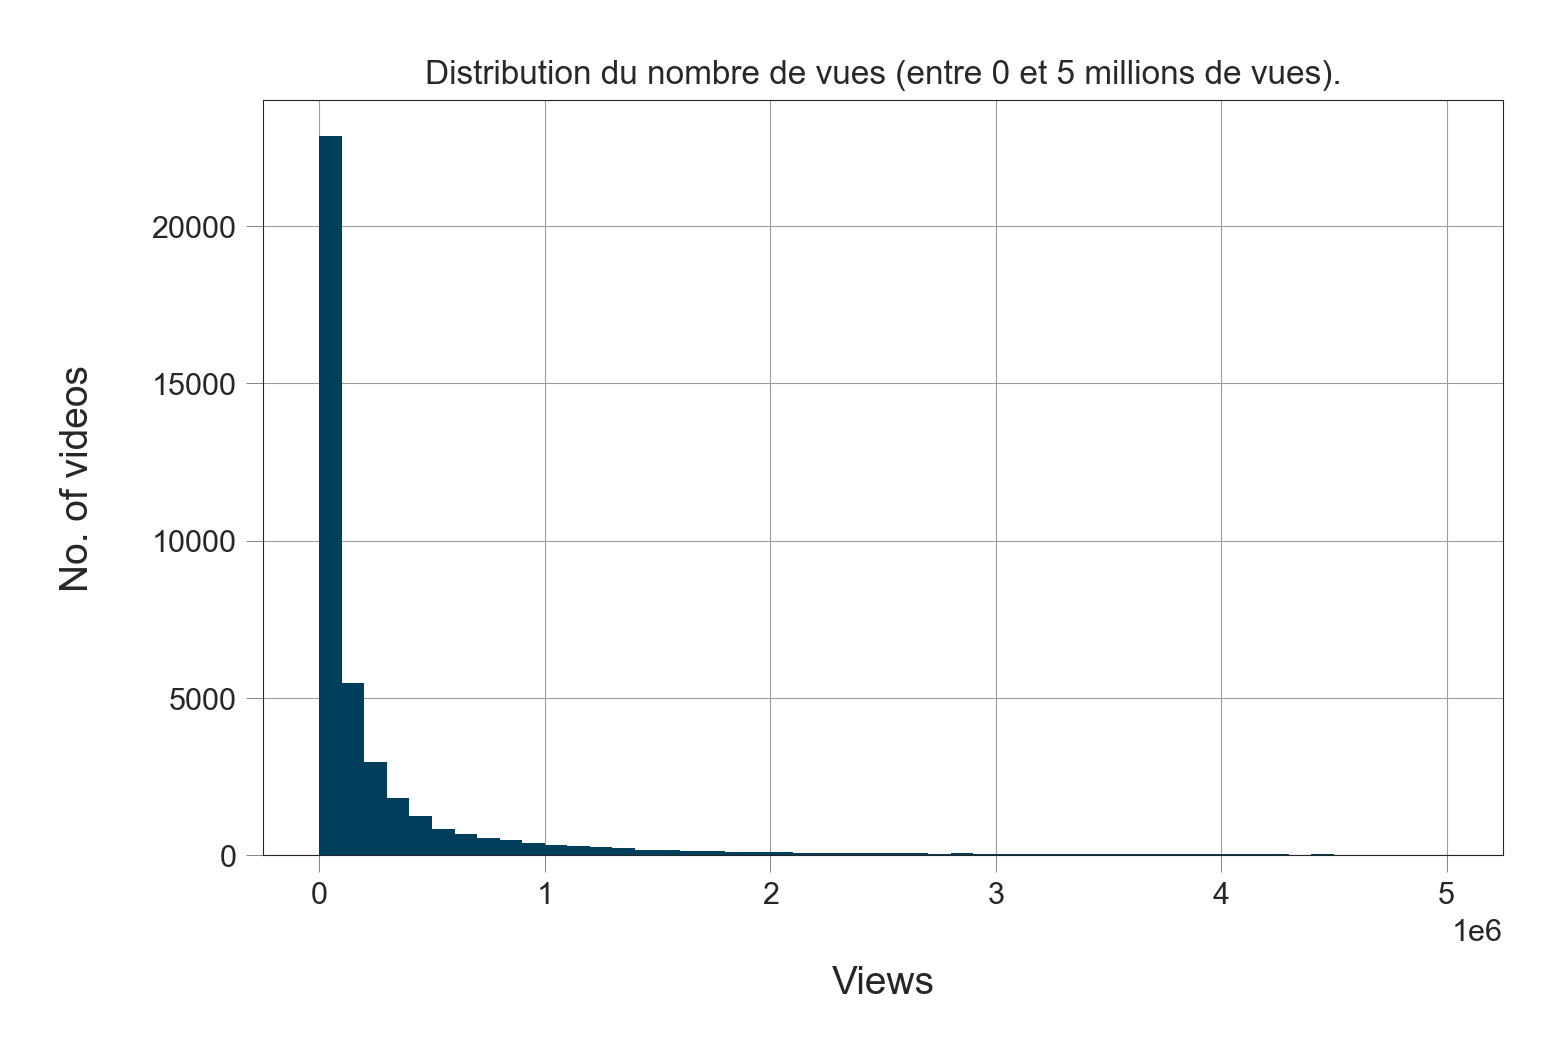

In [4]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["views"] < 5e6]["views"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos")
_ = plt.title('Distribution du nombre de vues (entre 0 et 5 millions de vues).')

On voit graphiquement que la majorité des vidéos ont moins d’un millions de vues. Déterminons le pourcentage de vidéos ayant moins d’un 1 million de vues. On a :

$$\large p = \frac{n1} {n} * 100 = 91.48 \% $$

avec :
p le pourcentage de vidéos ayant moins d’un 1 million de vues,
n la taille de l’échantillon (= 40724),
n1 le nombre de vidéos  ayant moins d’un 1 million de vues (= 37255), déterminé en Python comme suivant :


In [5]:
df[df['views'] < 1e6]['views'].count() / df['views'].count() * 100

91.48168156369708

In [6]:
df[df['views'] < 1e6]['views'].count()

37255

##### Distribution du nombre de vues (0 - Q3)

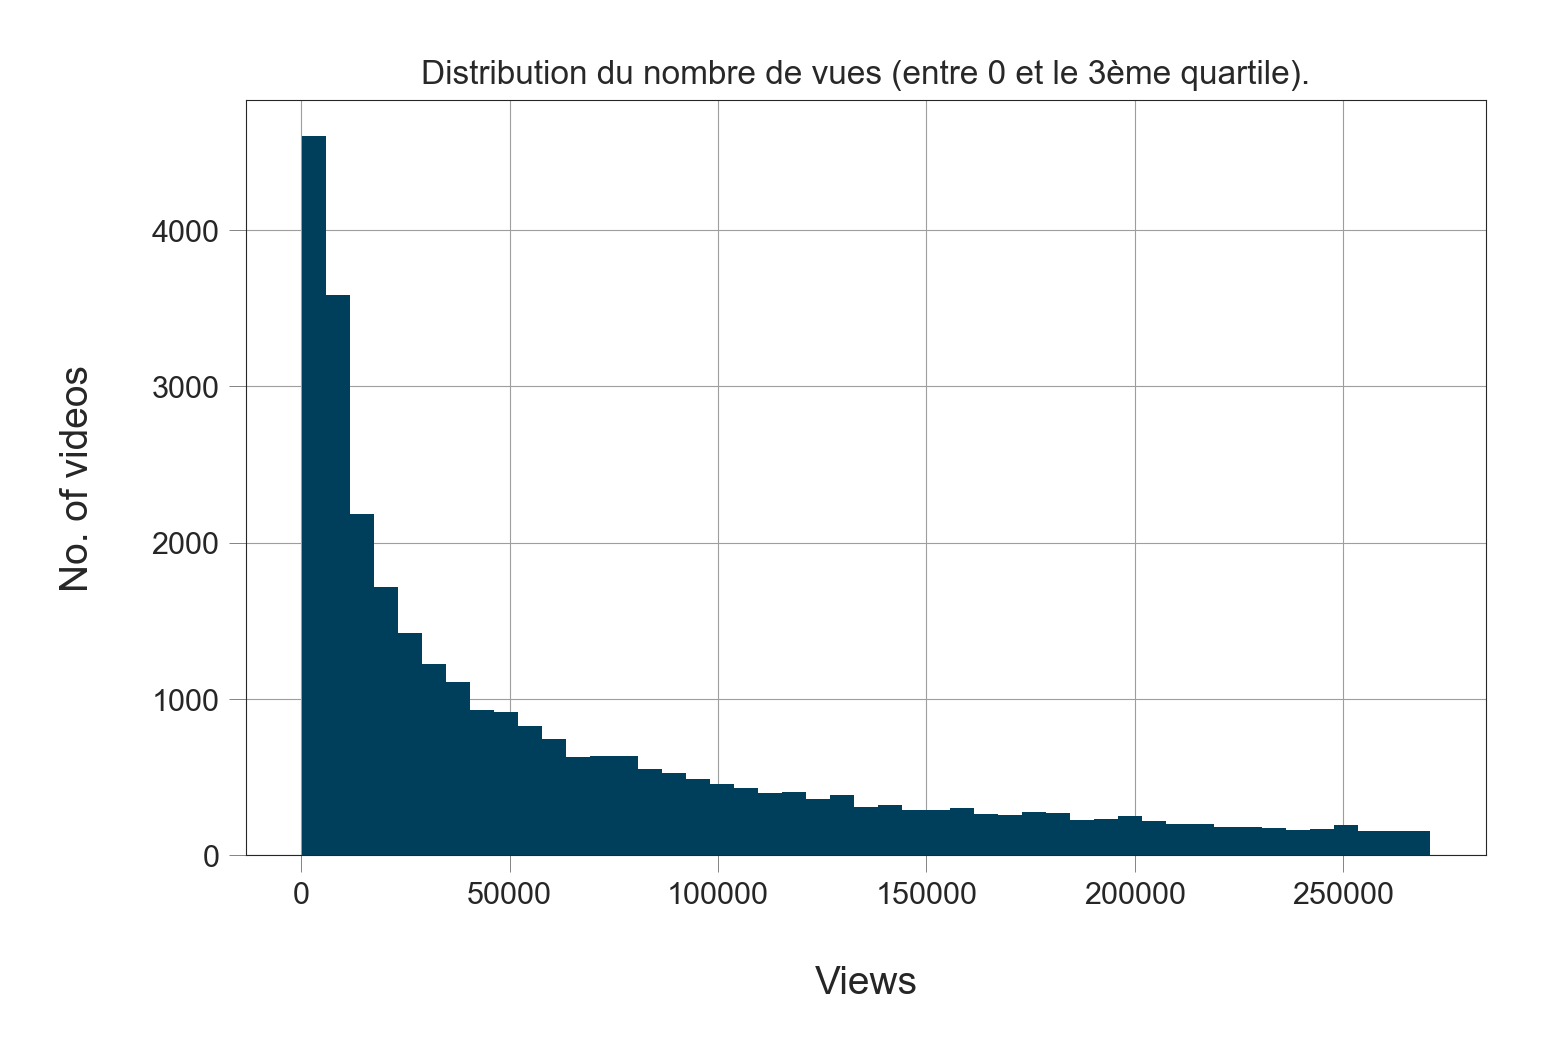

In [10]:
v_third_quantile = df["views"].quantile(0.75)
fig, ax = plt.subplots()
_ = sns.distplot(df[df["views"] < v_third_quantile]["views"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos")
_ = plt.title('Distribution du nombre de vues (entre 0 et le 3ème quartile).')

Déterminons le pourcentage du nombre de vidéos ayant moins de vues que le troisième quartile (270808,75). On a :

$$\large p = \frac{n_1} {n} * 100 = 75\% $$

avec : 
- $p$ le pourcentage du nombre de vidéos ayant moins de vues que Q3,
- $n$ la taille de l’échantillon (= 40724),
- $n1$ le nombre de vidéos avec moins de 270808,75 (Q3) vues (= 30543), déterminé en Python comme suivant :


In [11]:
df[df['views'] < v_third_quantile]['views'].count()

30543

Nous voyons bien à partir des valeurs de l’histogramme que au moins 75% des vidéos ont moins de 270808,75 vues. Cette analyse quantitative confirme l'analyse descriptive vue plus haut avec le tableau.

#### 2.2 Variable `likes`

**Pré-analyse**

La variable `likes` est un nombre entier représentant le nombre d’utilisateurs ayant aimé une vidéo. Concrètement, il s’agit du nombre d’utilisateurs ayant cliqué sur le bouton représentant un pouce levé sous la vidéo. Le nombre de likes a été comptabilisé à la date donnée par la variable `trending_date`.

In [12]:
df[['likes']].describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

count      mean       std   min     25%      50%      75%  \
likes  40724.00  17388.86  87205.09  0.00  338.00  1892.50  7969.50   

              max  
likes  4750254.00

D’après le tableau ci-dessus, nous observons qu’une vidéo en tendance a en moyenne 17388,86 likes. La valeur médiane du nombre de likes est 1892,50, ce qui signifie que la moitié des vidéos en tendance ont une quantité de likes inférieure à ce nombre et l'autre moitié ont une quantité de likes supérieure à ce nombre.

Le premier quartile nous montre qu'au moins 25% des vidéos en tendances ont moins de 1893 likes et le troisième quartile nous montre qu'au moins 75% des vidéos en tendances ont moins de 7969,5 likes. 

Liker une vidéo est une action “optionnelle” qui nécessite d’être connecté à son compte Google. Tous les utilisateurs ne prennent pas forcément le temps de réaliser cette action et c’est donc pour cela que le nombre de likes est très inférieur au nombre de vues.

Le fait que la moyenne et que la médiane soient si différentes peut s’expliquer par la présence de valeurs extrêmes. Ceci est confirmé par la valeur de l’écart-type, très éloigné de la moyenne et qui implique que l’échantillon est non-homogène.

**Nota bene:** lors de la publication d’une vidéo, l’utilisateur a le choix d’activer/désactiver la notation d’une vidéo. Cela a pour conséquence de désactiver les boutons likes et dislikes sous la vidéo. C’est pour cette raison que le nombre de likes vaut 0 pour certains individus. On peut savoir si la notation a été désactivée grâce à la variable `ratings_disabled` du dataset.

Cette pré-analyse étant faite, représentons l’échantillon sous la forme d’un histogramme sous échelle logarithmique pour avoir une vision plus précise.

##### Distribution du nombre de likes (0 - 5 millions)

Dans un premier temps, représentons la totalité des likes. Le minimum étant 0 et le maximum 4750254 (déterminés lors de l’étape de pré-analyse), nous avons choisi de représenter la distribution entre 0 et 5 millions.

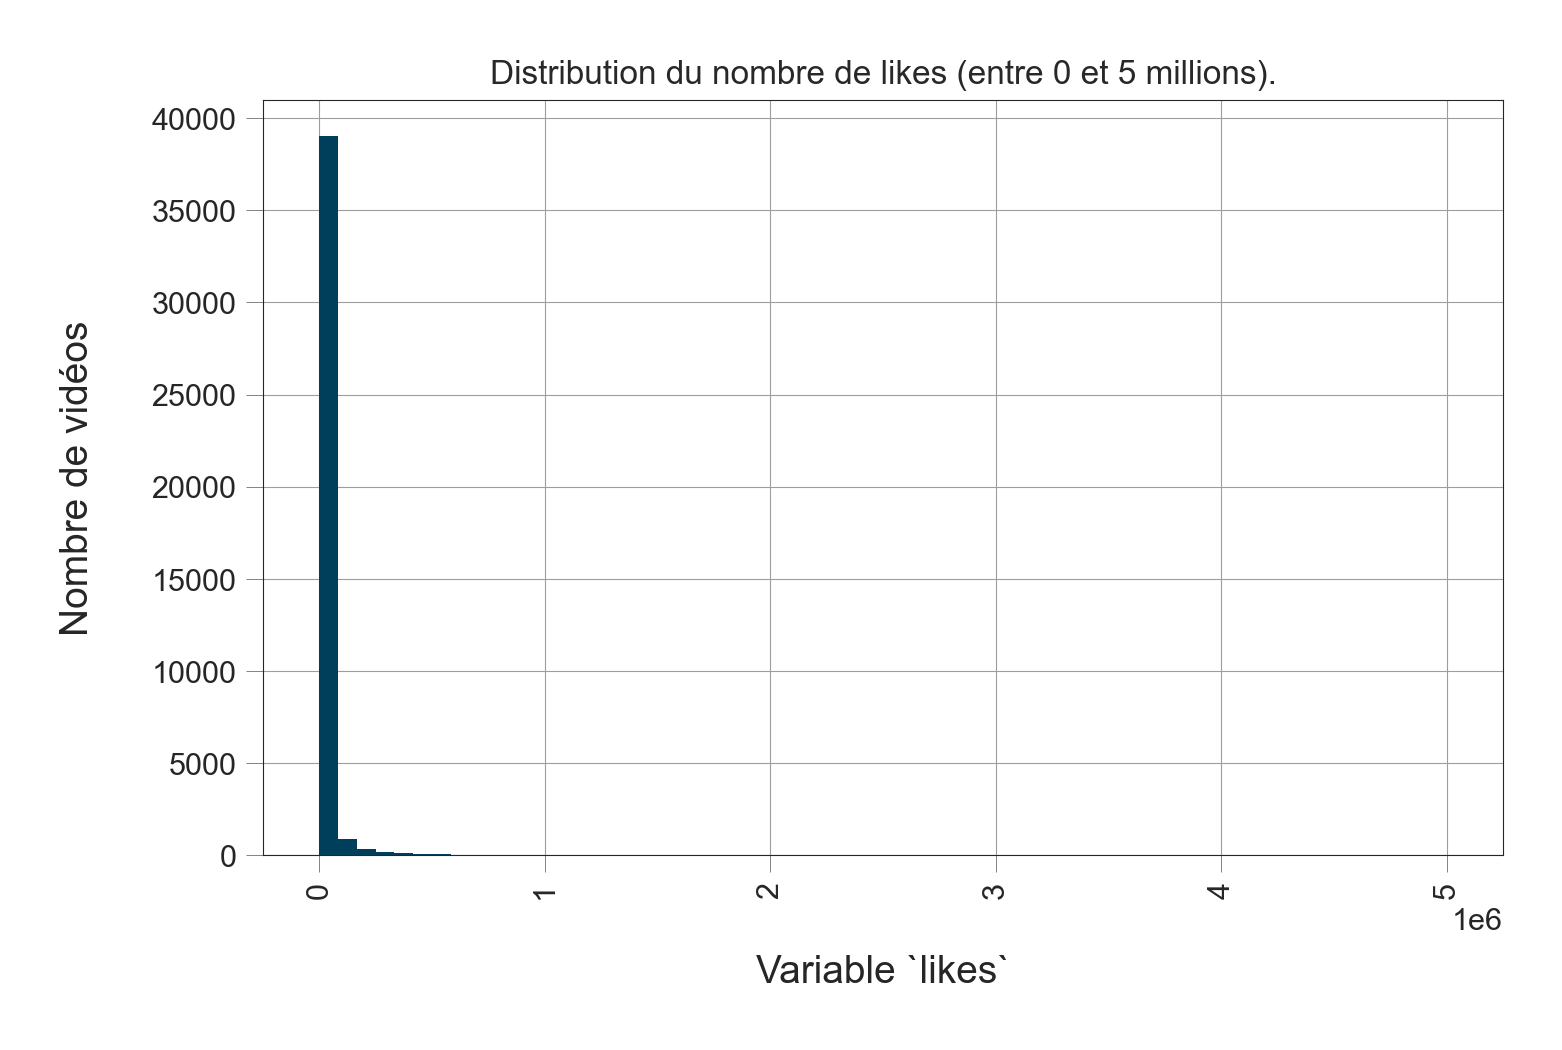

In [13]:
fig, ax = plt.subplots()
_ = sns.distplot(df["likes"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1},
                 bins=np.linspace(0, 5e6, 61), ax=ax)
_ = ax.set(xlabel="Variable `likes`", ylabel="Nombre de vidéos")
_ = plt.xticks(rotation=90)
_ = plt.title('Distribution du nombre de likes (entre 0 et 5 millions).')

On peut voir sur la distribution ci-dessus que la majorité des vidéos en tendance ont 100 000 likes ou moins, chose que l’on avait déjà remarqué avec la statistique descriptive vue plus haut. Etant donné que la majorité des vidéos ont 100 000 likes ou moins, intéressons-nous à cet intervalle.

##### Distribution du nombre de likes (0 - 100 000)

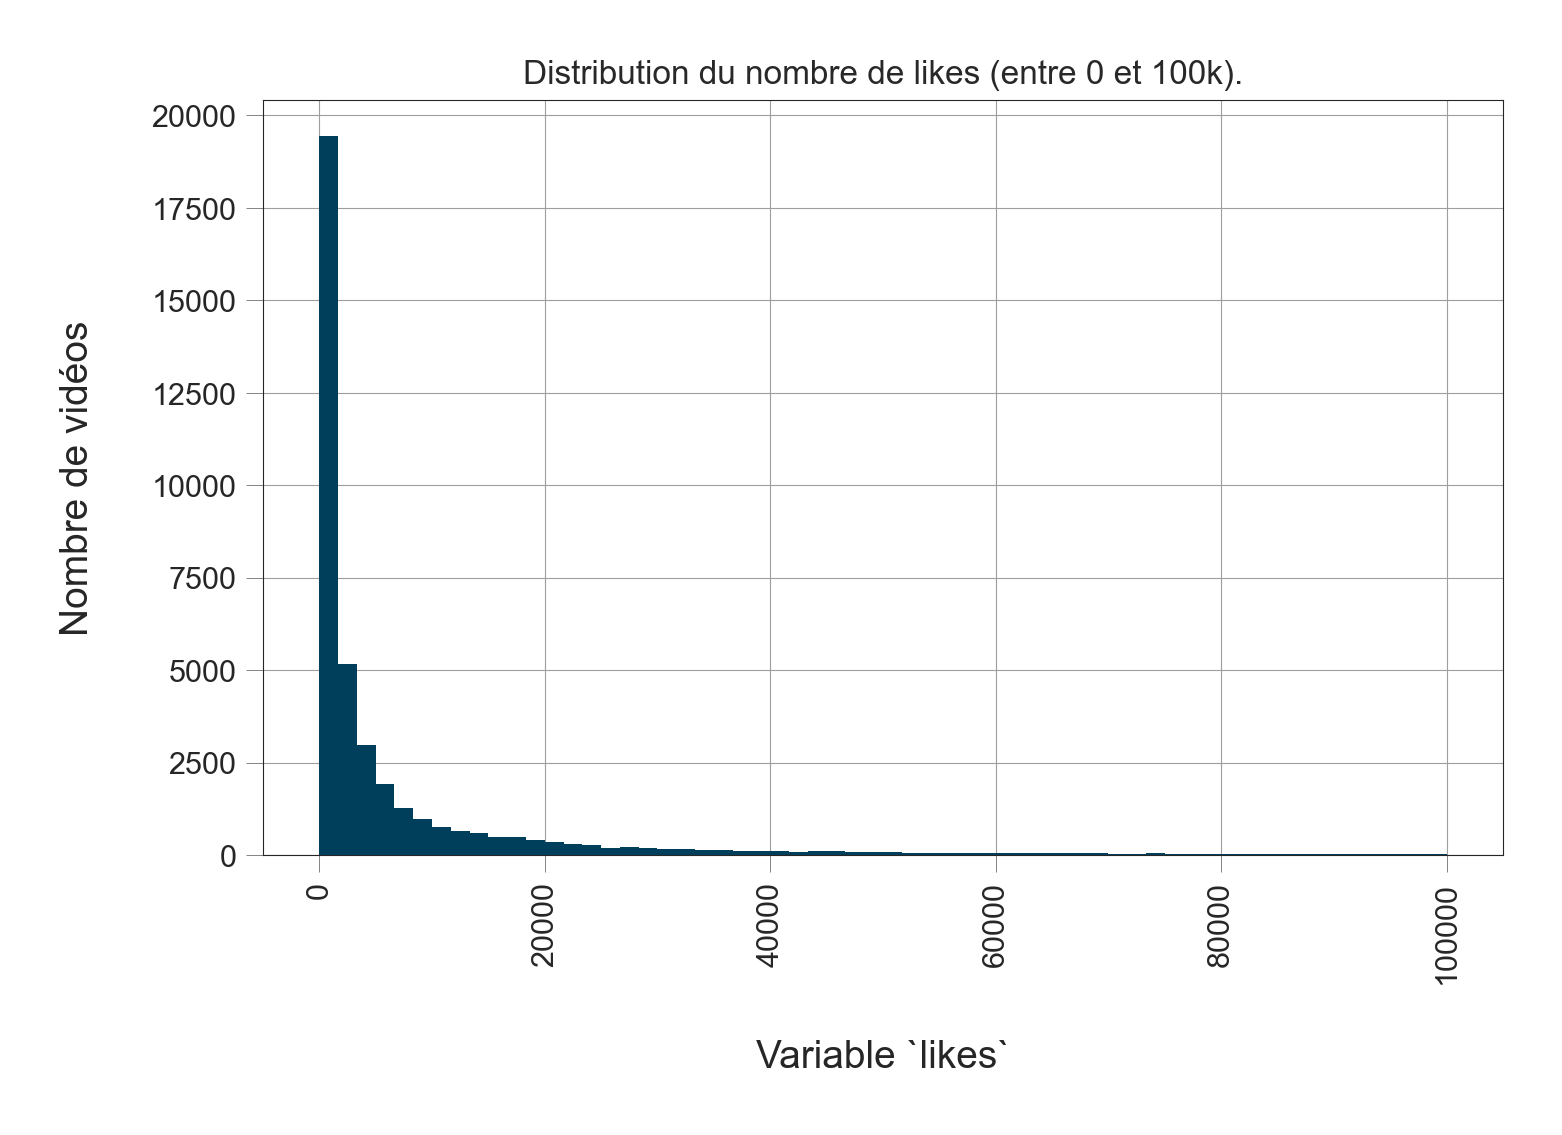

In [14]:
fig, ax = plt.subplots()
_ = sns.distplot(df["likes"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1},
                 bins=np.linspace(0, 1e5, 61), ax=ax)
_ = ax.set(xlabel="Variable `likes`", ylabel="Nombre de vidéos")
_ = plt.xticks(rotation=90)
_ = plt.title('Distribution du nombre de likes (entre 0 et 100k).')

On voit graphiquement que la majorité des vidéos ont moins de 10 000 likes. Déterminons le pourcentage de vidéos ayant moins de 10 000 likes. On a :

$$\large p = \frac{n_1} {n} * 100 = 78.04\% $$

avec:
- $p$ le pourcentage de vidéos ayant moins de 10 000 likes,
- $n$ la taille de l’échantillon (= 40724),
- $n1$ le nombre de vidéos avec moins de 10000 likes (= 31781), déterminé en Python comme suivant 

In [15]:
df[df['likes'] < 1e4]['likes'].count() / df['likes'].count() * 100

78.03997642667714

In [16]:
df[df['likes'] < 1e4]['likes'].count()

31781

##### Distribution du nombre de likes (0 - Q3)

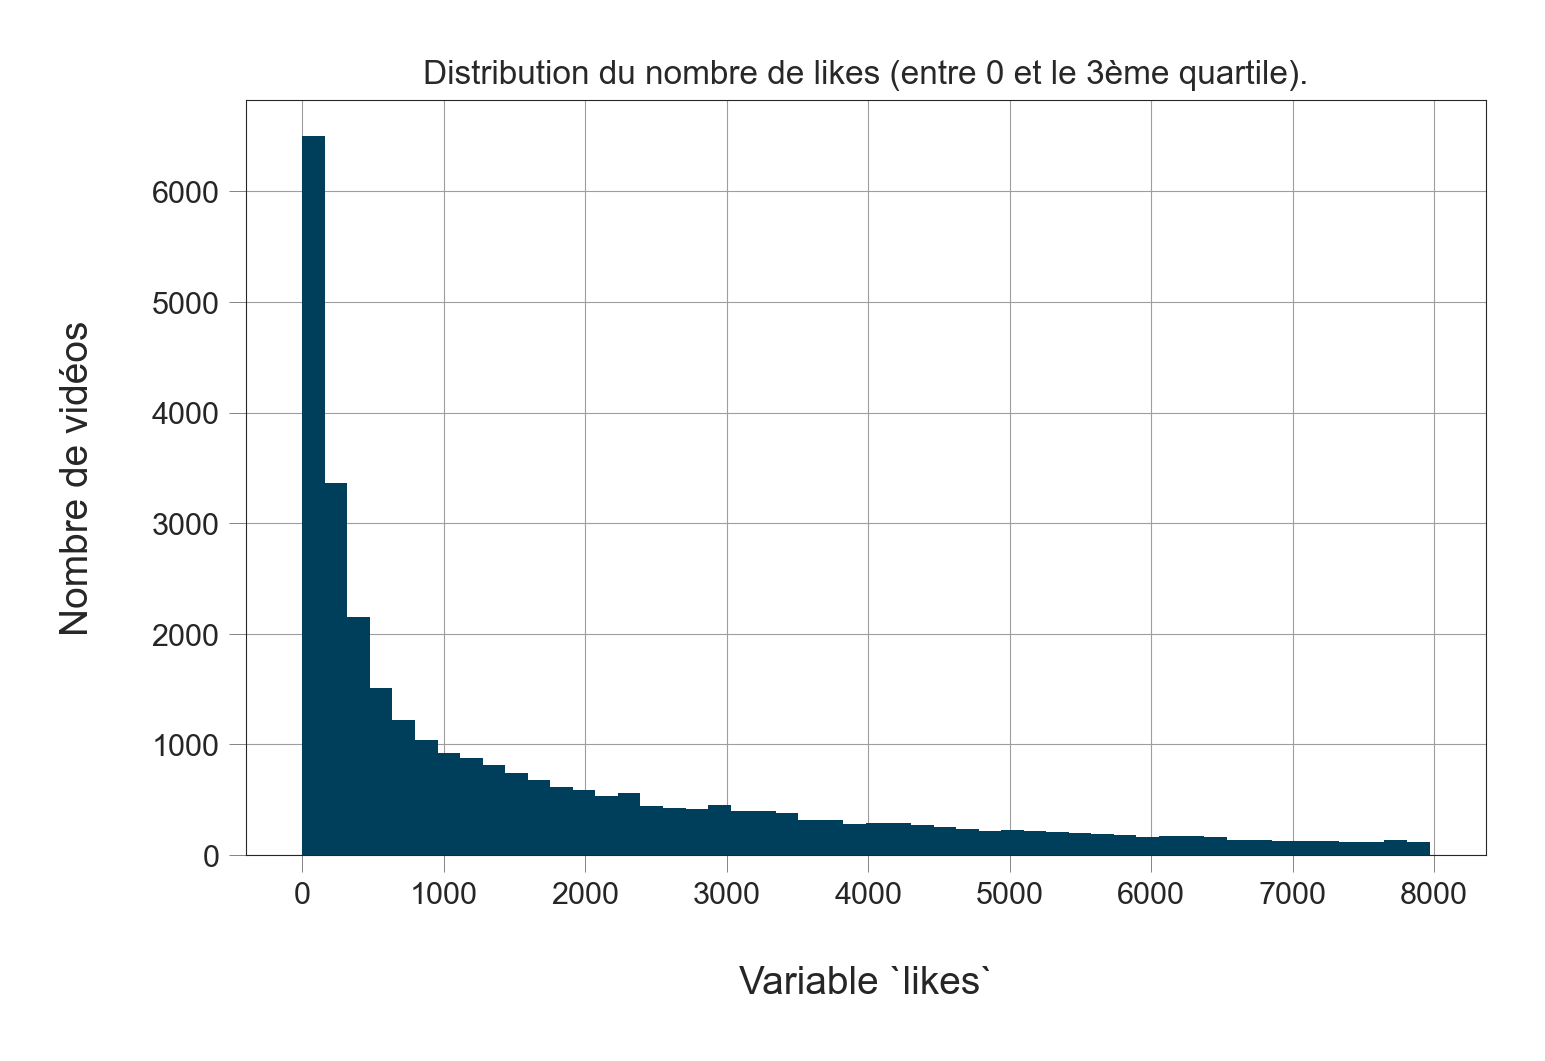

In [17]:
l_third_quantile = df["likes"].quantile(0.75)

fig, ax = plt.subplots()
_ = sns.distplot(df[df["likes"] < l_third_quantile]["likes"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Variable `likes`", ylabel="Nombre de vidéos")
_ = plt.title('Distribution du nombre de likes (entre 0 et le 3ème quartile).')

Déterminons le pourcentage du nombre de vidéos ayant moins de likes que le troisième quartile (7969,5). On a :

$$\large p = \frac {n_1} {n} * 100 = 75\% $$

avec : 
- $p$ le pourcentage du nombre de vidéos ayant moins de likes que Q3,
- $n$ la taille de l’échantillon (= 40724),
- $n1$ le nombre de vidéos avec moins de 7969,5 (Q3) likes (= 30543), déterminé en Python comme suivant :

In [19]:
df[df['likes'] < l_third_quantile]['likes'].count() / df['likes'].count() * 100

75.0

In [20]:
l_third_quantile = df["likes"].quantile(0.75)
df[df['likes'] < l_third_quantile]['likes'].count()

30543

Nous voyons bien à partir des valeurs de l’histogramme que au moins 75% des vidéos ont moins de 7969,5 likes. Cette analyse descriptive confirme l'analyse quantitative vue plus haut avec le tableau. Cette analyse quantitative confirme l'analyse descriptive vue plus haut avec le tableau.

### 2.3 Variable ``dislikes``

**Pré-analyse**

La variable `dislikes` est un nombre entier représentant le nombre d’utilisateurs n’ayant pas aimé la vidéo. Concrètement, il s’agit du nombre d’utilisateurs ayant cliqué sur le bouton représentant un pouce vers le bas sous la vidéo. Le nombre de dislikes a été comptabilisé à la date donnée par la variable `trending_date`.

In [45]:
df[['dislikes']].describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

count    mean       std   min    25%    50%     75%         max
dislikes  40724.00  814.96  11392.19  0.00  18.00  83.00  335.00  1353661.00

D’après le tableau ci-dessus, nous observons que le nombre moyen de dislikes d'une vidéo en tendance est de 814,96. La valeur médiane du nombre de dislikes est de 83 ce qui signifie que la moitié des vidéos en tendance ont une quantité de dislikes inférieure à ce nombre et l'autre moitié ont une quantité de dislikes supérieure à ce nombre.

Le premier quartile nous montre qu'au moins 25% des vidéos en tendances ont moins de 18 dislikes et le troisième quartile nous montre qu'au moins 75% des vidéos en tendances ont moins de 335 dislikes. 

Disliker une vidéo, tout comme le fait de la liker, est une action “optionnelle” qui nécessite d’être connecté à son compte Google. Le moyenne du nombre de dislikes est très inférieure à la moyenne du nombre de likes car encore moins d’utilisateurs prennent le temps de réaliser cette action. En effet, la plupart des utilisateurs quittent la vidéo s'ils s'aperçoivent qu’ils ne l’aiment pas et ne prennent pas le temps de laisser un dislike.

Le fait que la moyenne et que la médiane soient si différentes peut s’expliquer par la présence de valeurs extrêmes. Ceci est confirmé par la valeur de l’écart-type, très éloigné de la moyenne et qui implique que l’échantillon est non-homogène.

**Nota bene:** Comme pour la variable `likes`, un nombre de dislikes valant 0 pour certains individus peut vouloir dire que l’évaluation de la vidéo a été désactivée pour cette vidéo (variable `ratings_disabled`).

##### Distribution du nombre de dislikes (0 - 1 millions)

Dans un premier temps, représentons la totalité des dislikes. Le minimum étant 0 et le maximum 1353661 (déterminés lors de l’étape de pré-analyse), nous avons choisi de représenter la distribution entre 0 et 1 million.

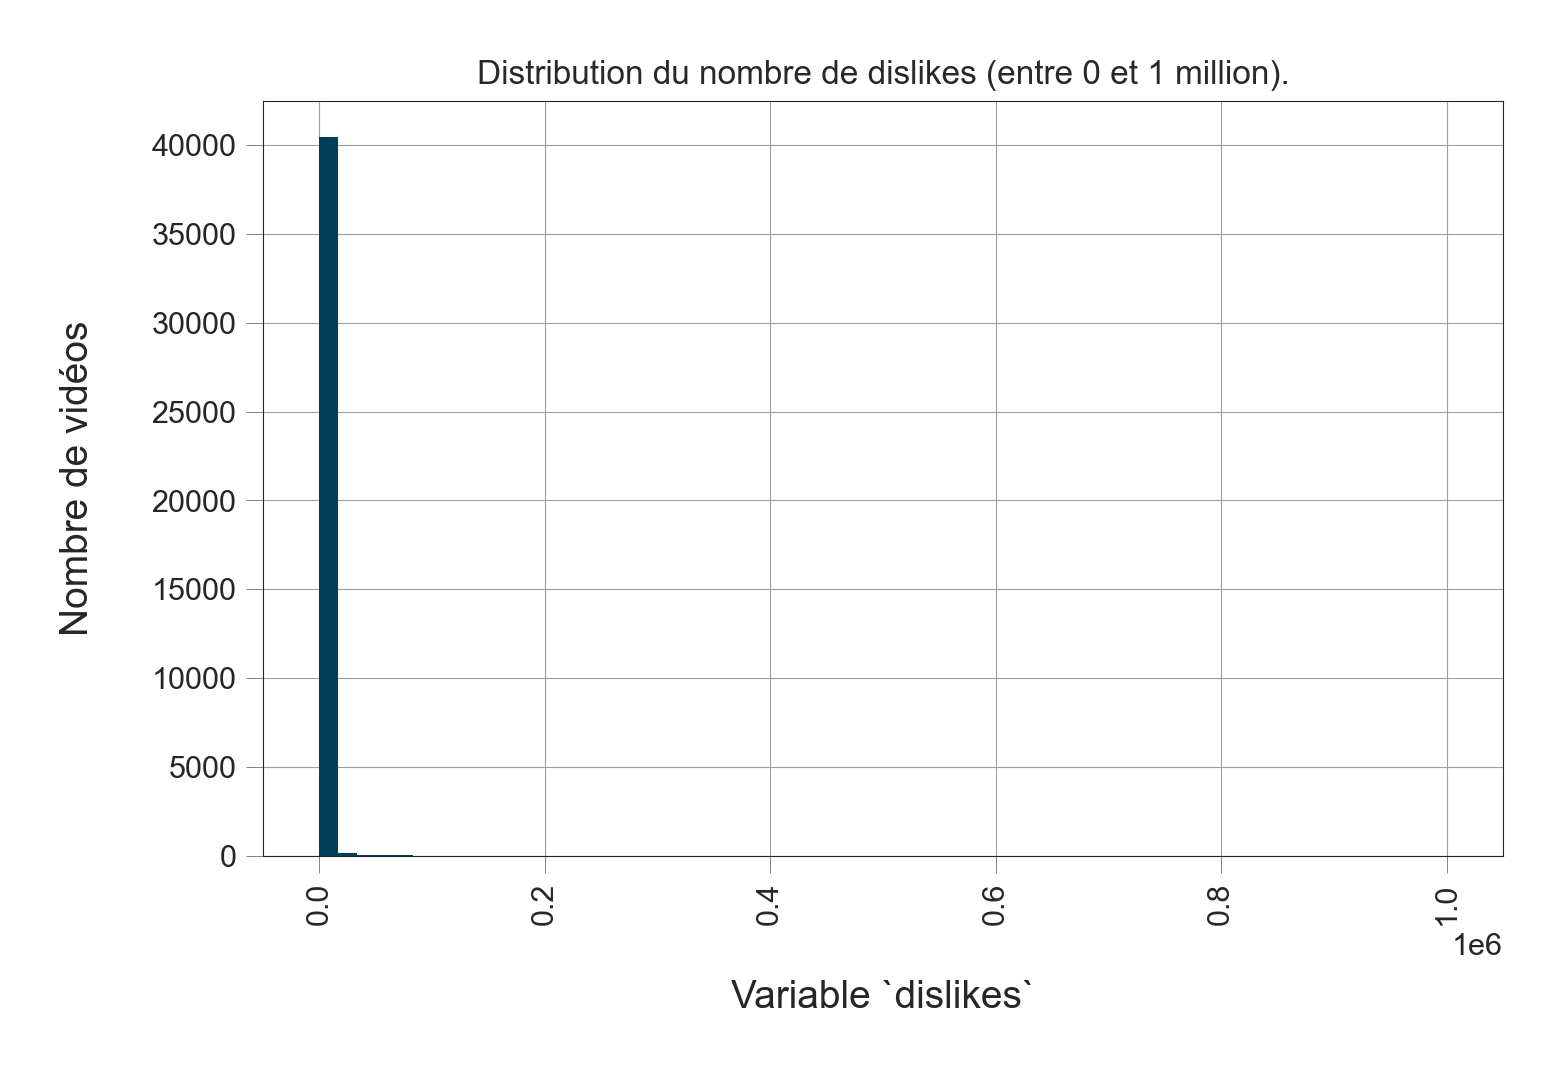

In [46]:
fig, ax = plt.subplots()
_ = sns.distplot(df["dislikes"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1},
                 bins=np.linspace(0, 1e6, 61), ax=ax)
_ = ax.set(xlabel="Variable `dislikes`", ylabel="Nombre de vidéos")
_ = plt.xticks(rotation=90)
_ = plt.title('Distribution du nombre de dislikes (entre 0 et 1 million).')

On peut voir sur la distribution ci-dessus que la majorité des vidéos en tendance ont 10 000 dislikes ou moins, chose que l’on avait déjà remarqué avec la statistique descriptive vue plus haut. Etant donné que la majorité des vidéos ont 10 000 dislikes ou moins, intéressons-nous à cet intervalle.

##### Distribution du nombre de dislikes (0 - 10 000)

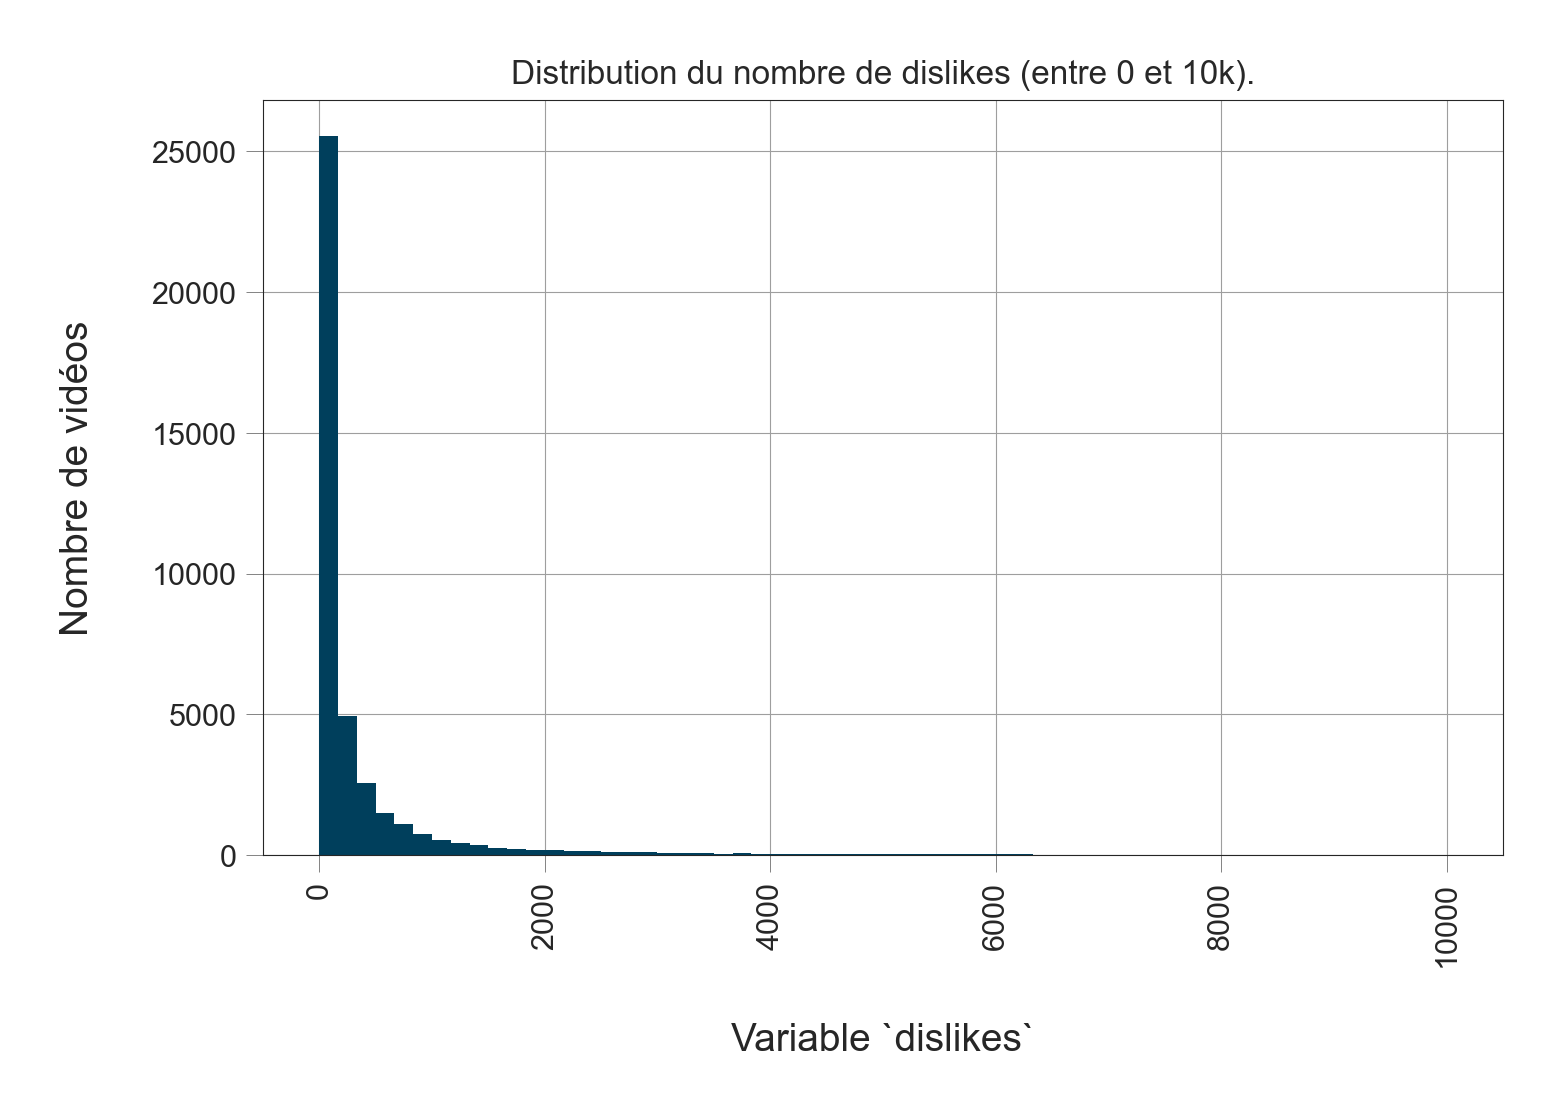

In [47]:
fig, ax = plt.subplots()
_ = sns.distplot(df["dislikes"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1},
                 bins=np.linspace(0, 1e4, 61), ax=ax)
_ = ax.set(xlabel="Variable `dislikes`", ylabel="Nombre de vidéos")
_ = plt.xticks(rotation=90)
_ = plt.title('Distribution du nombre de dislikes (entre 0 et 10k).')

On voit graphiquement que la majorité des vidéos ont moins de 2000 dislikes. Déterminons le pourcentage du nombre de vidéos ayant moins de 2000 dislikes. On a :

$$\large p = \frac{n_1} {n} * 100 = 94,4\%$$

avec :
- $p$ le pourcentage du nombre de vidéos ayant moins de 2000 dislikes,
- $n$ la taille de l’échantillon (= 40724),
- $n1$ le nombre de vidéos avec moins de 2000 dislikes (= 38431), déterminé en Python comme suivant :

In [48]:
df[df['dislikes'] < 2e3]['dislikes'].count()

38431

##### Distribution du nombre de dislikes (0 - Q3)

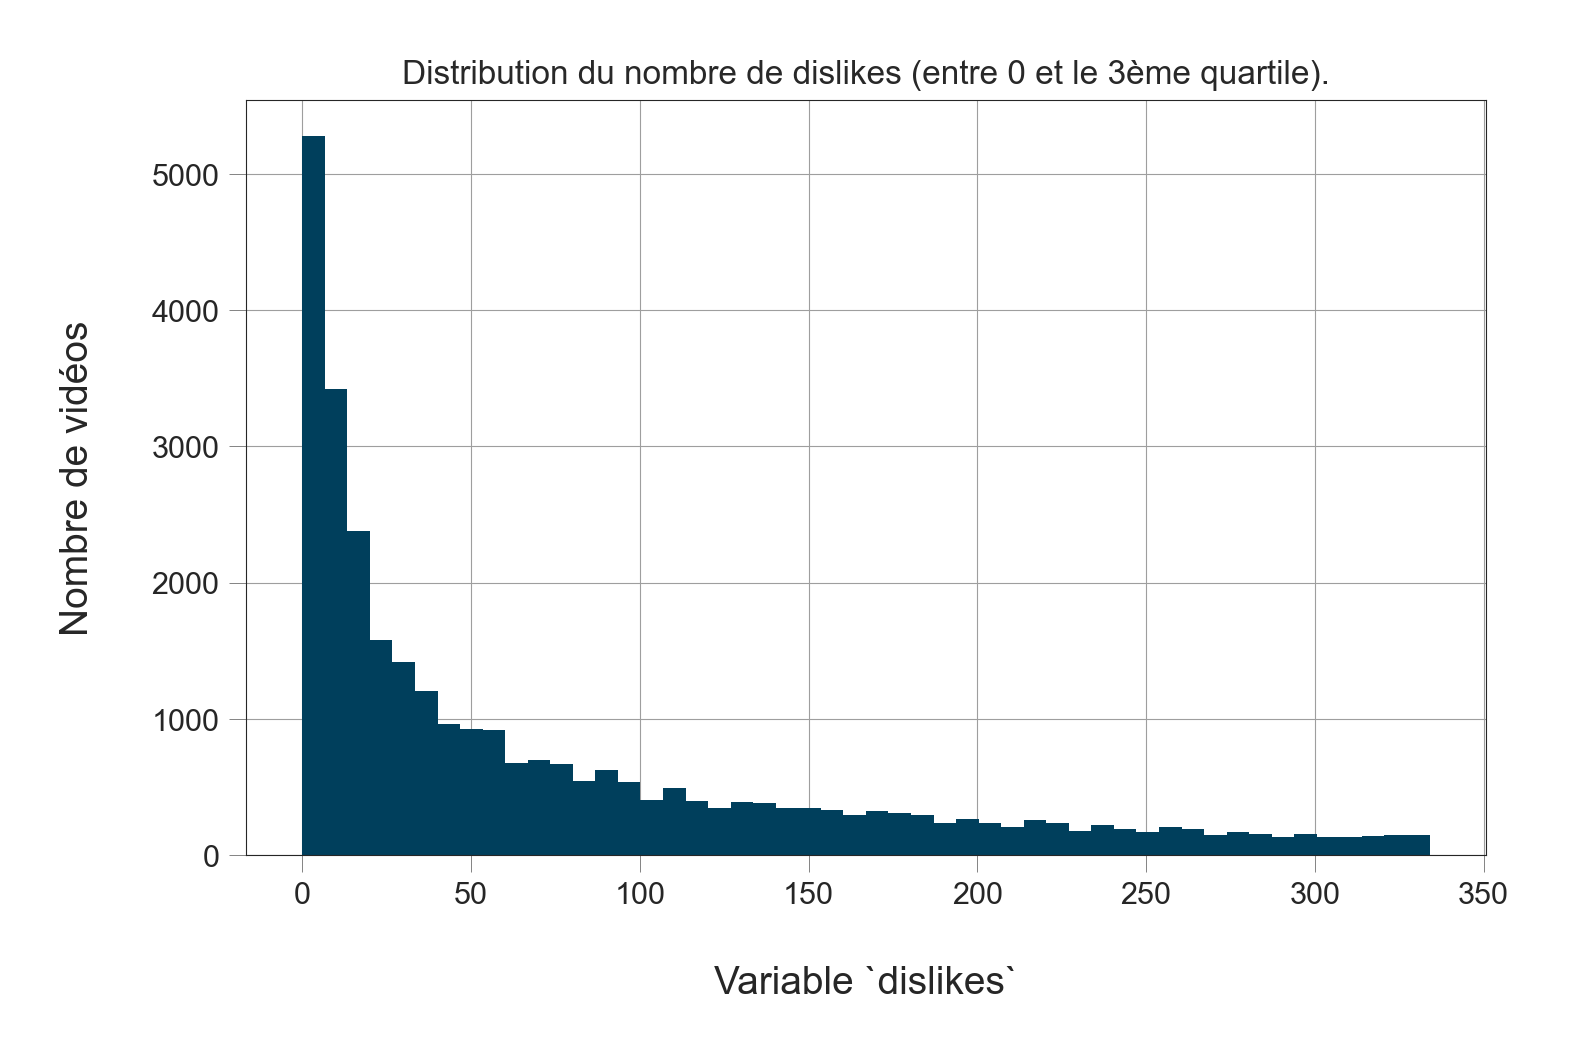

In [49]:
dl_third_quantile = df["dislikes"].quantile(0.75)
fig, ax = plt.subplots()
_ = sns.distplot(df[df["dislikes"] < dl_third_quantile]["dislikes"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Variable `dislikes`", ylabel="Nombre de vidéos")
_ = plt.title('Distribution du nombre de dislikes (entre 0 et le 3ème quartile).')

Déterminons le pourcentage du nombre de vidéos ayant moins de dislikes que le troisième quartile (335). On a :

$$\large p = \frac{n_1} {n} * 100 = 75\%$$

avec : 
- $p$ le pourcentage du nombre de vidéos ayant moins de dislikes que Q3,
- $n$ la taille de l’échantillon (= 40724),
- $n1$ le nombre de vidéos avec moins de 335 (Q3) dislikes (= 30528), déterminé en Python comme suivant :


In [55]:
dl_third_quantile = df["dislikes"].quantile(0.75)
df[df['dislikes'] < dl_third_quantile]['dislikes'].count()

30528

Nous voyons bien à partir des valeurs de l’histogramme que au moins 75% des vidéos ont moins de 335 dislikes. Cette analyse quantitative confirme l'analyse descriptive vue plus haut avec le tableau.

### 2.4 Variable `comment_count`

**Pré-analyse**

La variable `comment_count` est un nombre entier représentant le nombre de commentaires pour cette vidéo. Le nombre de likes a été comptabilisé à la date donnée par la variable `trending_date`.

In [31]:
df[['comment_count']].describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

count     mean       std   min    25%     50%     75%  \
comment_count  40724.00  1832.45  14043.21  0.00  56.00  235.00  841.00   

                      max  
comment_count  1040912.00

D’après le tableau ci-dessus, nous observons que le nombre moyen de commentaires d'une vidéo tendance est de 1832,45. La valeur médiane du nombre de commentaires est de 235, ce qui signifie que la moitié des vidéos en tendance ont une quantité de commentaires inférieure à ce nombre et l'autre moitié ont une quantité de commentaires supérieure à ce nombre.

Le premier quartile nous montre qu'au moins 25% des vidéos en tendances ont moins de 56 commentaires et le troisième quartile nous montre qu'au moins 75% des vidéos en tendances ont moins de 841 commentaires. 

Commenter une vidéo, tout comme le fait de liker/disliker une vidéo, est une action “optionnelle” qui nécessite d’être connecté à son compte Google. 

Étonnement, la moyenne du nombre de commentaires est plus élevée que celle du nombre de dislikes, alors que l’action de commenter est beaucoup plus longue que l’action de disliker. Le nombre de commentaires est tout de même inférieur au nombre de likes car la rédaction d’un commentaire demande plus d’effort. 

Le fait que la moyenne et que la médiane soient si différentes peut s’expliquer par la présence de valeurs extrêmes. Ceci est confirmé par la valeur de l’écart-type, très éloigné de la moyenne et qui implique que l’échantillon est non-homogène.

**Nota bene:** lors de la publication d’une vidéo, l’utilisateur a le choix d’activer/désactiver les commentaires. C’est pour cette raison que le nombre de commentaires vaut 0 pour certains individus. On peut savoir si les commentaires ont été désactivés grâce à la variable `comments_disabled` du dataset.

Cette pré-analyse étant faite, représentons l’échantillon sous la forme d’un histogramme sous échelle logarithmique pour avoir une vision plus précise.


##### Distribution du nombre de commentaires (0 - 1 million)

Dans un premier temps, représentons la totalité des commentaires. Le minimum étant 0 et le maximum 1040912 (déterminés lors de l’étape de pré-analyse), nous avons choisi de représenter la distribution entre 0 et 1 million.

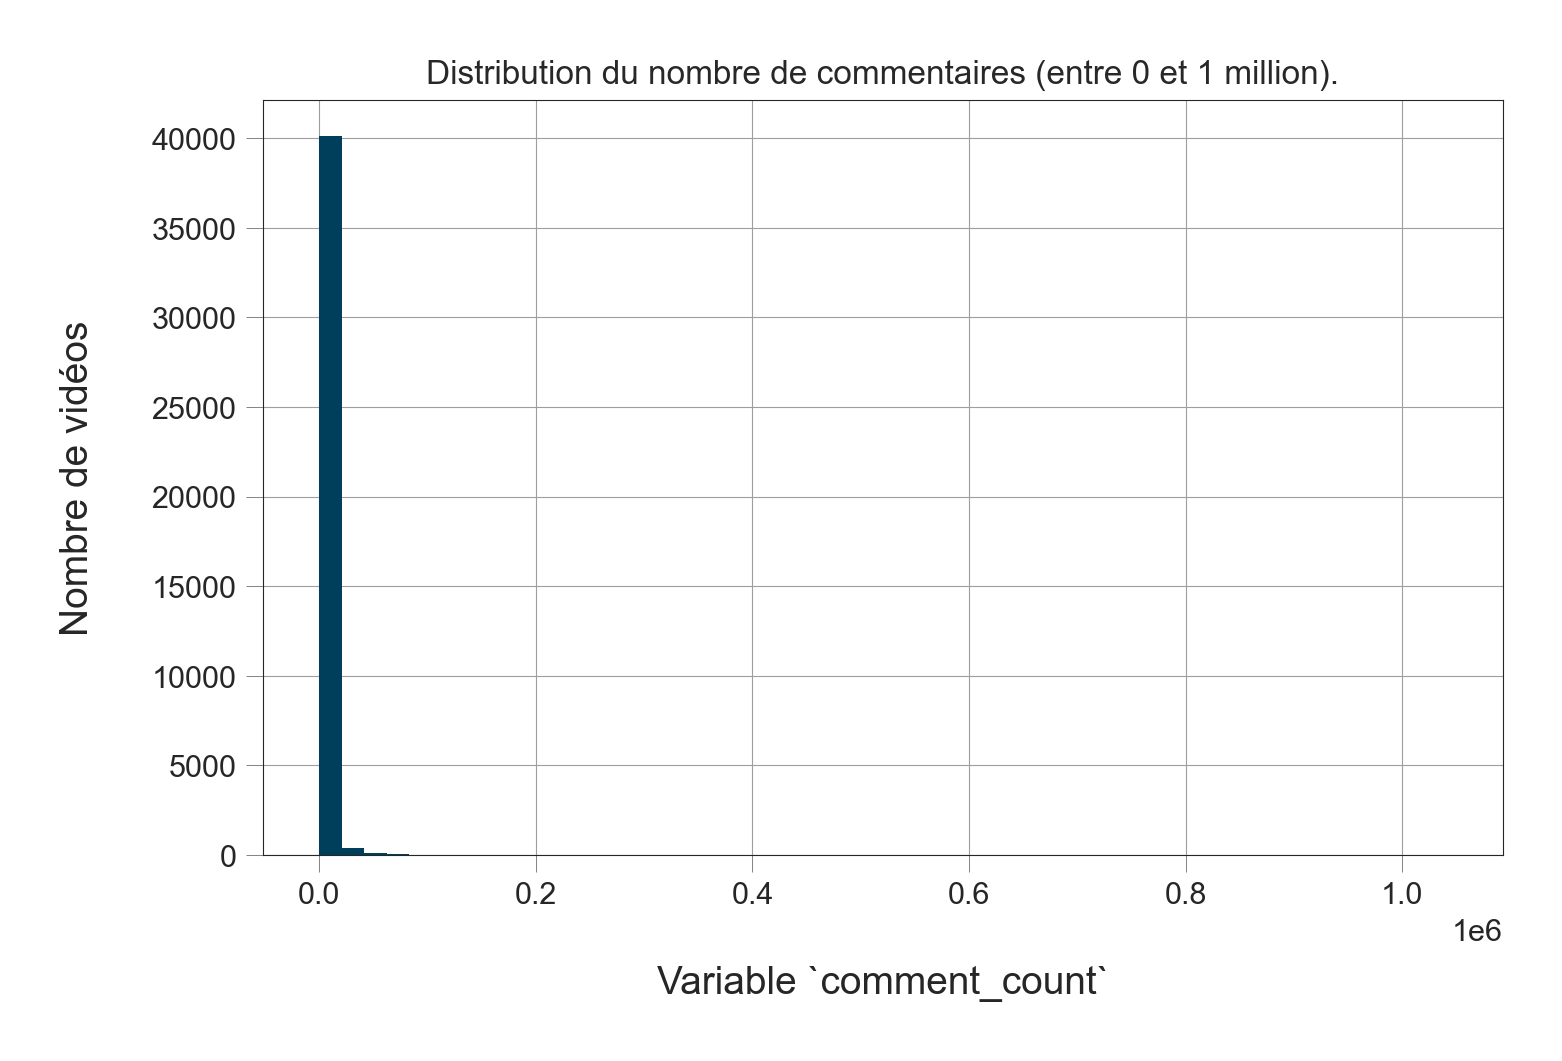

In [32]:
fig, ax = plt.subplots()
_ = sns.distplot(df["comment_count"], kde=False, rug=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Variable `comment_count`", ylabel="Nombre de vidéos")
_ = plt.title('Distribution du nombre de commentaires (entre 0 et 1 million).')

On peut voir sur la distribution ci-dessus que la majorité des vidéos en tendance ont 10 000 commentaires ou moins, chose que l’on avait déjà remarqué avec la statistique descriptive vue plus haut. Etant donné que la majorité des vidéos ont 10 000 commentaires ou moins, intéressons-nous à cet intervalle.

###### Distribution du nombre de commentaires (0 - 10 000)

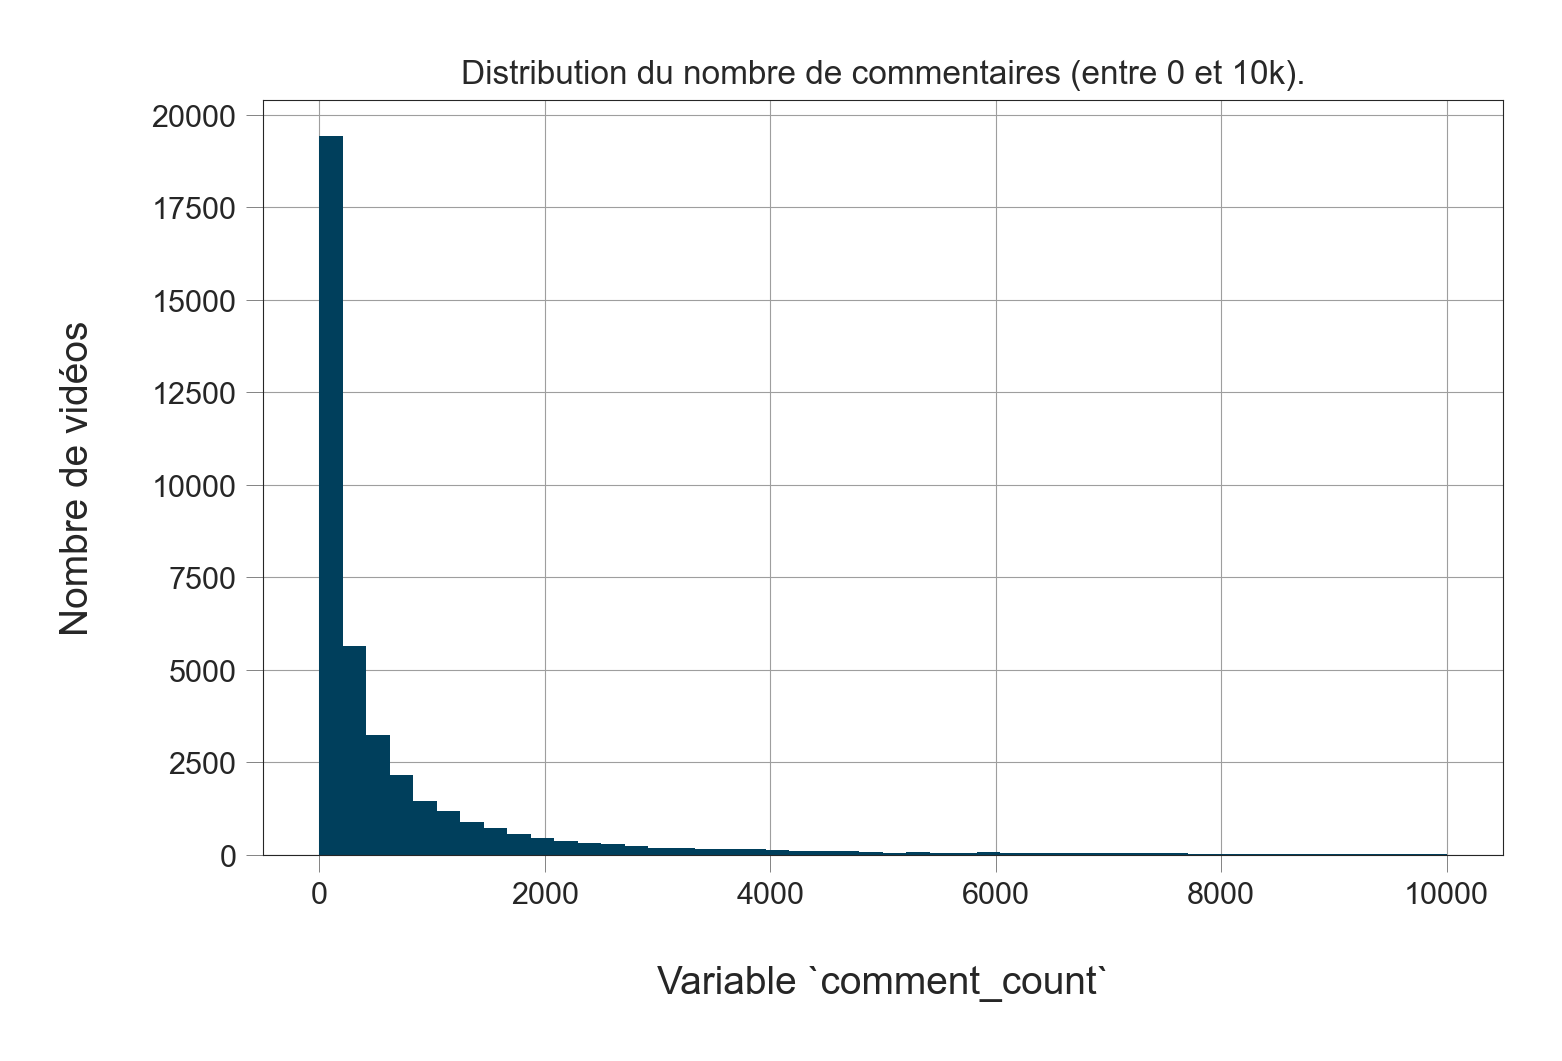

In [56]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["comment_count"] < 1e4]["comment_count"], kde=False, rug=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1},
                 bins=np.linspace(0, 1e4, 49), ax=ax)
_ = ax.set(xlabel="Variable `comment_count`", ylabel="Nombre de vidéos")
_ = plt.title('Distribution du nombre de commentaires (entre 0 et 10k).')

On voit graphiquement que la majorité des vidéos ont moins de 2000 commentaires. Déterminons c e pourcentage du nombre de vidéos ayant moins de 2000 commentaires. On a :

$$\large p = \frac{n_1} {n} * 100 = 87,4\%$$

avec :
- $p$ le pourcentage du nombre de vidéos ayant moins de 2000 commentaires,
- $n$ la taille de l’échantillon = 40724,
- $n1$ le nombre de vidéos avec moins de 2000 dislikes = 35610, déterminé en Python comme suivant :


In [65]:
df[df['comment_count'] < 2e3]['comment_count'].count()

35610

##### Distribution du nombre de commentaires (0 - Q3)

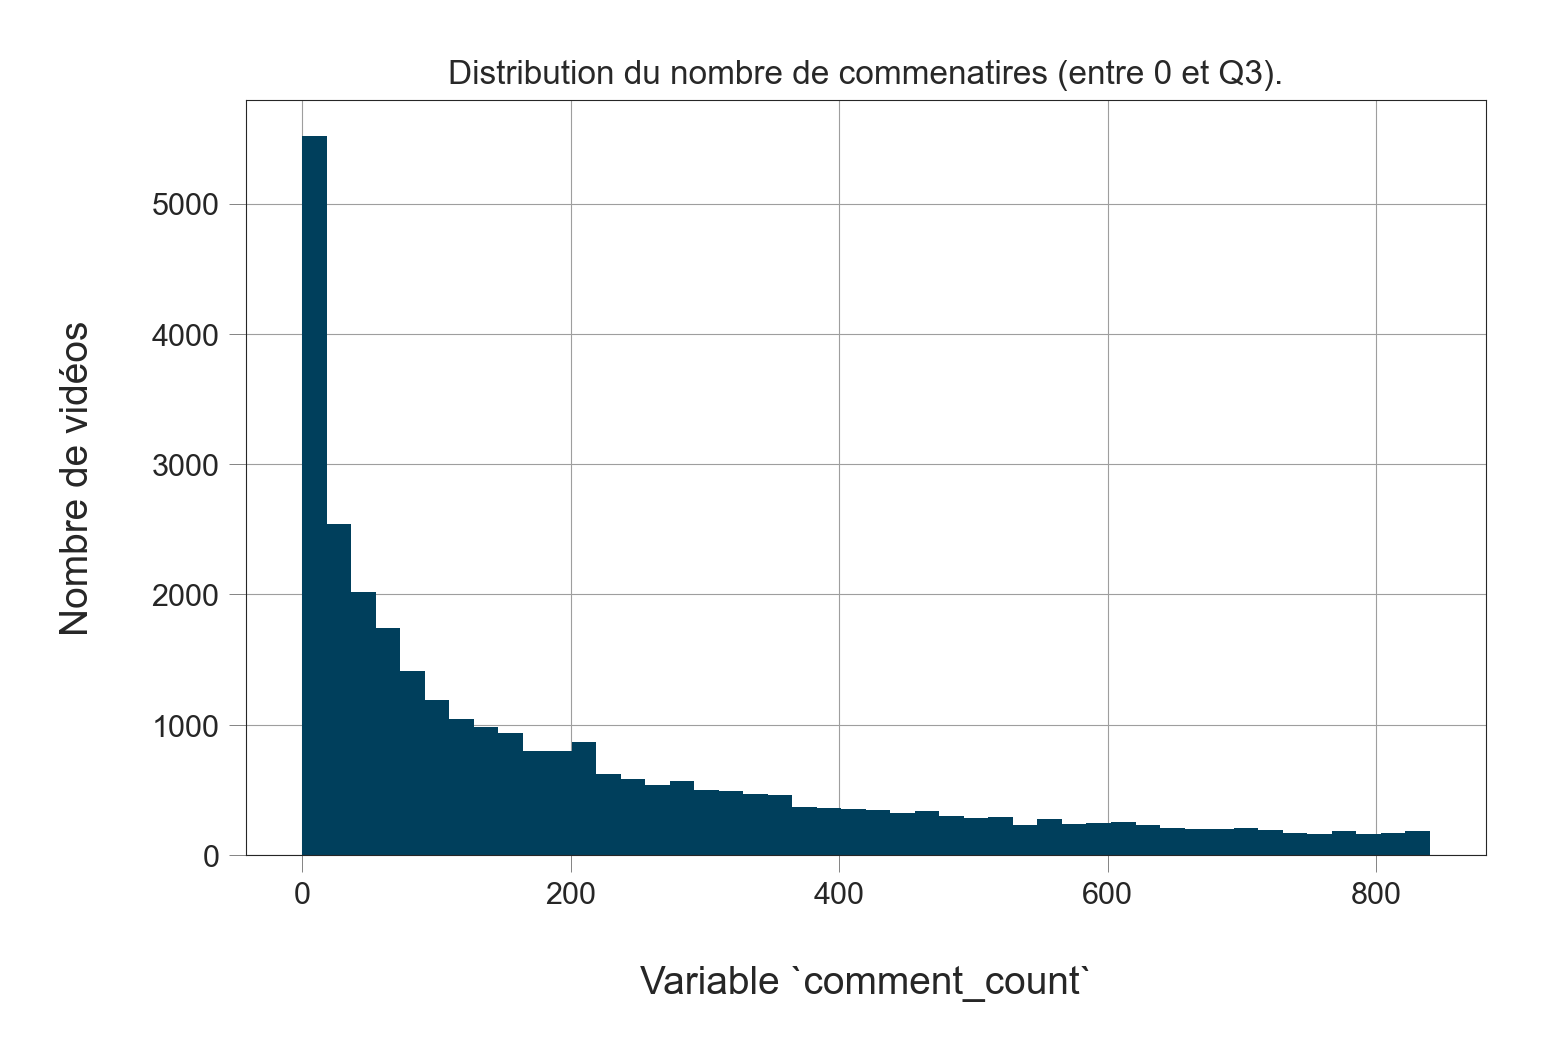

In [67]:
c_third_quantile = df["comment_count"].quantile(0.75)

fig, ax = plt.subplots()
_ = sns.distplot(df[df['comment_count'] < c_third_quantile]['comment_count'], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Variable `comment_count`", ylabel="Nombre de vidéos")
_ = plt.title('Distribution du nombre de commenatires (entre 0 et Q3).')

Déterminons le pourcentage du nombre de vidéos ayant moins de commentaires que le troisième quartile (841). On a :

$$\large p = \frac{n_1} {n} * 100 = 75\%$$

avec : 
- $p$ le pourcentage du nombre de vidéos ayant moins de commentaires que Q3,
- $n$ la taille de l’échantillon (= 40724),
- $n1$ le nombre de vidéos avec moins de 841 (Q3) commentaires (= 30536), déterminé en Python comme suivant :


In [68]:
c_third_quantile = df['comment_count'].quantile(0.75)
df[df['comment_count'] < c_third_quantile]['comment_count'].count()

30536

Nous voyons bien à partir des valeurs de l’histogramme que au moins 75% des vidéos ont moins de 841 dislikes. Cette analyse quantitative confirme l'analyse descriptive vue plus haut avec le tableau.

### 2.5 Variable ``comments_disabled``

La variable `comments_disabled` est un booléen indiquant si les commentaires ont été désactivés pour cette vidéo.

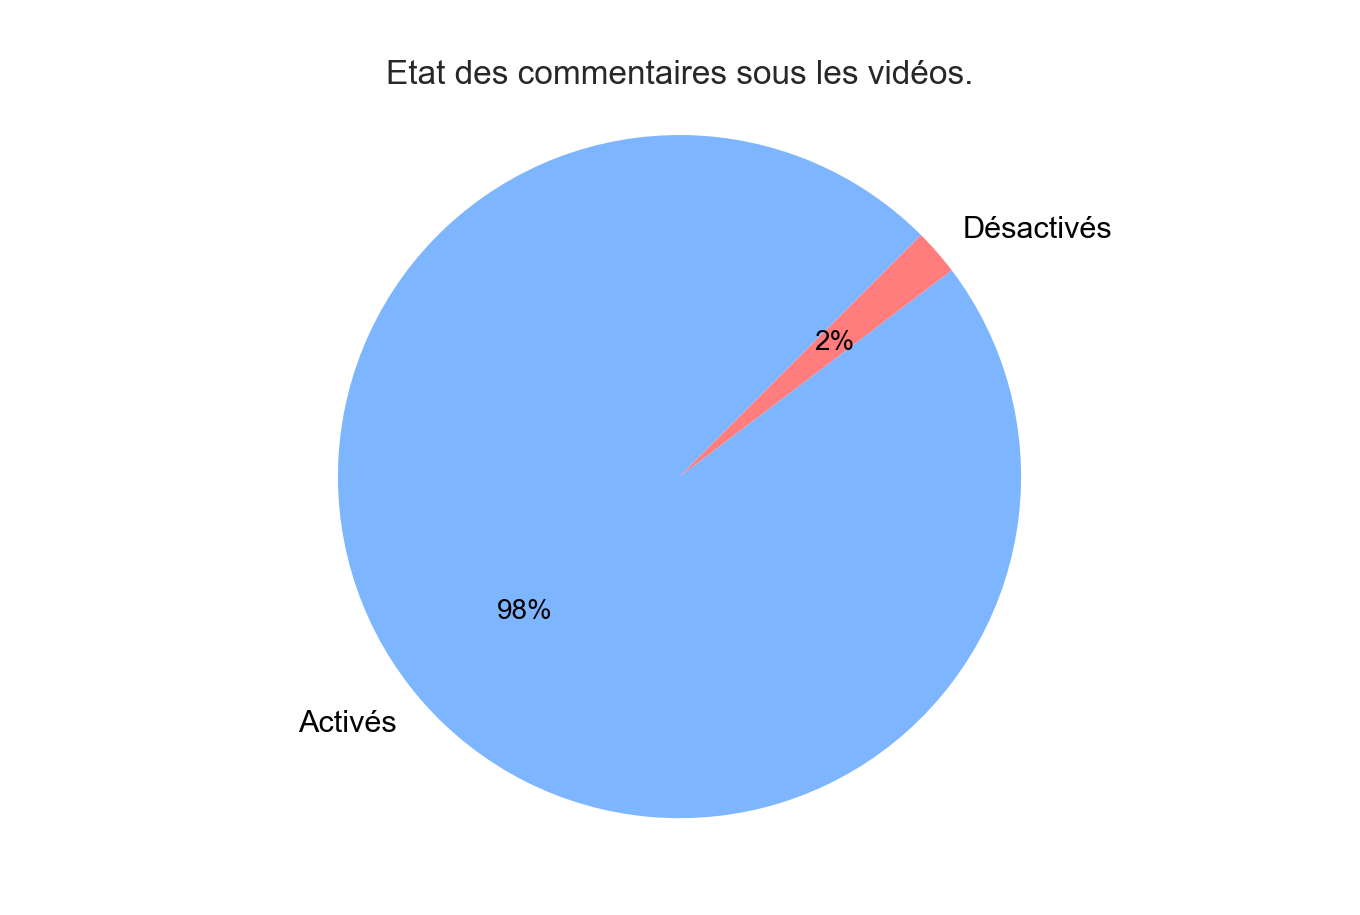

In [69]:
fig, ax = plt.subplots()

value_counts = df["comments_disabled"].value_counts().to_dict()

_ = ax.pie([value_counts[False], value_counts[True]], labels=['Activés', 'Désactivés'],
           colors=['#7db5ff', '#ff7d7d'], textprops={'color': '#040204'}, startangle=45, autopct='%1.0f%%')
_ = ax.axis('equal')
_ = ax.set_title('Etat des commentaires sous les vidéos.')

In [70]:
df["comments_disabled"].value_counts(normalize=True)

False   0.98
True    0.02
Name: comments_disabled, dtype: float64

Pour 98% des vidéos, les commentaires sont activés et pour les 2% restants, ils sont désactivés.

### 2.6 Variable ``ratings_disabled``

La variable `ratings_disabled` est un booléen indiquant si l’évaluation (likes/dislikes) a été désactivée pour cette vidéo.

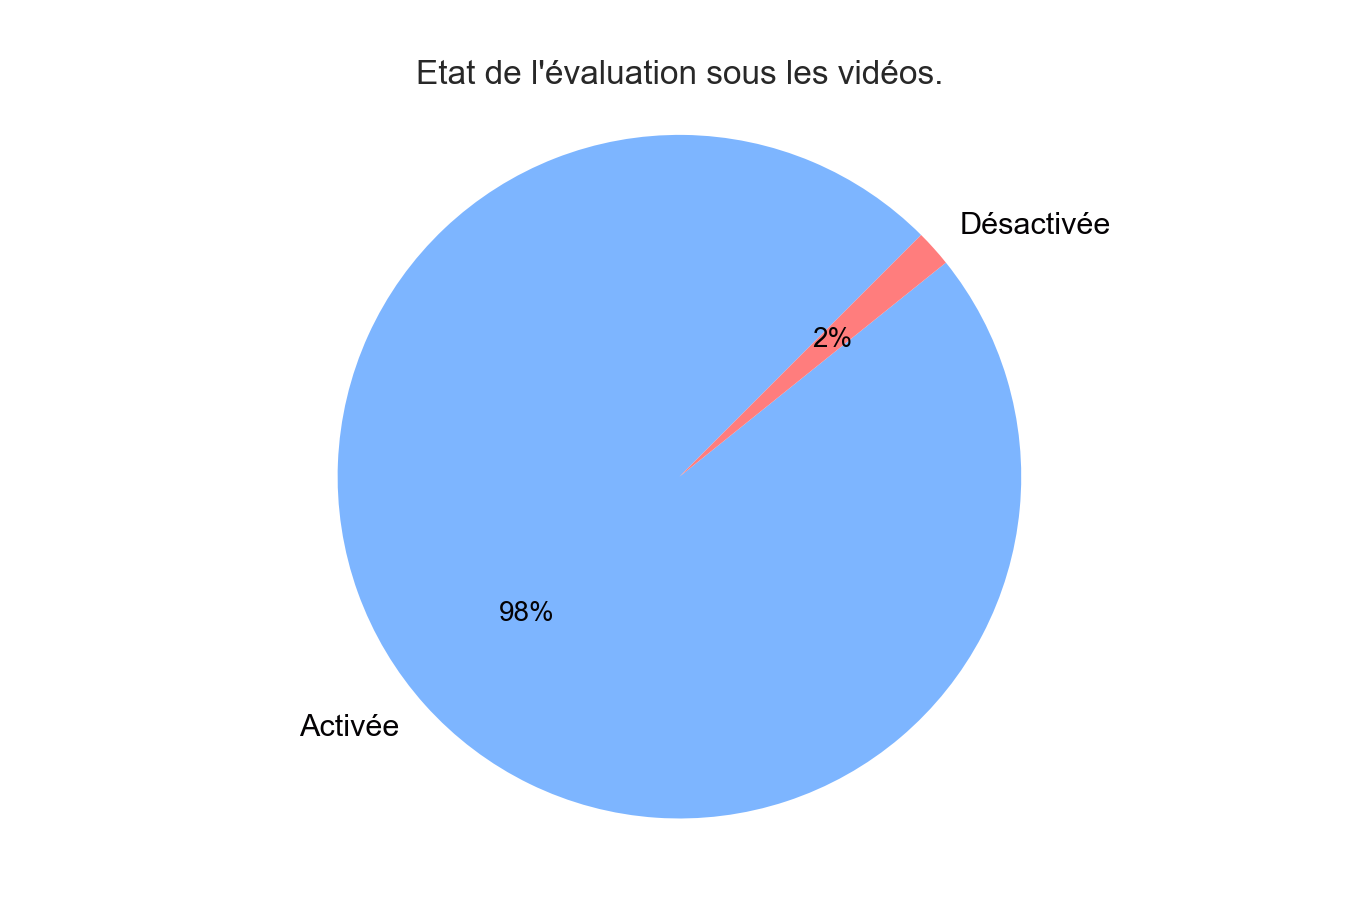

In [71]:
fig, ax = plt.subplots()

value_counts = df["ratings_disabled"].value_counts().to_dict()

_ = ax.pie([value_counts[False], value_counts[True]], labels=['Activée', 'Désactivée'],
           colors=['#7db5ff', '#ff7d7d'], textprops={'color': '#040204'}, startangle=45, autopct='%1.0f%%')
_ = ax.axis('equal')
_ = ax.set_title('Etat de l\'évaluation sous les vidéos.')

In [73]:
df["ratings_disabled"].value_counts(normalize=True)

False   0.98
True    0.02
Name: ratings_disabled, dtype: float64

Pour 98% des vidéos, l’évaluation est activée et pour les 2% restants, elle est désactivée.

### 2.7 Variable ``video_error_or_removed``

La variable `video_error_or_removed` est un booléen indiquant si la vidéo a rencontré un erreur ou a été supprimée.

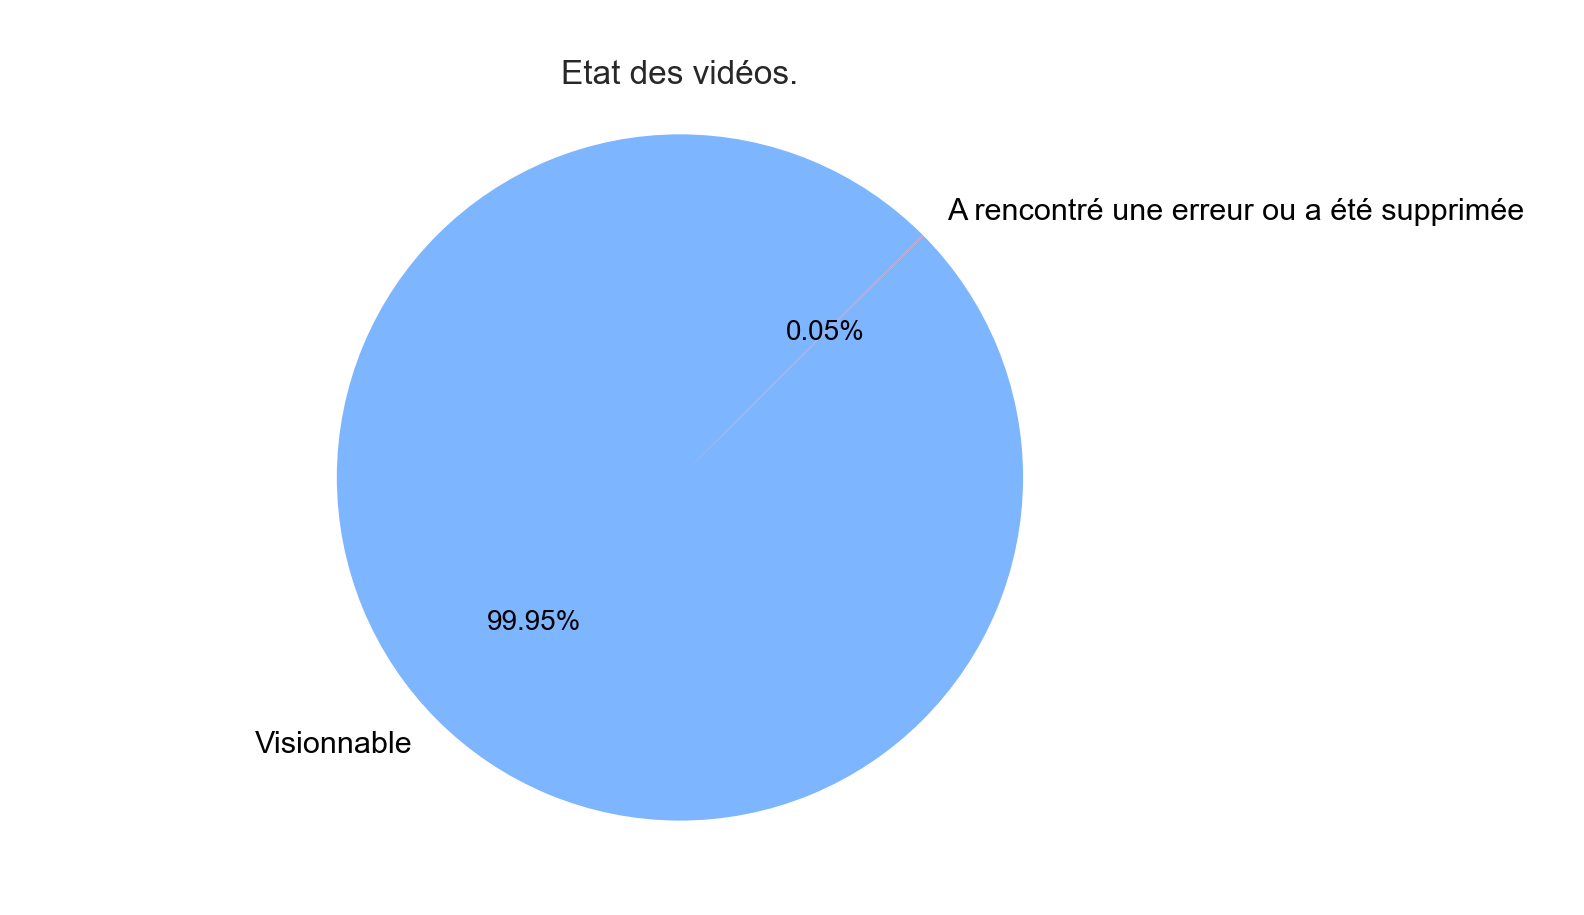

In [75]:
fig, ax = plt.subplots()

value_counts = df["video_error_or_removed"].value_counts().to_dict()

_ = ax.pie([value_counts[False], value_counts[True]],
           labels=['Visionnable', 'A rencontré une erreur ou a été supprimée'],
           colors=['#7db5ff', '#ff7d7d'], textprops={'color': '#040204'}, startangle=45, autopct='%.2f%%')
_ = ax.axis('equal')
_ = ax.set_title('Etat des vidéos.')

In [76]:
df["video_error_or_removed"].value_counts()

False    40702
True        22
Name: video_error_or_removed, dtype: int64

99,95% des vidéos sont visionnables et les 0,05% restant ont rencontré une erreur ou ont été supprimées par les utilisateurs les ayant mises en ligne.

### 3 - Analyse univariée des variables qualitatives

In [77]:
# code used in this part

french_useless_words = stopwords.words('french')
english_useless_words = stopwords.words('english')
arabic_useless_words = stopwords.words('arabic')
turkish_useless_words = stopwords.words('turkish')
useless_chars = ['-', '_', '–', '!', ':', '?', '&', '/', '\\', '|', '>', '<', '!!', '(', ')', '►', 'و']


def get_most_common_words(df_column, top):
    # ??????????????????
    #TODO
    title_words = list(df_column.apply(lambda x: x.split()))
    title_words = [x.lower() for y in title_words for x in y]
    title_words = [word for word in title_words if word
                   not in french_useless_words and word not in arabic_useless_words
                   and word not in turkish_useless_words and word not in english_useless_words
                   and word not in useless_chars]

    cleaned_words = []

    for word in title_words:
        word = word.lower()
        # add only string that does not contains integers
        try:
            int(word)
            pass
        except ValueError:
            cleaned_words.append(word)

    return cleaned_words, Counter(cleaned_words).most_common(top)

#### 3.1 Variable `video_id`

La variable `video_id` est une chaîne de 11 caractères représentant l’identifiant de la vidéo.

In [78]:
df[['video_id']].describe(include=['O'])

video_id
count         40724
unique        30581
top     Rter-Np-Td0
freq              6

Comme on peut le voir sur le tableau ci-dessus, il n’existe que 30581 valeurs uniques pour 40724 individus, ce qui peut paraître étrange car l’identifiant d’une vidéo est censé être unique.

En réalité, le dataset contient des données hebdomadaires concernant les vidéos en tendance. La même vidéo peut donc apparaître en tendance plusieurs jours et apparaître plusieurs fois dans le dataset. Cela veut aussi dire qu’il y a 30581 vidéos qui ne sont apparues qu’un seul jour en tendance, soit 75% de l’échantillon.

Par exemple, si l’on récupère les individus pour lesquels la variable `video_id` vaut Rter-Np-Td0, on obtient bien six vidéos comme indiqué dans le tableau par la colonne freq.

In [79]:
df.loc[df['video_id'] == 'Rter-Np-Td0']

video_id trending_date  \
22532  Rter-Np-Td0      18.09.03   
22726  Rter-Np-Td0      18.10.03   
22928  Rter-Np-Td0      18.11.03   
23140  Rter-Np-Td0      18.12.03   
23345  Rter-Np-Td0      18.13.03   
23541  Rter-Np-Td0      18.14.03   

                                                   title channel_title  \
22532  Maître Gims - Loup Garou ft. Sofiane (Clip Off...   Maître GIMS   
22726  Maître Gims - Loup Garou ft. Sofiane (Clip Off...   Maître GIMS   
22928  Maître Gims - Loup Garou ft. Sofiane (Clip Off...   Maître GIMS   
23140  Maître Gims - Loup Garou ft. Sofiane (Clip Off...   Maître GIMS   
23345  Maître Gims - Loup Garou ft. Sofiane (Clip Off...   Maître GIMS   
23541  Maître Gims - Loup Garou ft. Sofiane (Clip Off...   Maître GIMS   

       category_id              publish_time  \
22532           10  2018-03-08T21:50:49.000Z   
22726           10  2018-03-08T21:50:49.000Z   
22928           10  2018-03-08T21:50:49.000Z   
23140           10  2018-03-08T21:50:49.000Z   
23345           10  2018-03-08T21:50:49.000Z   
23541           10  2018-03-08T21:50:49.000Z   

                                                    tags    views   likes  \
22532  maitre gims"|"sofiane"|"fianso"|"loup garou"|"...   470451   44380   
22726  maitre gims"|"sofiane"|"fianso"|"loup garou"|"...  2452760  124638   
22928  maitre gims"|"sofiane"|"fianso"|"loup garou"|"...  3789300  154610   
23140  maitre gims"|"sofiane"|"fianso"|"loup garou"|"...  4765146  171434   
23345  maitre gims"|"sofiane"|"fianso"|"loup garou"|"...  5587208  183766   
23541  maitre gims"|"sofiane"|"fianso"|"loup garou"|"...  6437938  193433   

       dislikes  comment_count  \
22532      1332           3337   
22726      5090           8462   
22928      6795          10484   
23140      7831          11661   
23345      8572          12333   
23541      9181          13065   

                                       thumbnail_link  comments_disabled  \
22532  https://i.ytimg.com/vi/Rter-Np-Td0/default.jpg              False   
22726  https://i.ytimg.com/vi/Rter-Np-Td0/default.jpg              False   
22928  https://i.ytimg.com/vi/Rter-Np-Td0/default.jpg              False   
23140  https://i.ytimg.com/vi/Rter-Np-Td0/default.jpg              False   
23345  https://i.ytimg.com/vi/Rter-Np-Td0/default.jpg              False   
23541  https://i.ytimg.com/vi/Rter-Np-Td0/default.jpg              False   

       ratings_disabled  video_error_or_removed  \
22532             False                   False   
22726             False                   False   
22928             False                   False   
23140             False                   False   
23345             False                   False   
23541             False                   False   

                                             description  
22532  Extrait du Nouvel Album « CEINTURE NOIRE »\nEn...  
22726  Extrait du Nouvel Album « CEINTURE NOIRE »\nEn...  
22928  Extrait du Nouvel Album « CEINTURE NOIRE »\nEn...  
23140  Extrait du Nouvel Album « CEINTURE NOIRE »\nEn...  
23345  Extrait du Nouvel Album « CEINTURE NOIRE »\nEn...  
23541  Extrait du Nouvel Album « CEINTURE NOIRE »\nEn...

On remarque que cette vidéo est apparue en tendances pour une durée de six jours, du 09/03/2018 au 14/03/2018. C’est la vidéo qui est restée le plus de jours en tendance.

#### 3.2 Variable `thumbnail_link`

La variable `thumbnail_link` est une chaîne de caractères représentant un lien hypertexte vers la miniature de la vidéo. La miniature d'une vidéo est l’image qui est visible avant de cliquer sur une vidéo pour la visionner. On retrouve dans ce lien l’identifiant de la vidéo à laquelle appartient cette miniature.

In [81]:
df['thumbnail_link'].describe()

count                                              40724
unique                                             30572
top       https://i.ytimg.com/vi/Rter-Np-Td0/default.jpg
freq                                                   6
Name: thumbnail_link, dtype: object

On remarque que l’identifiant du lien le plus fréquent (Rter-Np-Td0) est l’identifiant de vidéo le plus fréquent (cf. III, 3.1). C’est normal car la vidéo correspondant à cet identifiant est apparue six jours dans les tendances, ce qui explique pourquoi les valeurs de son identifiant et du lien vers sa miniature sont les plus fréquents et apparaissent six fois.

In [82]:
df['thumbnail_link_len'] = df["thumbnail_link"].apply(lambda x: len(x))
df['thumbnail_link_len'].describe()

count   40724.00
mean       46.01
std         0.19
min        46.00
25%        46.00
50%        46.00
75%        46.00
max        51.00
Name: thumbnail_link_len, dtype: float64

De plus, il existe deux catégories de liens :
- le lien de la forme https://i.ytimg.com/vi/{video_id}/default.jpg (46 caractères), utilisé pour les vidéos normales,
- le lien de la forme https://i.ytimg.com/vi/{video_id}/default_live.jpg (51 caractères), utilisé pour les diffusions en direct).
{video_id} correspond à l’identifiant d’une vidéo, composé de 11 caractères.

Ces types de liens nous informent que des diffusions en direct peuvent apparaître dans l’onglet tendances et nous permettent de déterminer leur répartition parmi les vidéos traditionnelles.

In [84]:
def is_live(c):
    if c['thumbnail_link_len'] == 51:
        return True
    else:
        return False


df['is_live'] = df.apply(is_live, axis=1)
df['is_live'].describe()

count     40724
unique        2
top       False
freq      40668
Name: is_live, dtype: object

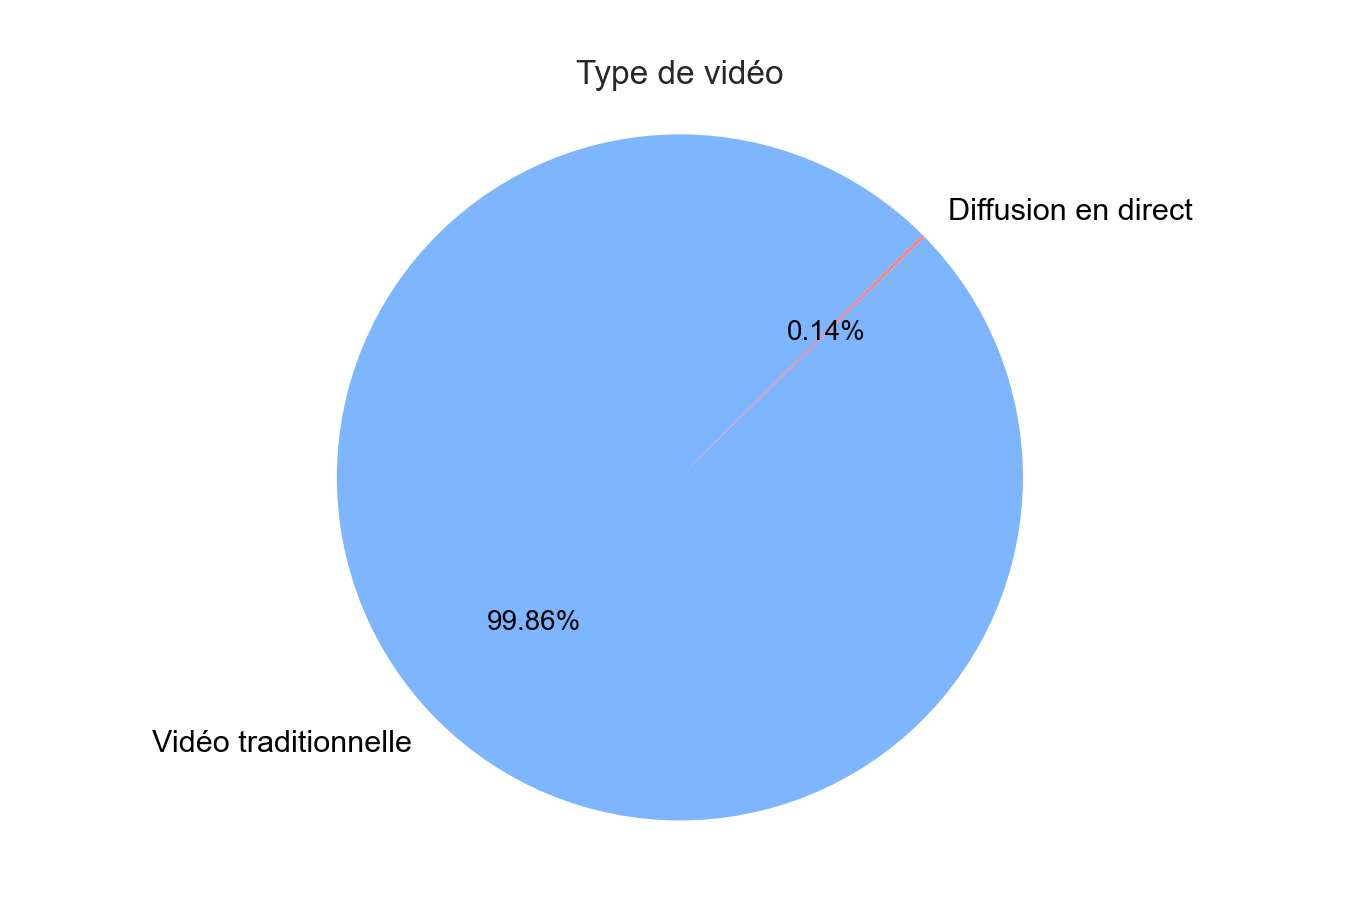

In [85]:
fig, ax = plt.subplots()

value_counts = df["is_live"].value_counts().to_dict()

_ = ax.pie([value_counts[False], value_counts[True]], labels=['Vidéo traditionnelle', 'Diffusion en direct'],
           colors=['#7db5ff', '#ff7d7d'], textprops={'color': '#040204'}, startangle=45, autopct='%.2f%%')
_ = ax.axis('equal')
_ = ax.set_title('Type de vidéo')

99,86% des vidéos sont des vidéos traditionnelles et les 0,14% restant sont des lives (diffusions en direct).

#### 3.3 Variable `title`

La variable `title` est une chaîne de caractères représentant le titre de la vidéo. Il est choisi par l’utilisateur lors de la mise en ligne de la vidéo et est obligatoire. La taille du titre doit être comprise entre 3 et 100 caractères.


In [87]:
df['title'].describe()

count     40724
unique    30544
top         J+1
freq         27
Name: title, dtype: object

Une pratique assez répandue sur la plateforme est d’écrire la totalité du titre de sa vidéo en majuscule. Le but de cette pratique est d’attirer l’attention de l’utilisateur afin qu’il clique sur la vidéo en question.

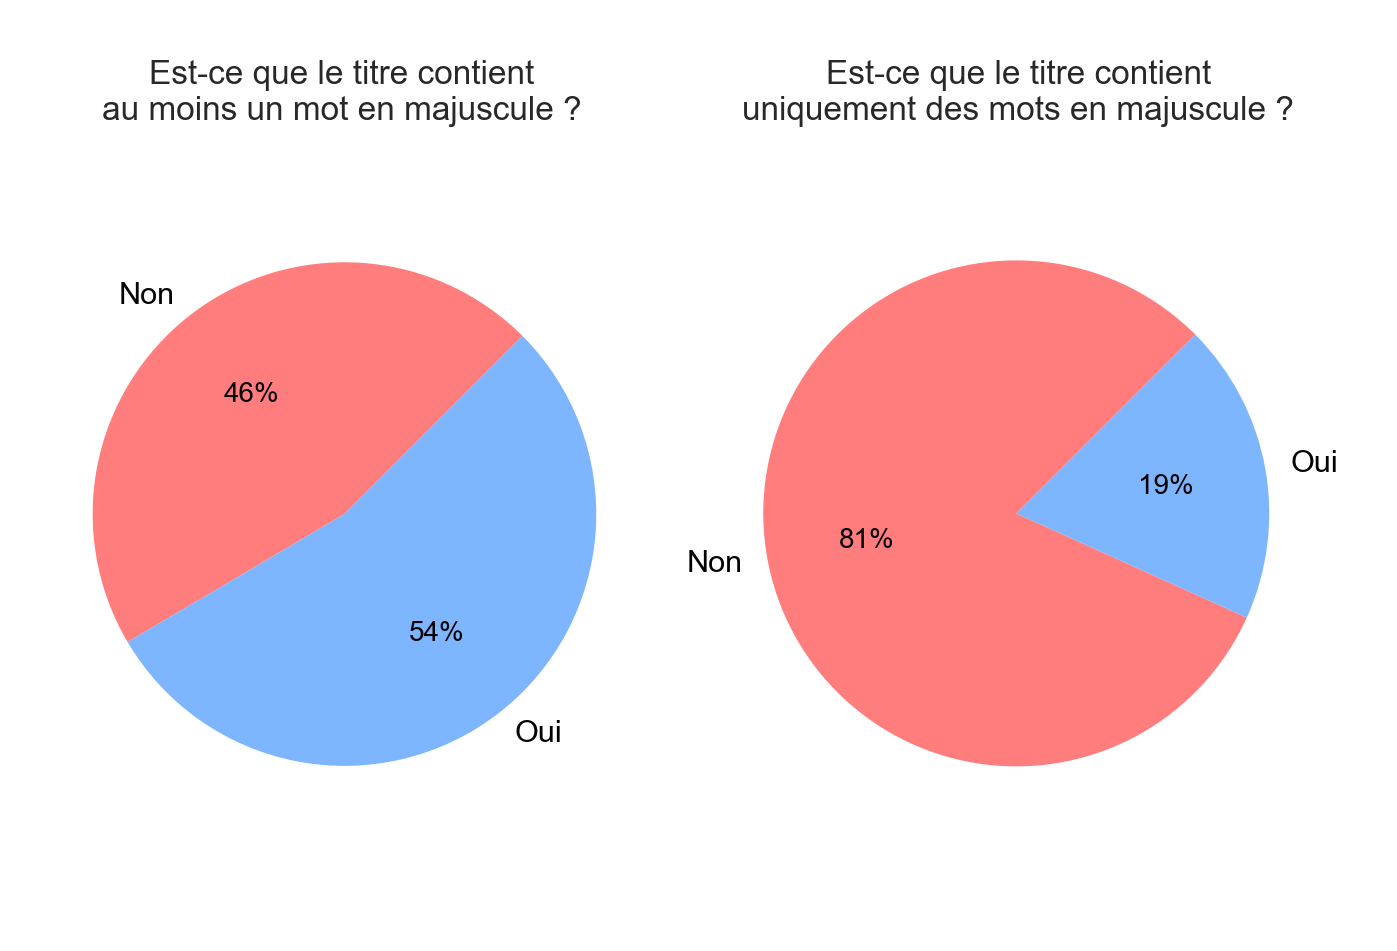

In [88]:
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False


fig, (ax1, ax2) = plt.subplots(1, 2)

df["contains_capitalized"] = df["title"].apply(contains_capitalized_word)
value_counts = df["contains_capitalized"].value_counts().to_dict()

ax1.pie([value_counts[False], value_counts[True]], labels=['Non', 'Oui'],
        colors=['#ff7d7d', '#7db5ff'], textprops={'color': '#040204'}, startangle=45, autopct='%1.0f%%')
ax1.axis('equal')
ax1.set_title('Est-ce que le titre contient\nau moins un mot en majuscule ?')

df["full_capitalized"] = df["title"].apply(lambda x: x.isupper())
value_counts = df["full_capitalized"].value_counts().to_dict()

ax2.pie([value_counts[False], value_counts[True]], labels=['Non', 'Oui'],
        colors=['#ff7d7d', '#7db5ff'], textprops={'color': '#040204'}, startangle=45, autopct='%1.0f%%')
ax2.axis('equal')
ax2.set_title('Est-ce que le titre contient\nuniquement des mots en majuscule ?')

plt.show()

Comme le montre le graphique circulaire ci-dessus, 54% des vidéos en tendances contiennent au minimum un mot en majuscule et 19% contiennent uniquement des mots en majuscule. Un nombre non négligeable de vidéos dont le titre est totalement en majuscule a donc fait partie des tendances.

Cependant, on ne peut pas réellement savoir si un titre contenant uniquement des majuscules joue un rôle dans le fait qu’une vidéo apparaisse dans l’onglet des tendances. En effet, nous ne connaissons le pourcentage de vidéos avec un titre écrit uniquement en majuscule en dehors de l’onglet des tendances.

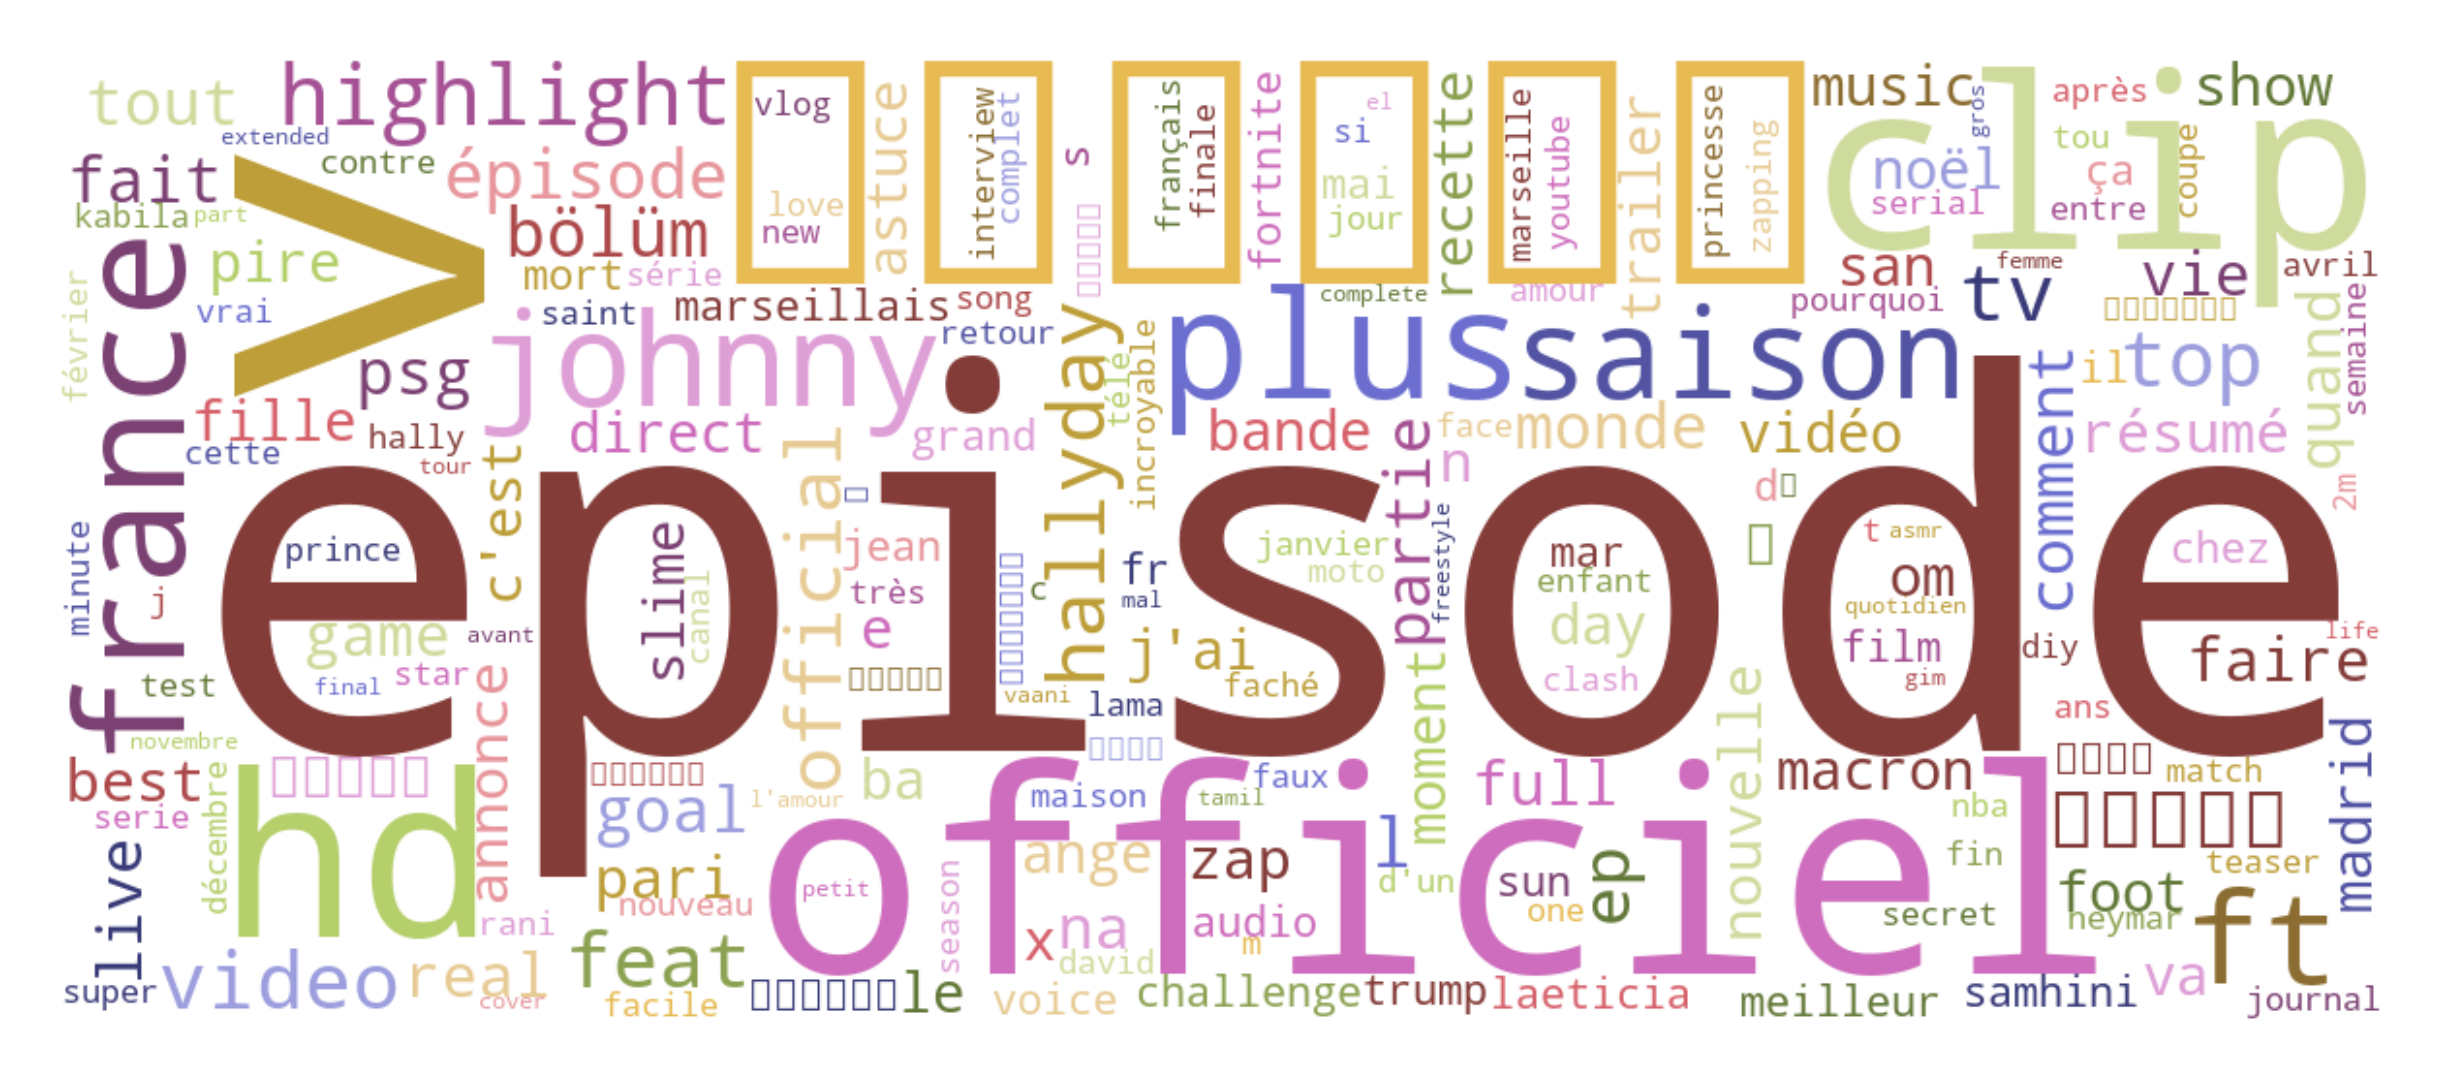

In [89]:
# https://github.com/amueller/word_cloud/pull/315#issuecomment-629081214
title_words, title_count = get_most_common_words(df['title'], 25)

wc = wordcloud.WordCloud(width=1200, height=500,
                         collocations=False, background_color="white",
                         colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

In [90]:
for name, freq in title_count:
    print(f'`{name}` : {freq} occurrences')

`episode` : 2236 occurrences
`vs` : 1622 occurrences
`الحلقة` : 1110 occurrences
`plus` : 827 occurrences
`johnny` : 748 occurrences
`saison` : 719 occurrences
`highlights` : 716 occurrences
`france` : 683 occurrences
`hd` : 672 occurrences
`officiel)` : 669 occurrences
`(clip` : 654 occurrences
`مسلسل` : 635 occurrences
`tv` : 610 occurrences
`top` : 593 occurrences
`hallyday` : 581 occurrences
`épisode` : 530 occurrences
`ft.` : 492 occurrences
`tout` : 461 occurrences
`comment` : 460 occurrences
`monde` : 454 occurrences
`bölüm` : 453 occurrences
`fait` : 444 occurrences
`goals` : 426 occurrences
`partie` : 419 occurrences
`faire` : 407 occurrences


Sur le nuage de mots ci-dessus, on peut voir tous les mots les plus fréquents dans les titres de vidéos. Un mot est d’autant plus grand qu’il est fréquent. Grâce à ce nuage de mots, nous pouvons déterminer les thèmes les plus populaires dans les tendances françaises en repérant les champs lexicaux présents. ▯ correspond à des caractères arabes non supportés par le nuage de points mais nous avons quand même pris en compte ces mots lors de la détermination des thématiques.

Dans le tableau ci-dessous ont été recensés manuellement les thèmes ainsi que le champ lexical relevé dans le nuage de mots. Les thèmes sont triés du plus au moins important en fonction de la fréquence des mots constituant leur champ lexical. Cela permet d’avoir une idée sur les thématiques les plus répandues au sein des tendances Youtube en France.


| Thème     | Mots clés |
|----------------|------------------------------------------------------------------------------------------------------------------|
| Télévision     | episode, serie (apparaît aussi en turc et en arabe), tv, hd, saison, télé, zap, bölüm (épisode en turc), zapping |
| Musique        | (clip, officiel), music, ft., feat, audio, extended, official                                                    |
| Football       | highlights, goal, madrid, psg, match, real, foot, coupe                                                          |
| Actualités     | france, johnny, hallyday, laeticia, macron, interview, trump                                                     |
| Divertissement | plus, fortnite, challenge, vlog                                                                                  |
| Films          | bande, annonce, film                                                                                             |

Le tri des thèmes a été réalisé manuellement en se basant sur le nuage de mots. Pour aller plus loin, un Topic Modeling (Modélisation des Sujets) aurait pu être réalisé afin de déterminer automatiquement les sujets les plus répandus.

In [91]:
df["title_length"] = df["title"].apply(lambda x: len(x))
df["title_length"].describe()

count   40724.00
mean       53.72
std        21.66
min         3.00
25%        37.00
50%        51.00
75%        69.00
max       100.00
Name: title_length, dtype: float64

Text(0.5, 1.0, 'Distribution de la taille des titres (entre 0 et 100).\n')

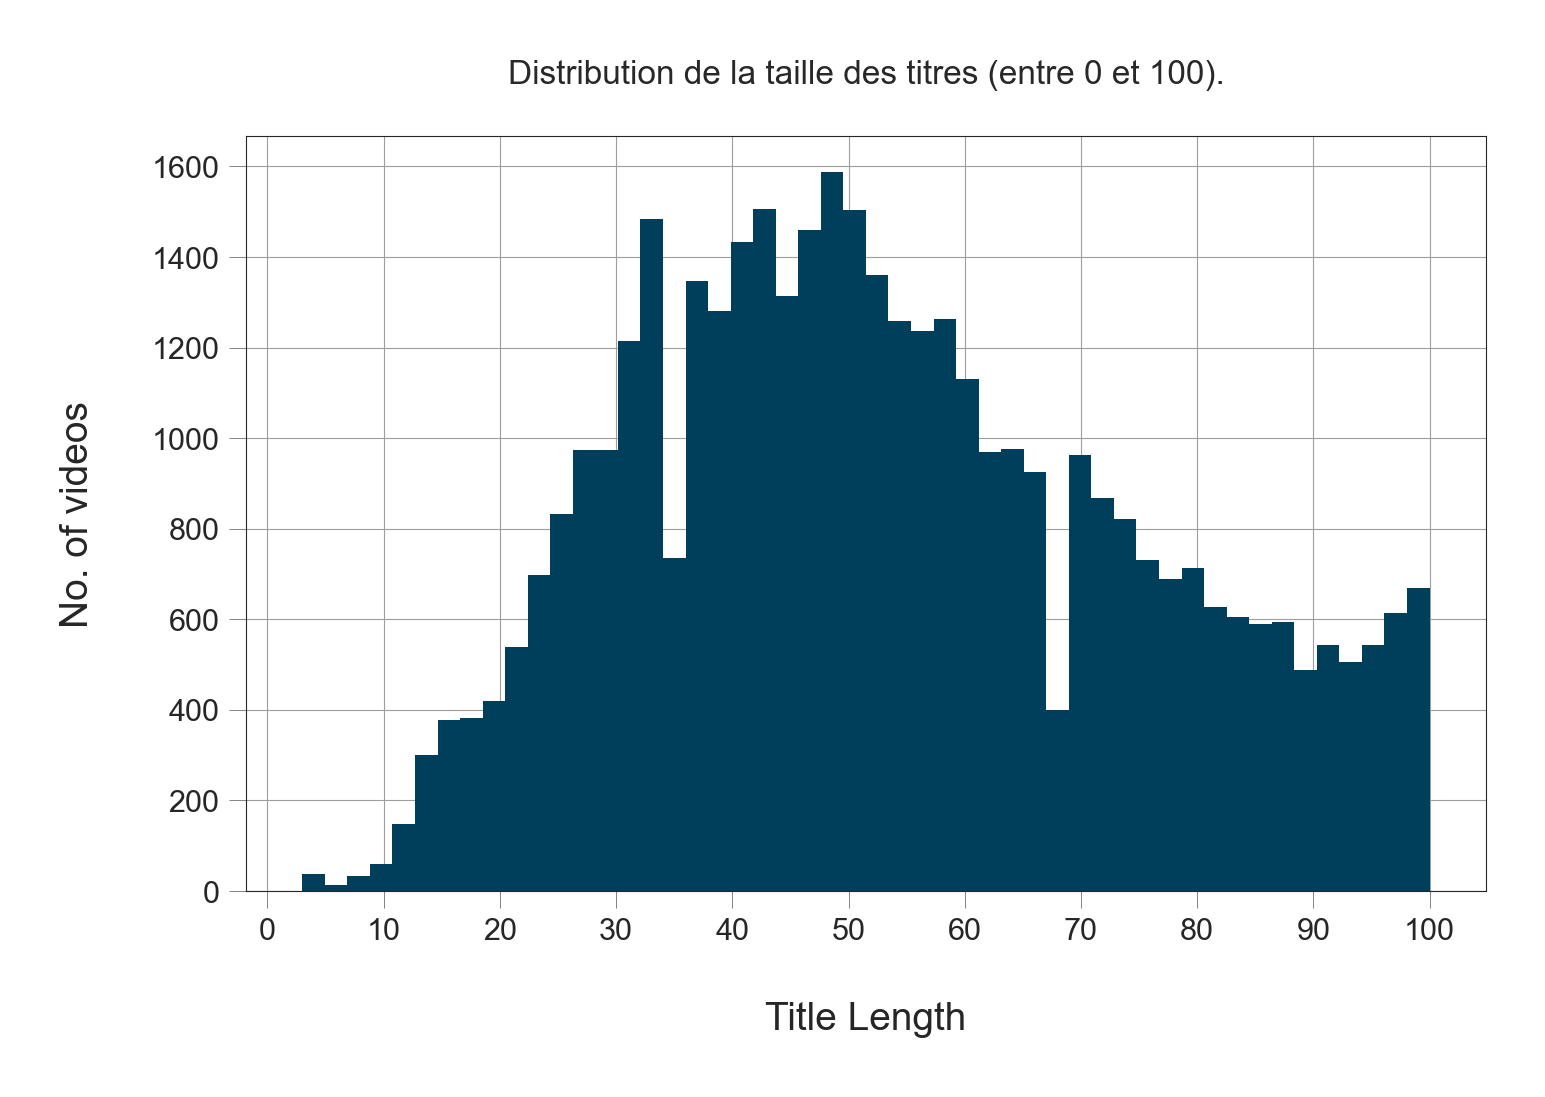

In [92]:
fig, ax = plt.subplots()
_ = sns.distplot(df["title_length"], kde=False, rug=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, 110, 10))
plt.title('Distribution de la taille des titres (entre 0 et 100).\n')

#### 3.4 Variable `description`

La variable `description` est une chaîne de caractères représentant la description de la vidéo. Elle est choisie par l’utilisateur lors de la mise en ligne de la vidéo et sa taille doit être inférieure ou égale à 5000 caractères.

La variable `description` est égale à NaN pour 2912 individus (7% de l'échantillon). Ceci s’explique par le fait que le champ description n’est pas obligatoire pour la publication d’une vidéo. Ce n’est donc pas à proprement parler des données manquantes, car une vidéo qui n’a pas de description est une vidéo dont la description est une chaîne de caractères vide.


In [ ]:
df["description"] = df["description"].fillna(value="")
df['description'] = df['description'].replace(r'\\n', '', regex=True)

desc_words, desc_count = get_most_common_words(df['description'], 25)

# TODO: n is \n that is not striped. 
wc = wordcloud.WordCloud(width=1200, height=500,
                         collocations=False, background_color="white",
                         colormap="tab20b").generate(" ".join(desc_words))
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

In [ ]:
desc_count

D’après le nuage de mots ci-dessus, on remarque que des URLs sont fréquemment présentes dans les descriptions. En effet, le mot le plus fréquent est https et on retrouve plusieurs mots clés en rapport avec des raccourcisseurs d’URLs. Ces mots clés sont goo et gl (= goo.gl), bit et ly (= bit.ly) et smarturl et font référence aux noms de domaines des raccourcisseurs d’URLs utilisés.

Mais pourquoi les chaînes souhaitent raccourcir les URLs qu’elles publient en description ? Ces liens permettent de masquer des liens affiliés ou publicitaires (souvent très longs), d'analyser le nombre d’internautes qui vont cliquer dessus et aussi de rendre les descriptions plus faciles et rapides à lire.

Ces liens dans la description permettent :
d’inciter l’utilisateur ayant cliqué sur la vidéo à s’abonner à la chaîne. En effet, on retrouve les mots clés channel, user et sub_confirmation, présents dans ce type de lien,
de proposer aux utilisateurs d’autres vidéos et playlists (mots clés watch, list et playlist présents de ce type de lien),
de rediriger les utilisateurs vers les réseaux sociaux de la chaîne (mots clés facebook, twitter, instagram, snapchat, follow) ainsi que d’autres plateformes (twitch, soundcloud),
de donner d’autres informations : recommandation de produits (amzn), contact (gmail, question), financement participatif (tipee).

On retrouve également des remerciements envers les personnes ayant cliqué et visionné la vidéo.

#### 3.5 Variable `trending_date`

La variable `trending_date` est une chaîne de caractères représentant la date à laquelle la vidéo est apparue dans les tendances. La chaîne de caractères représente une date au format AA.jj.mm avec AA l’année sur 2 chiffres, jj le jour sur deux chiffres et mm le mois sur deux chiffres.


In [ ]:
df["trending_date"].describe()

On peut voir qu’il existe 205 valeurs uniques, ce qui veut donc dire que le dataset contient les données de 205 journées (plus de six mois). De plus, on peut voir que 200 vidéos sont apparues dans l’onglet tendance le 13 décembre 2017.

In [ ]:
cdf = df["trending_date"].apply(lambda x: '20' + x[:2]).value_counts().to_frame().reset_index().rename(
    columns={"index": "year", "trending_date": "No_of_videos"})

fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=cdf,
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Année d'apparition en tendance", ylabel="Nombre de vidéos")
_ = ax.set_title('Diagramme à barres de l\'année d\'apparition des vidéos en tendance\n')

In [ ]:
fig, ax = plt.subplots()

value_counts = df["trending_date"].apply(lambda x: '20' + x[:2]).value_counts().to_dict()

_ = ax.pie([value_counts['2018'], value_counts['2017']], labels=['2018', '2017'],
           colors=['#7db5ff', '#ff7d7d'], textprops={'color': '#040204'}, startangle=45, autopct='%.1f%%')
_ = ax.axis('equal')
_ = ax.set_title('Année d\'apparition des vidéos en tendance.')

On peut voir que 76,4% des vidéos du dataset sont apparues en tendance en 2018 et 23,6 % en 2017.

#### 3.6 Variable `channel_title`

La variable `channel_title` est une chaîne de caractères représentant le nom de la chaîne Youtube qui a mis en ligne la vidéo. Le nom de la chaîne doit être inférieur ou égal à 60 caractères.


In [ ]:
cdf = df.groupby("channel_title").size().reset_index(name="video_count").sort_values("video_count",
                                                                                     ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8, 8))
_ = sns.barplot(x="video_count", y="channel_title", data=cdf,
                palette=sns.cubehelix_palette(n_colors=20, reverse=True), ax=ax)
_ = ax.set(xlabel="Nombre de vidéos", ylabel="Chaîne")
plt.title("Diagramme à barres des chaînes avec le plus de vidéos en tendances.\n")

D’après le diagramme à barres ci-dessus, on peut regrouper les 20 chaînes ayant le plus de vidéos en tendances selon la catégorie de leur contenu, ce qui donne le tableau ci-dessous :


| Catégorie                | Chaînes                                                                                                                                                                                                              |
|--------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Entertainment (11)       | Lama Faché, Topito, WatchMojo Français, Elhiwar Ettounsi (Tunisie), Marodi TV Sénégal, VikatanTV (Inde), Touche pas à mon poste !, RadaanMedia (Inde), THIRU TV (Inde), Attessia TV (Tunisie), okay.africa (Sénégal) |
| Film & Animation (2)     | Çukur (Turquie), Un gars une fille \| Officiel                                                                                                                                                                       |
| News & Politics (2)      | France Inter, NDEKO ELIEZER TOKOKOMA                                                                                                                                                                                 |
| How to & Style (2)       | Troom Troom FR, BRICO SYMPA                                                                                                                                                                                          |
| Comedy (1)               | Lolywood                                                                                                                                                                                                             |
| Science & Technology (1) | Dr Nozman                                                                                                                                                                                                            |
| People & Blogs (1)       | sam zirah                                                                                                                                                                                                            |


On remarque qu’une très grande partie des chaînes appartiennent à la catégorie divertissement. Parmi les chaînes appartenant à cette catégorie, on remarque que la plupart sont des chaînes de télévision étrangères (Elhiwar Ettounsi, Marodi TV Sénégal, RadaanMedia, THIRU TV, Attessia TV, okay.africa).

3.7 Variable `publish_time`

La variable `publish_time` est une chaîne de caractères représentant la date de publication de la vidéo. La chaîne de caractères représente une date au format AAAA-mm-jjThh:mi:ss.nZ avec la date composée de : AAAA l’année sur 4 chiffres, jj le jour sur deux chiffres, mm le mois sur deux chiffres, puis l'heure de la journée qui débute par la lettre T, composée de : hh l’heure du jour sur 2 chiffres, mi la minute sur deux chiffres, ss la seconde sur deux chiffres, n la fraction de seconde sur un ou plusieurs chiffres. Cette date est au format ISO 8601 et la lettre Z à la fin indique qu’il s’agit de l’heure UTC.

In [ ]:
df["publishing_day"] = df["publish_time"].apply(
    lambda x: datetime.datetime.strptime(x[:10], "%Y-%m-%d").date().strftime('%a'))
df["publishing_hour"] = df["publish_time"].apply(lambda x: x[11:13])

In [ ]:
cdf = df["publishing_day"].value_counts().to_frame().reset_index().rename(
    columns={"index": "publishing_day", "publishing_day": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="publishing_day", y="No_of_videos", data=cdf,
                palette=sns.color_palette(['#003f5c', '#374c80', '#7a5195',
                                           '#bc5090', '#ef5675', '#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Jour de publication", ylabel="Nombre de vidéos")
plt.title('Diagramme à barres représentatnt la répartition de la publication des vidéos sur les jours de la semaine.\n')

D’après le diagramme ci-dessus, on peut voir que la majorité des vidéos en tendance ont été mises en ligne un vendredi. On pourrait expliquer ceci par le fait que les vidéos mises en ligne un vendredi bénéficient du week-end pour générer plus d’interactions grâce à un plus grand nombre d’utilisateurs actifs sur la plateforme. A l’opposé, le dimanche donne moins de visibilité aux vidéos car une semaine est sur le point de commencer. Les utilisateurs sont donc moins actifs et les vidéos ont moins de chance d’arriver en tendances.

In [ ]:
cdf = df["publishing_hour"].value_counts().to_frame().reset_index().rename(
    columns={"index": "publishing_hour", "publishing_hour": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="publishing_hour", y="No_of_videos", data=cdf,
                palette=sns.cubehelix_palette(n_colors=24), ax=ax)
_ = ax.set(xlabel="Heure de publication", ylabel="Nombre de vidéos")
plt.title('Histogramme représentant la répartition de la publication des vidéos sur les heures de la journée.\n')

Grâce à l’histogramme ci-dessus, on remarque que la plupart des vidéos qui apparaissent en tendances sont majoritairement postées entre 16h et 17h et plus généralement du début d'après-midi jusqu’en soirée (entre 14h et 21h). Pareil que pour le jour de publication, on peut expliquer ceci par le fait que plus d'utilisateurs sont actifs à ces horaires (fin des cours et du travail), ce qui permet donc aux vidéos de générer un plus grand nombre d’interactions.

#### 3.8 Variable `tags`

La variable `tags` est une chaîne de caractères représentant l’ensemble des tags de la vidéo, concaténés par le caractère spécial | (tube). Un tag est un mot clé descriptif qui aide au référencement de la vidéo. Ils sont renseignés par l’utilisateur lors de la publication d’une vidéo et ne sont pas obligatoires, ce qui explique que la variable `tags` est égale à [none] pour 5304 individus (13%).

In [ ]:
desc_words, desc_count = get_most_common_words(df['tags'], 25)

# TODO: n is \n that is not striped.
wc = wordcloud.WordCloud(width=1200, height=500,
                         collocations=False, background_color="white",
                         colormap="tab20b").generate(" ".join(desc_words))
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

D’après le nuage de mots ci-dessus, on remarque que les tags font souvent référence à la télévision (tv, episode, film, show, star, télé, télévision, interview, replay), au divertissement (challenge, slime, funny, divertissement, prank), au football (game, football, madrid, ronaldo, real, psg, highlight, fifa, nba, neymar, ligue), à la politique et aux actualités (macron, actualité, johnny, actu, laeticia), à la musique et à la radio (rap, booba, music, cover, voice, nrj, rtl, freestyle). Ces observations confirment celles réalisées en étudiant la variable `title` (cf. III, 3.3) concernant les thématiques les plus répandues au sein des vidéos françaises en tendance.

#### 3.9 Variable `category_id`

La variable `category_id` est un nombre entier représentant l’identifiant de la catégorie de la vidéo. Il prend par défaut la valeur 22, qui correspond à la catégorie People & Blogs. Puisque ces identifiants diffèrent d’un pays à un autre, un fichier JSON contenant les noms des catégories est fourni avec le dataset de chaque pays.


In [ ]:
with open(JSON_CATEGORIES_PATH) as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
df['category_name'] = df['category_id'].map(cat_dict)

In [ ]:
cdf = df["category_name"].value_counts().to_frame().reset_index()
cdf.rename(columns={"index": "category_name", "category_name": "No_of_videos"}, inplace=True)
fig, ax = plt.subplots()
_ = sns.barplot(x="category_name", y="No_of_videos", data=cdf,
                palette=sns.cubehelix_palette(n_colors=16, reverse=True), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="Catégorie", ylabel="Nombre de vidéos")
plt.title('Diagramme à barres des catégories les plus représentées dans les tendances.\n')

Les catégories les plus populaires correspondent aux thématiques récurrentes observées en analysant les variables `title` et `tags`. On remarque également que la catégorie la plus représentée est `Entertainment`, ce qui est normal car cette catégorie est assez large en termes de contenu comparé aux autres.

## IV - Analyse bivariée des données

### 1 - Formules utilisées

#### 1.1 Covariance

La covariance de deux variables aléatoires réelles X et Y ayant chacune une variance (finie), notée $Cov(X, Y)$ ou parfois $σ_{XY}$, est la valeur : 

$$\large Cov(X, Y) = E[ ( X - E(X) ) -( Y - E(Y) )]$$

#### 1.2 Variance 

La variance est une mesure de la dispersion des valeurs d'un échantillon ou d'une distribution de probabilité.
La variance d’une variable aléatoire réelle $X = ( x1,x2,...,xn)$ dont on a calculé la moyenne $\bar{X}$ est définie par la formule suivante:

$$\large Var(x) = \frac{1}{n} \sum \limits_{i=1}^{n}(x_i- \bar {X})^2$$

### 2 - Analyse bivariée

#### 2.1 Analyse de la corrélation avec la covariance

Pour obtenir la covariance entre deux variables nous avons utilisé la matrice de variance/ covariance générée par la méthode `cov` de la class Dataframe de la bibliothèque pandas.

Une matrice de variance/covariance est une matrice carrée qui comporte les variances et les covariances associées à plusieurs variables. Les éléments de diagonale de la matrice contiennent les variances des variables, tandis que les éléments hors diagonale contiennent les covariances entre toutes les paires possibles de variables.

Lorsqu'elle est réduite, elle est égale à la matrice des corrélations et devient davantage opérationnelle. Cette matrice intervient dans plusieurs méthodes d'analyse multivariée comme l'ACP. que nous verrons dans la partie sur l’analyse multivariée (cf. V).

A partir de cette matrice, on obtient les coefficients de corrélation linéaires simples entre chaque variable avec la formule suivante:

$$\large r = \frac{Cov(X,Y)}{\sqrt{V(x)V(y)}} $$

Voici les valeurs obtenues des coefficients de corrélation pour les paires de variables (likes,comment_count), (views,likes), (views, comment_count), (dislikes, comment_count) en appliquant la formule ci-dessus :
`likes` et `comment_count`: 0,85
`views` et `likes`:  0,81
`views` et `comments_count` : 0,71
`dislikes` et `comments_count` : 0,66
`views` et `dislikes` : 0,59
`comments_disabled` et `ratings_disabled` : 0,48
`likes` et `dislikes` : 0,45

Pour une meilleure visualisation à la fois du coefficient de corrélation et de la relation entre les variables nous avons réalisé des nuages de points. Sur ces derniers, la droite en rouge représente la droite de corrélation.


In [94]:

sns.set_theme(color_codes=True)


# log(n+1) transformation
def log_transform(df, col1: str, col2: str):
    df_copy = df.copy()
    df_copy[col1] = np.log(df_copy[col1] + 1)
    df_copy[col2] = np.log(df_copy[col2] + 1)
    return df_copy


def plot_relation(df1, df2, x, y, title):
    fig, axs = plt.subplots(ncols=2)
    fig.suptitle(title)
    sns.regplot(x=x, y=y, data=df1, ax=axs[0], line_kws={"color": "red"})
    sns.regplot(x=x, y=y, data=df2, ax=axs[1], line_kws={"color": "red"})
    plt.tight_layout()
    fig.show()

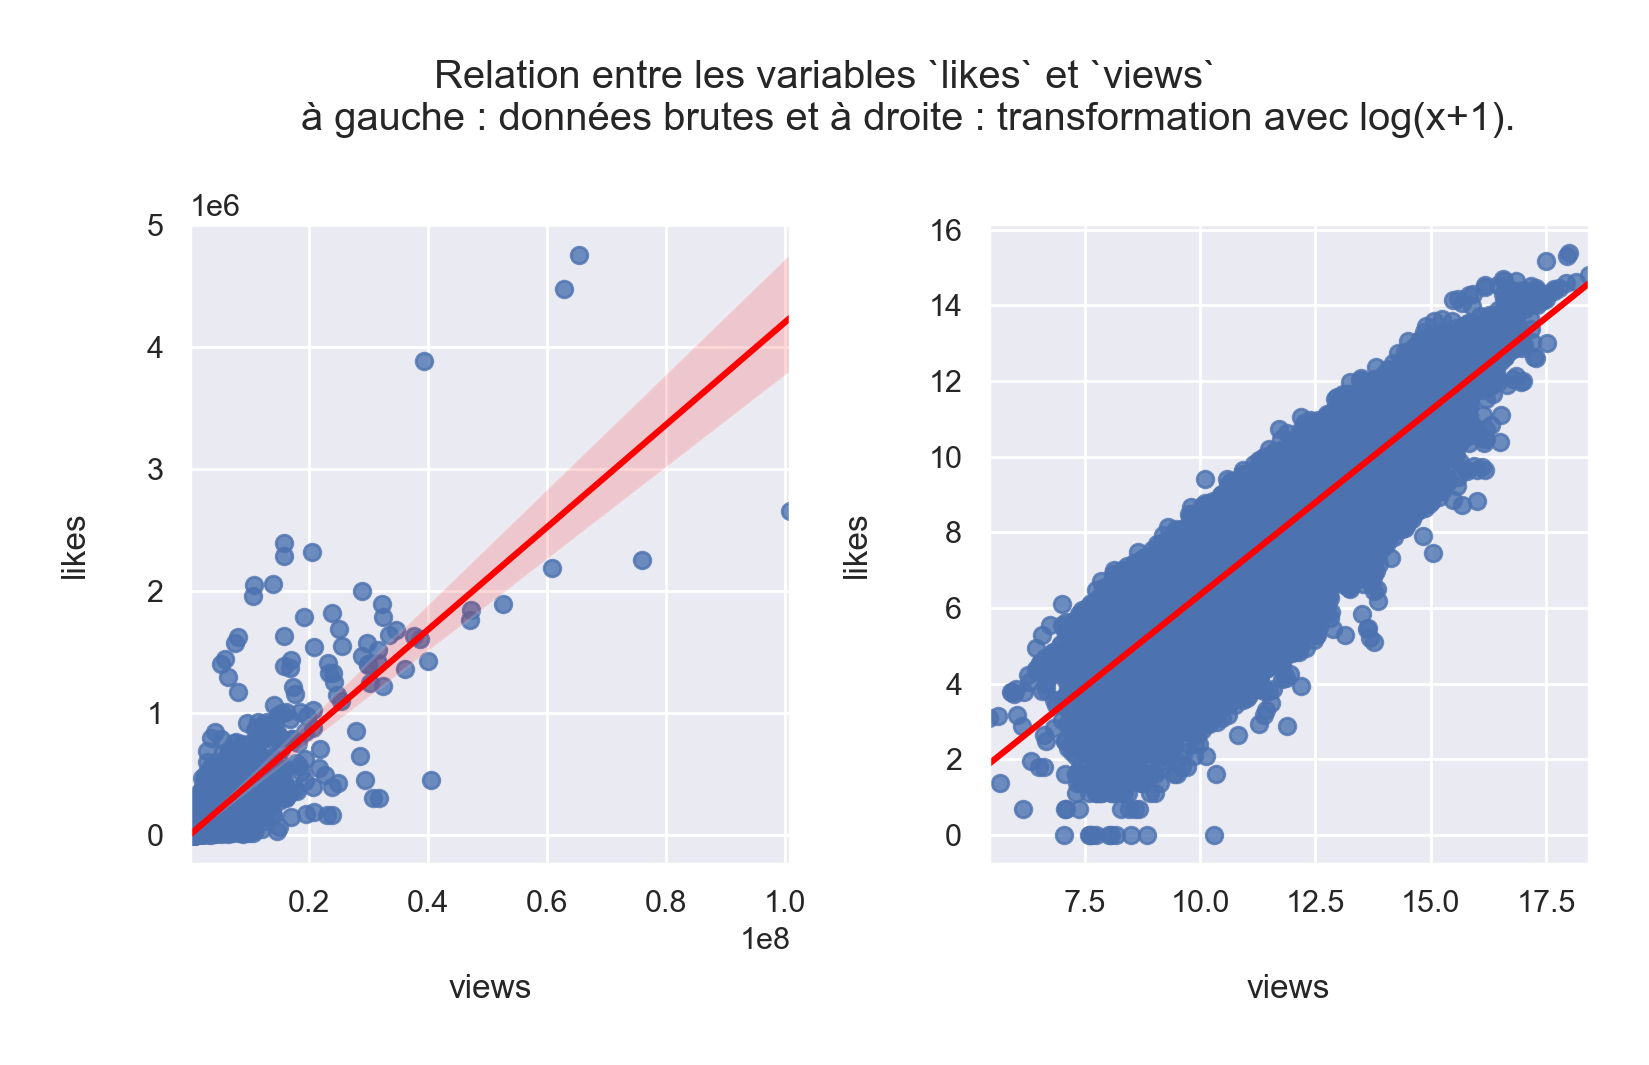

In [95]:
# keep only videos with rating enabled
df_ratings_enabled = df.loc[df['ratings_disabled'] == False]
# apply a log transformation
df_ratings_enabled_log = log_transform(df_ratings_enabled, 'views', 'likes')

plot_relation(df_ratings_enabled[['views', 'likes']], df_ratings_enabled_log[['views', 'likes']],
              'views', 'likes', 'Relation entre les variables `likes` et `views`\n \
              à gauche : données brutes et à droite : transformation avec log(x+1).')

Pour réaliser les nuages de points ci-dessus, nous avons uniquement conservé les individus ayant les notations activées (variable `ratings_disabled` égale à False). En effet, pour les individus n’ayant pas les notations activées, la variable `like` est égale à 0 ce qui aurait faussé la relation entre les deux variables.

Pour avoir une meilleure vision de la relation entre les variables `likes` et `views`, nous avons transformé ces variables en y appliquant la transformation logarithmique ‘log(x + 1)’ pour obtenir le nuage de points de droite.

Nous observons à droite que la droite de corrélation est centrée dans le nuage de points, ce qui correspond à une corrélation assez forte entre les deux variables (r = 0.85).

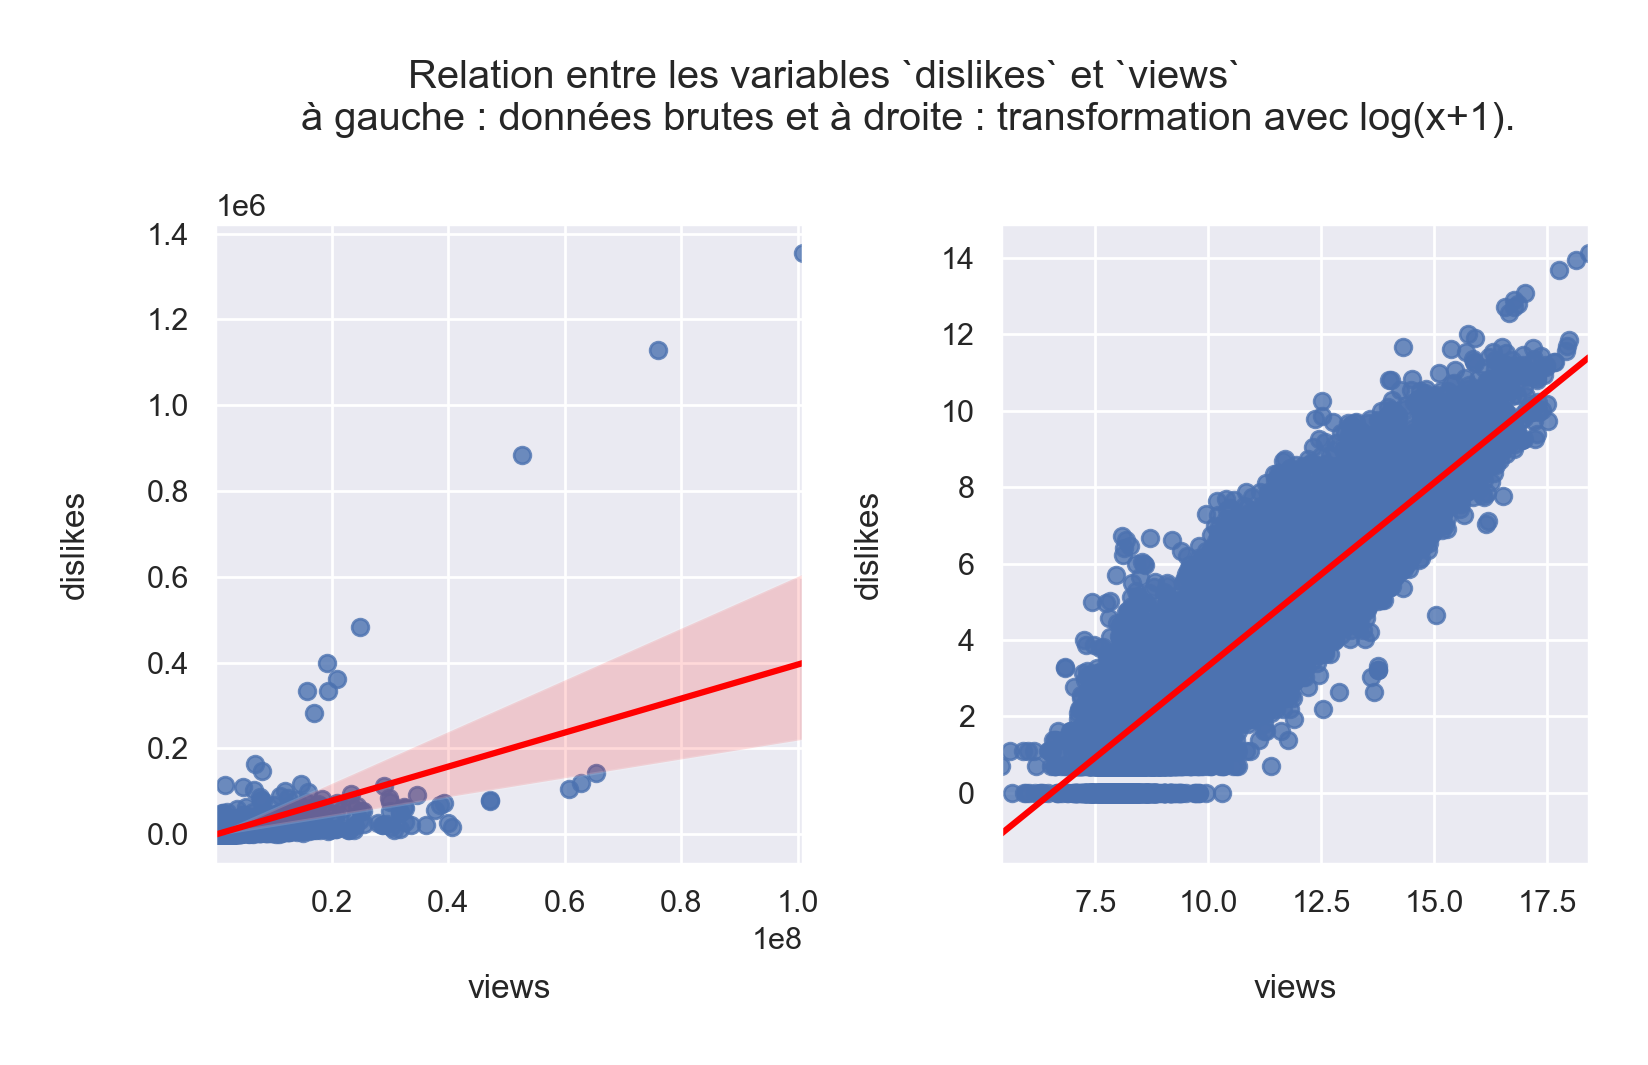

In [96]:
df_ratings_enabled_log = log_transform(df_ratings_enabled, 'views', 'dislikes')

plot_relation(df_ratings_enabled[['views', 'dislikes']], df_ratings_enabled_log[['views', 'dislikes']],
              'views', 'dislikes', 'Relation entre les variables `dislikes` et `views`\n \
              à gauche : données brutes et à droite : transformation avec log(x+1).')

De même que pour la relation entre `likes` et `views`, nous avons uniquement conservé les individus pour lesquels la variable `ratings_disabled` est égale à False et nous avons transformé les variables `dislikes` et `views` en y  appliquant la transformation logarithmique
‘log(x + 1)’  pour obtenir le nuage de points de droite.

Nous observons à droite un seul nuage de points centré sans points à l’écart. La droite de corrélation se décentre au fur et à mesure que les variables augmentent, ce qui montre que la corrélation entre les deux variables est positive (r = 0.59) mais moindre que pour le couple de variables `views` - `likes` vu plus haut.

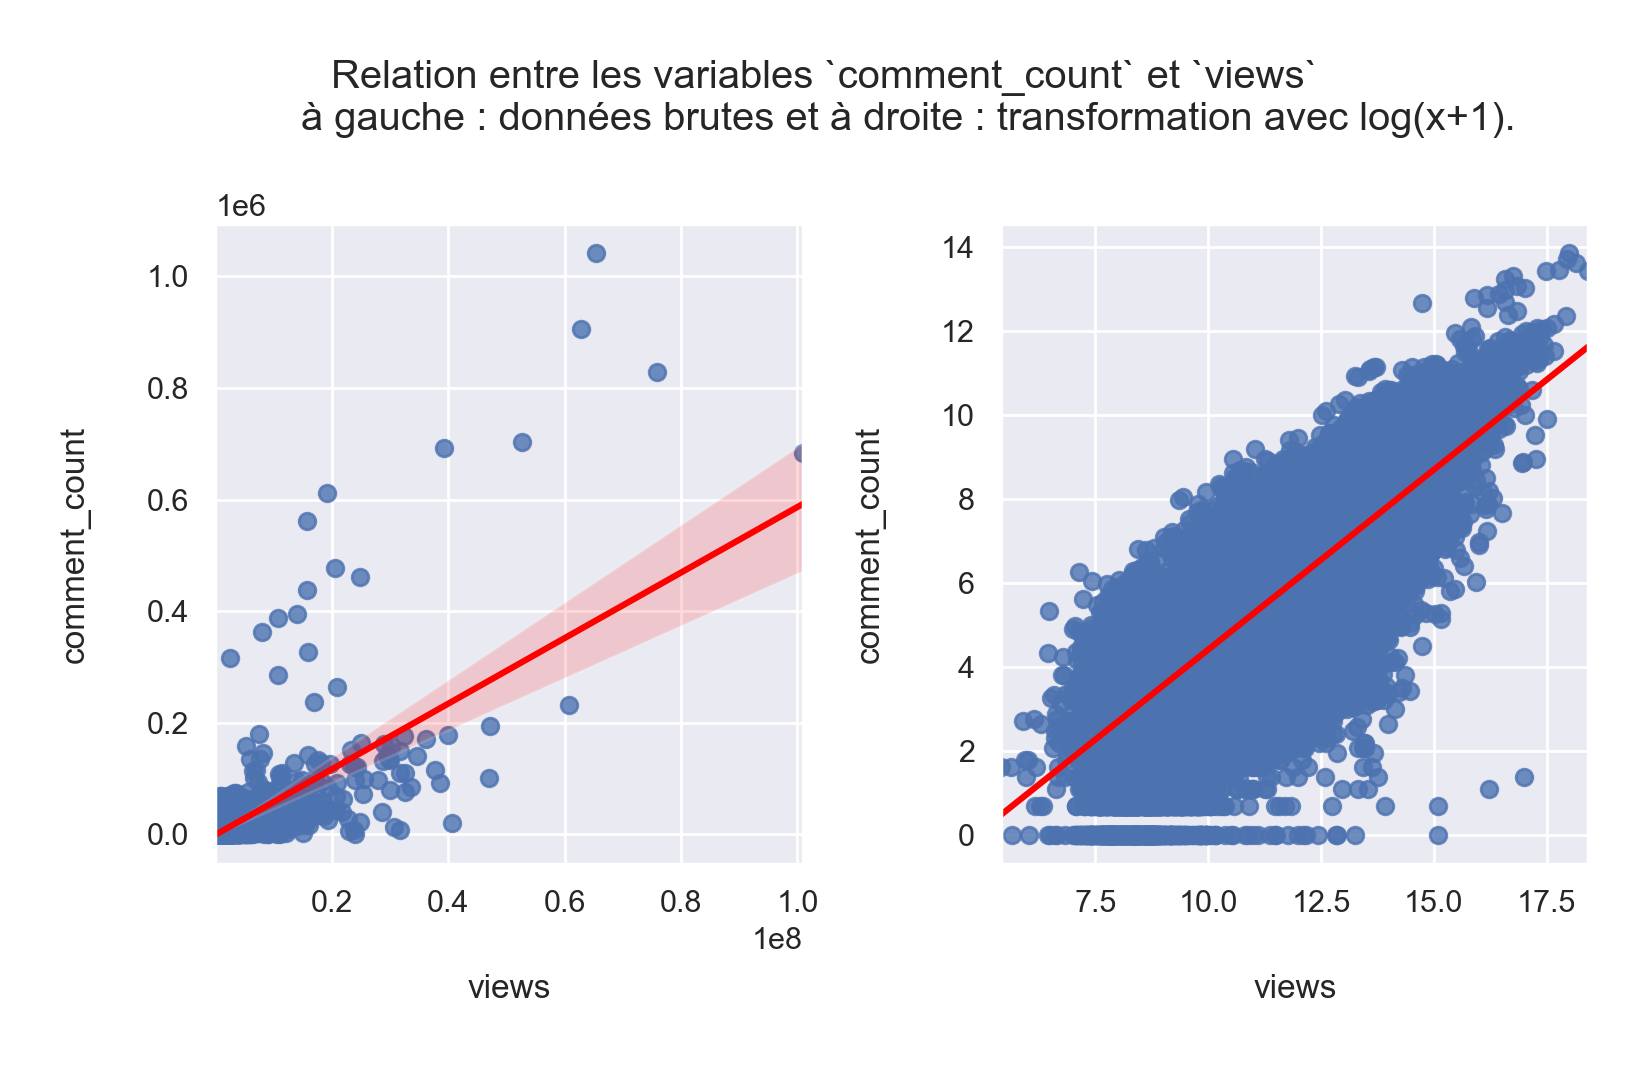

In [97]:
# keep only videos with comments enabled
df_comments_enabled = df.loc[df['comments_disabled'] == False]

df_comments_enabled_log = log_transform(df_comments_enabled, 'views', 'comment_count')

plot_relation(df_comments_enabled[['views', 'comment_count']], df_comments_enabled_log[['views', 'comment_count']],
              'views', 'comment_count', 'Relation entre les variables `comment_count` et `views`\n \
              à gauche : données brutes et à droite : transformation avec log(x+1).')

Pour réaliser les nuages de points ci-dessus, nous avons uniquement conservé les individus ayant les commentaires activés (variable `comments_disabled` égale à False). En effet, pour ceux n’ayant pas les commentaires activés, la variable `comment_count` est égale à 0 ce qui aurait faussé la relation entre les deux variables.

De même que pour la visualisation des relations `likes` - `views` et `dislikes` - `views`, nous avons transformé les variables `comment_count` et `views` en y appliquant la transformation logarithmique ‘log(x + 1)’ pour obtenir le nuage de points de droite.

La droite de corrélation passe au centre du nuage de points ce qui implique une assez forte corrélation entre les deux variables ( r = 0,71).

#### 2.2 Matrice de corrélation

Pour évaluer la dépendance entre toutes les variables quantitatives du dataset en même temps nous avons utilisé une matrice de corrélation. Le résultat est un tableau contenant les coefficients de corrélation de Pearson entre chaque variable en suivant la formule du coefficient de corrélation vue plus haut.

In [98]:
df.corr()

category_id  views  likes  dislikes  comment_count  \
category_id                    1.00  -0.08  -0.09     -0.01          -0.04   
views                         -0.08   1.00   0.81      0.59           0.71   
likes                         -0.09   0.81   1.00      0.45           0.85   
dislikes                      -0.01   0.59   0.45      1.00           0.66   
comment_count                 -0.04   0.71   0.85      0.66           1.00   
comments_disabled              0.04  -0.00  -0.02     -0.01          -0.02   
ratings_disabled               0.00  -0.00  -0.03     -0.01          -0.02   
video_error_or_removed        -0.02   0.00  -0.00     -0.00          -0.00   
thumbnail_link_len             0.00   0.01  -0.00     -0.00          -0.00   
is_live                        0.00   0.01  -0.00     -0.00          -0.00   
contains_capitalized          -0.04  -0.02   0.01     -0.01           0.01   
full_capitalized               0.07  -0.05  -0.00     -0.01          -0.01   
title_length                   0.08  -0.04  -0.10     -0.02          -0.05   

                        comments_disabled  ratings_disabled  \
category_id                          0.04              0.00   
views                               -0.00             -0.00   
likes                               -0.02             -0.03   
dislikes                            -0.01             -0.01   
comment_count                       -0.02             -0.02   
comments_disabled                    1.00              0.47   
ratings_disabled                     0.47              1.00   
video_error_or_removed              -0.00             -0.00   
thumbnail_link_len                   0.01              0.01   
is_live                              0.01              0.01   
contains_capitalized                -0.07             -0.04   
full_capitalized                    -0.06             -0.05   
title_length                         0.03              0.04   

                        video_error_or_removed  thumbnail_link_len  is_live  \
category_id                              -0.02                0.00     0.00   
views                                     0.00                0.01     0.01   
likes                                    -0.00               -0.00    -0.00   
dislikes                                 -0.00               -0.00    -0.00   
comment_count                            -0.00               -0.00    -0.00   
comments_disabled                        -0.00                0.01     0.01   
ratings_disabled                         -0.00                0.01     0.01   
video_error_or_removed                    1.00               -0.00    -0.00   
thumbnail_link_len                       -0.00                1.00     1.00   
is_live                                  -0.00                1.00     1.00   
contains_capitalized                     -0.03                0.02     0.02   
full_capitalized                         -0.01                0.02     0.02   
title_length                             -0.04                0.00     0.00   

                        contains_capitalized  full_capitalized  title_length  
category_id                            -0.04              0.07          0.08  
views                                  -0.02             -0.05         -0.04  
likes                                   0.01             -0.00         -0.10  
dislikes                               -0.01             -0.01         -0.02  
comment_count                           0.01             -0.01         -0.05  
comments_disabled                      -0.07             -0.06          0.03  
ratings_disabled                       -0.04             -0.05          0.04  
video_error_or_removed                 -0.03             -0.01         -0.04  
thumbnail_link_len                      0.02              0.02          0.00  
is_live                                 0.02              0.02          0.00  
contains_capitalized                    1.00              0.45         -

La matrice de corrélation indique les valeurs de corrélation, qui mesurent le degré de relation linéaire entre chaque paire de variables. Les valeurs de corrélation peuvent être comprises entre -1 et +1. Si les deux variables ont tendance à augmenter et à diminuer en même temps, la valeur de corrélation est positive. Lorsqu'une variable augmente alors que l'autre diminue, la valeur de corrélation est négative.

Pour une meilleure représentation de la corrélation entre ces variables, nous visualisons la matrice de corrélation avec un corrélogramme.

Text(0.5, 1.0, 'Carte de fréquentation entre les variables quantitatives du dataset.\n')

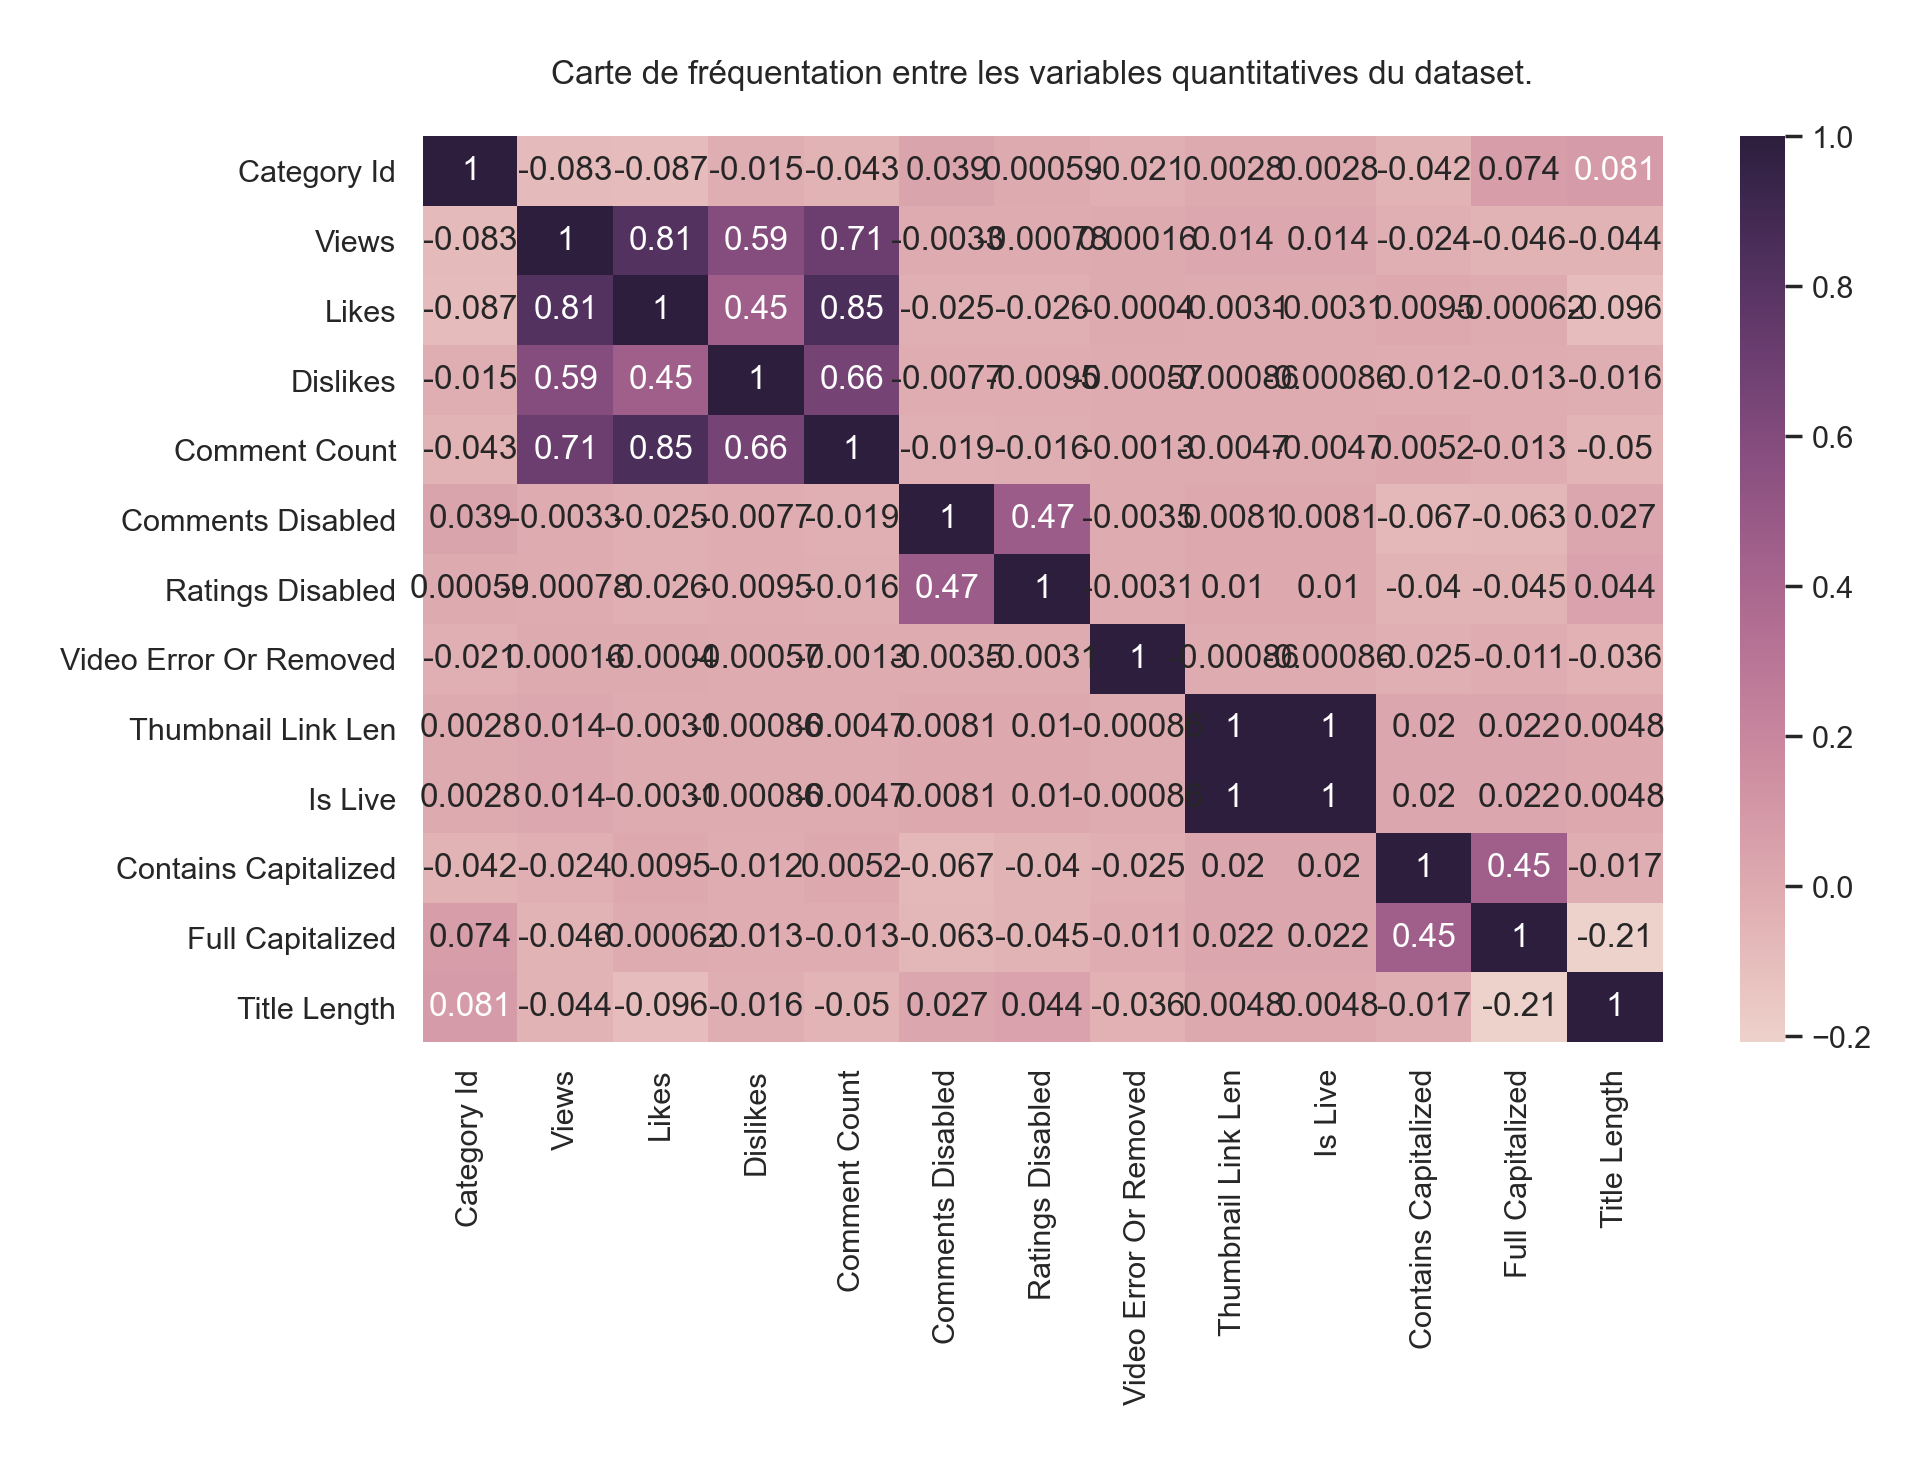

In [99]:
h_labels = [x.replace('_', ' ').title() for x in
            list(df.select_dtypes(include=['number', 'bool']).columns.values)]

fig, ax = plt.subplots(figsize=(10, 6))
_ = sns.heatmap(df.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels,
                cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)
plt.title("Carte de fréquentation entre les variables quantitatives du dataset.\n")

Text(0.5, 1.0, 'Corrélogramme entre les variables quantitatives du dataset.\n')

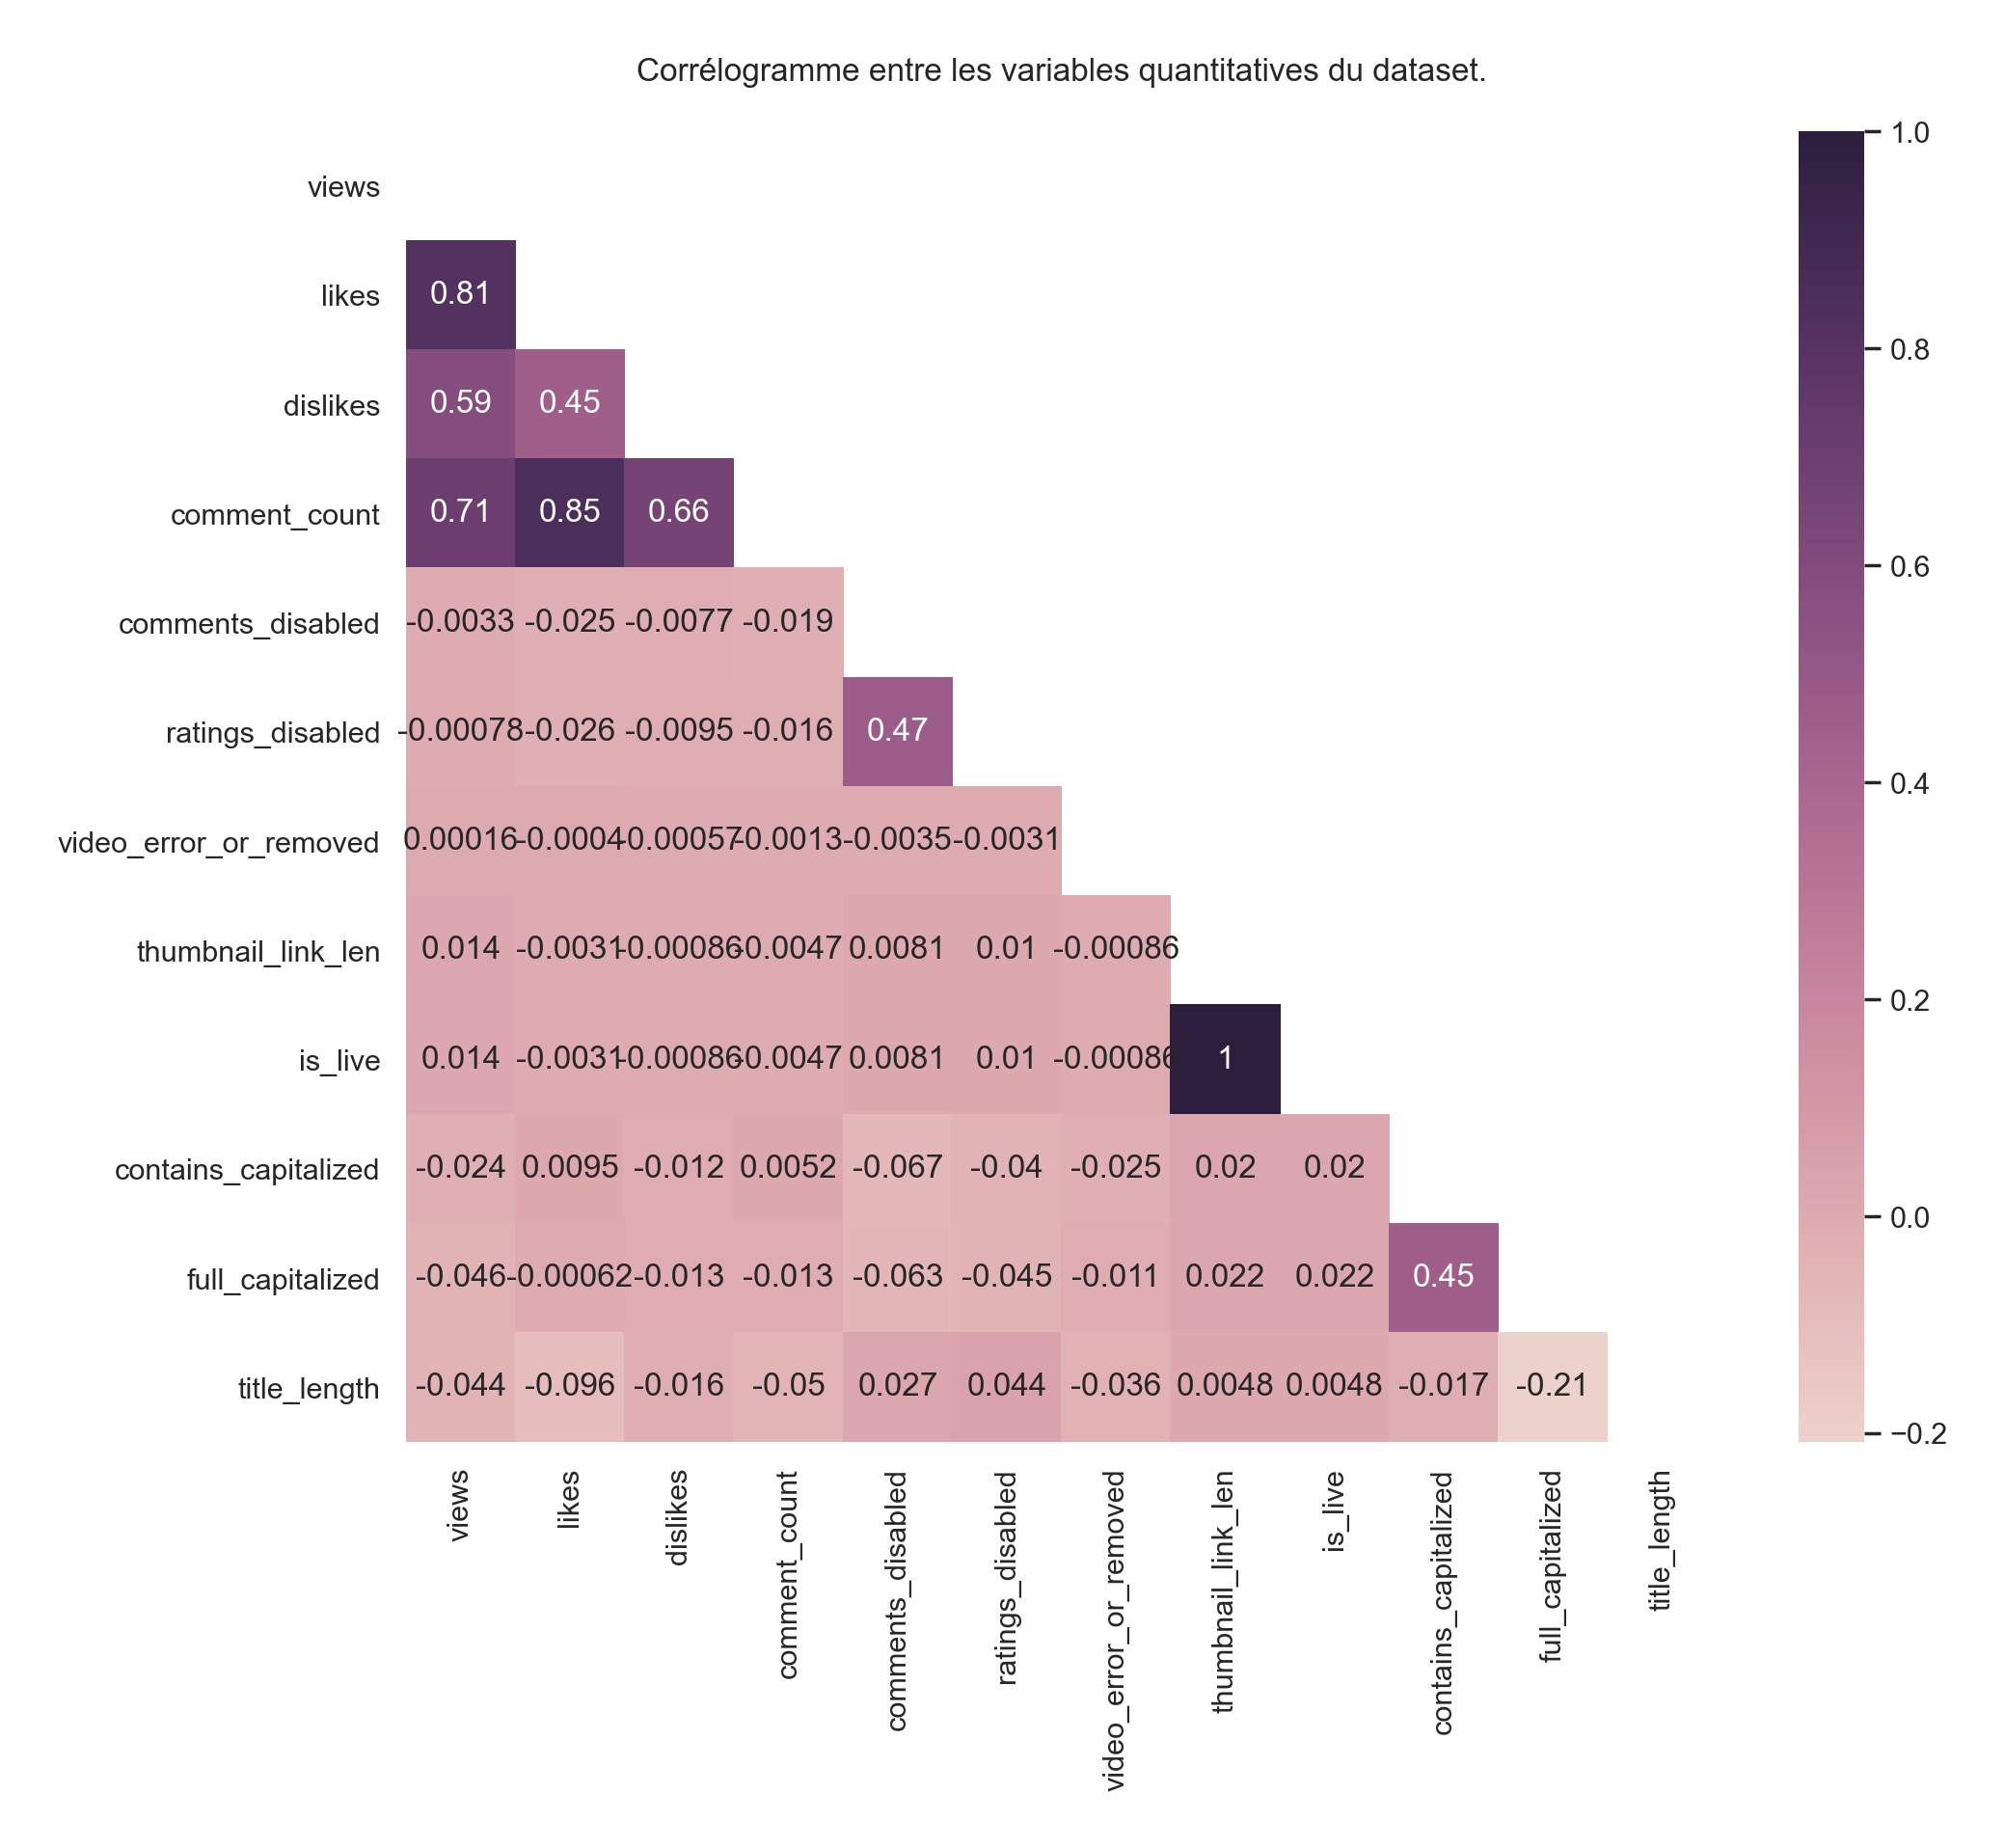

In [100]:
sns.set_theme(style="white")

df_heatmap = df.drop(['category_id'], axis=1)

corr = df_heatmap.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

h_labels = list(df_heatmap.select_dtypes(include=['number', 'bool']).columns.values)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, xticklabels=h_labels, yticklabels=h_labels, mask=mask,
            cmap=sns.cubehelix_palette(as_cmap=True), square=True)
plt.title("Corrélogramme entre les variables quantitatives du dataset.\n")

Sur la matrice de corrélation ci-dessus, nous distinguons deux groupes de corrélation entre les variables. Une relation linéaire positive existe entre les variables `views` et `likes`, `views` et `dislikes`, `views` et `comment_count`, `likes` et `dislikes`, `likes` et `comments_count`, `dislikes` et `comments_count` et `comments_disabled` et `ratings_disabled`.

Pour ces paires, nous retrouvons bien les coefficients de corrélation de Pearson calculés précédemment (cf. IV, 2.1). Ces valeurs indiquent une relation positive assez forte entre les variables. Par exemple, le nombre de likes et de commentaires sur une vidéo ont tendance à augmenter proportionnellement.

Pour le reste des paires de variables, il existe une relation linéaire quasi nulle. Un coefficient de corrélation nul ou quasi nul ne signifie pas l'absence de toute relation entre les variables. Il peut exister une relation non linéaire entre elles.

In [101]:
def get_corr(cov_matrix_list):
    return cov_matrix_list[1][0] / sqrt(cov_matrix_list[0][0] * cov_matrix_list[1][1])


pairs = [('likes', 'comment_count'),
         ('views', 'likes'),
         ('views', 'comment_count'),
         ('dislikes', 'comment_count'),
         ('views', 'dislikes'),
         ('comments_disabled', 'ratings_disabled'),
         ('likes', 'dislikes')]

for var1, var2 in pairs:
    cov_matrix = df[[var1, var2]].cov()
    cov_matrix_list = cov_matrix.values.tolist()
    cov = cov_matrix_list[1][0]
    corr = get_corr(cov_matrix_list)
    print(f"Pair {var1} - {var2} :\n--> cov = {cov}\n--> corr = {corr:.2f}")

Pair likes - comment_count :
--> cov = 1040511875.4365032
--> corr = 0.85
Pair views - likes :
--> cov = 125573394426.97145
--> corr = 0.81
Pair views - comment_count :
--> cov = 17623563089.914135
--> corr = 0.71
Pair dislikes - comment_count :
--> cov = 106371594.4883615
--> corr = 0.66
Pair views - dislikes :
--> cov = 11850562262.356533
--> corr = 0.59
Pair comments_disabled - ratings_disabled :
--> cov = 0.009027619896681523
--> corr = 0.47
Pair likes - dislikes :
--> cov = 447600455.59102553
--> corr = 0.45


### V - Analyses multivariées des données

Les analyses multivariées permettent de prendre en compte les variables d’ajustements. Elles sont donc recommandées lorsqu’on cherche à établir un lien statistique entre plusieurs variables. Les analyses multivariées font appel à des méthodes statistiques plus sophistiquées que les analyses bivariées.

#### 1 - Pré-traitement

Avant de réaliser des analyses multivariées, nous avons effectué un pré-traitement des données. Dans la partie concernant l’analyse multivariée, nous avons pu observer des outliers que nous allons supprimer du datatset.

Si on reprend  le nuage de points à l’échelle logarithmique représentant la relation entre les variables `views` et `likes` vu précédemment (cf. IV, 2.1), nous observons un point éloigné en bas à droite du nuage (flèche rouge), avec x >≈ 10 et y = 0, donc une vidéo ayant plus de exp(10) - 1 ≈ 22 000 vues et exp(0) - 1 = 0 likes.

Si l'on filtre le dataset avec ces données, on se rend compte que nous obtenons deux vidéos. Les deux points sont donc superposés sur le nuage de points.

In [117]:
# TODO

#df.loc[(df['views'] > exp(10) - 1) & (df['likes'] == exp(0) - 1)]
df.loc[df['video_id'] == 'bUStcgFlAIY']

video_id trending_date                                  title  \
16386  bUStcgFlAIY      18.06.02  Mennel « Hallelujah »_ The Voice 2018   
16598  bUStcgFlAIY      18.07.02                          Deleted video   
16858  bUStcgFlAIY      18.08.02                          Deleted video   

                           channel_title  category_id  \
16386                           Les Adix           20   
16598  LMDLT Le Meilleur de la télévison           24   
16858                          FRANCE 24           25   

                   publish_time  \
16386  2018-02-05T19:10:20.000Z   
16598  2018-02-06T11:31:29.000Z   
16858  2018-02-07T16:17:35.000Z   

                                                    tags  views  likes  \
16386                                             [none]  40914    574   
16598  mennel the voice"|"isabelle morini bosc racist...  29800      0   
16858  Neige"|"Paris"|"Tour Eiffel"|"Froid"|"France 2...  61913    355   

       dislikes  ...                                  thumbnail_link  \
16386        83  ...  https://i.ytimg.com/vi/bUStcgFlAIY/default.jpg   
16598         0  ...  https://i.ytimg.com/vi/AUSspdHxNt4/default.jpg   
16858        25  ...  https://i.ytimg.com/vi/kLawXJfmlAs/default.jpg   

      comments_disabled  ratings_disabled  video_error_or_removed  \
16386             False             False                   False   
16598             False             False                    True   
16858             False             False                    True   

                                             description thumbnail_link_len  \
16386                                                NaN                 46   
16598  6 févrirer 2018 !\n\nce lundi 5 février \nIsab...                 46   
16858  Abonnez-vous à notre chaîne sur YouTube : http...                 46   

       is_live  contains_capitalized  full_capitalized  title_length  
16386    False                 False             False            37  
16598    False                 False             False            13  
16858    False                 False             False            13  

[3 rows x 21 columns]

On remarque que cette vidéo comptabilise 214 commentaires et 29800 vues et que, même si les commentaires et la notation sont activés, elle ne possède pas de likes et de dislikes, ce qui est assez étrange. Il s’agit donc d’un outiler (point distant par rapport aux autres points de l’observation qui n’est pas représentatif de l’échantillon).

In [118]:
# TODO
df.loc[(df['views'] > exp(15) - 1) & (df['comment_count'] < exp(2) - 1)]

video_id trending_date  \
12634  MvFcY9rTPx8      18.18.01   
12921  MvFcY9rTPx8      18.19.01   
16191  BhIEIO0vaBE      18.05.02   
16389  BhIEIO0vaBE      18.06.02   
16608  BhIEIO0vaBE      18.07.02   
16877  BhIEIO0vaBE      18.08.02   
17152  y3niFzo5VLI      18.09.02   
20437  tilwcTZcoz4      18.26.02   
22145  305ryPvU6A8      18.07.03   
22378  305ryPvU6A8      18.08.03   
22722  305ryPvU6A8      18.09.03   
28506  9TUBf6l7FBg      18.14.04   
28689  9TUBf6l7FBg      18.15.04   
28892  9TUBf6l7FBg      18.16.04   
28969  Q3jege0p0dQ      18.16.04   
31782  RFywfHsFpQM      18.30.04   
33179  6Q0AazVu1Tc      18.07.05   

                                                   title  \
12634                        Michigan Meteor Jan 16 2018   
12921                        Michigan Meteor Jan 16 2018   
16191                                    To Our Daughter   
16389                                    To Our Daughter   
16608                                    To Our Daughter   
16877                                    To Our Daughter   
17152  🔴 LIVE: Starman Driving in Space after Success...   
20437  Bollywood diva Sridevi Funeral Full Video Srid...   
22145      HomePod — Welcome Home by Spike Jonze — Apple   
22378      HomePod — Welcome Home by Spike Jonze — Apple   
22722      HomePod — Welcome Home by Spike Jonze — Apple   
28506                      Coachella 2018 LIVE Channel 1   
28689                      Coachella 2018 LIVE Channel 1   
28892                      Coachella 2018 LIVE Channel 1   
28969  Marc Spelmann gets the first Golden Buzzer of ...   
31782  Jack and Tim receive GOLDEN BUZZER from Simon ...   
33179  Donchez bags a GOLDEN BUZZER with his Wiggle a...   

              channel_title  category_id              publish_time  \
12634           Mike Austin           25  2018-01-17T01:35:40.000Z   
12921           Mike Austin           25  2018-01-17T01:35:40.000Z   
16191          Kylie Jenner           22  2018-02-04T20:27:38.000Z   
16389          Kylie Jenner           22  2018-02-04T20:27:38.000Z   
16608          Kylie Jenner           22  2018-02-04T20:27:38.000Z   
16877          Kylie Jenner           22  2018-02-04T20:27:38.000Z   
17152         American News           25  2018-02-07T14:25:30.000Z   
20437         Telugu Corner            2  2018-02-25T03:31:59.000Z   
22145                 Apple           28  2018-03-06T05:00:32.000Z   
22378                 Apple           28  2018-03-06T05:00:32.000Z   
22722                 Apple           28  2018-03-06T05:00:32.000Z   
28506             Coachella           10  2018-04-05T06:48:28.000Z   
28689             Coachella           10  2018-04-05T06:48:28.000Z   
28892             Coachella           10  2018-04-05T06:48:28.000Z   
28969  Britain's Got Talent           24  2018-04-14T19:53:33.000Z   
31782  Britain's Got Talent           24  2018-04-28T20:14:56.000Z   
33179  Britain's Got Talent           24  2018-05-05T19:29:19.000Z   

                                                    tags     views   likes  \
12634                                  michigan"|"meteor   3624449   26324   
12921                                  michigan"|"meteor   4811863   39210   
16191  Kylie Jenner"|"Kylie"|"Travis Scott"|"Baby"|"A...  20921796       0   
16389  Kylie Jenner"|"Kylie"|"Travis Scott"|"Baby"|"A...  35832484       0   
16608  Kylie Jenner"|"Kylie"|"Travis Scott"|"Baby"|"A...  40801423       0   
16877  Kylie Jenner"|"Kylie"|"Travis Scott"|"Baby"|"A...  44818108       0   
17152                    SpaceX"|"Falcon"|"NASA"|"launch   3612445   40354   
20437  sridevi dead"|"sridevi death"|"sridevi sad dem...   6793122   15860   
22145  anderson paak"|"apartment"|"apple"|"apple musi...   4794673   48139   
22378  anderson paak"|"apartment"|"apple"|"apple musi...   5491259   63317   
22722  anderson paak"|"apartment"|"apple"|"apple musi...   5846111   71829   
28506                                             [none]   3598220       0   
28689

Il en est de même pour le nuage de points à l’échelle logarithmique représentant la relation entre les variables `views` et `comment_count`. Nous observons sur ce dernier quatre points excentrés en bas à droite (cercle rouge). Ils sont situés à partir de x >≈ 15 et y <≈ 2, soit des vidéos ayant plus de exp(15) - 1 ≈  3 millions de vues et exp(2) - 1 ≈ 7 commentaires. En triant le dataset avec ces critères, on retrouve les quatres points vus sur le nuage de points. Il s’agit des quatre vidéos suivantes :

In [ ]:
# TODO

Le point commun entre ces vidéos est que ce sont toutes des diffusions en direct mais nous n’avons pas réussi à expliquer le nombre si peu élevé de commentaires. Nous sommes donc en présence de valeurs aberrantes.

Nous supprimons donc les 5 valeurs aberrantes de notre dataset. Nous travaillons désormais avec un dataset  de la forme n x p avec n = 40719 individus et p = 16 variables.

In [ ]:
videos_to_delete = ['y3niFzo5VLI', '9TUBf6l7FBg']

df = df[~df['video_id'].isin(videos_to_delete)]
df = df.loc[(df['video_id'] != 'bUStcgFlAIY') | (df['channel_title'] != 'LMDLT Le Meilleur de la télévison')]
df.shape

# TODO : change dataset size above

### 2 - Analyse en Composantes Principales

Notre étude vise à décrire le jeu de données en utilisant la méthode de l’ACP.

#### 2.1 Définition

L'Analyse en Composantes Principales (ACP) consiste à transformer des variables corrélées en de nouvelles variables décorrélées les unes des autres. Ces nouvelles variables sont nommées composantes principales. Cette analyse factorielle permet de réduire le nombre de variables et de rendre l'information moins redondante.

L’ACP permet d’explorer les liaisons entre variables et les ressemblances entre individus. Les résultats de cette analyse permettent la visualisation des individus (notion de distance entre eux)  et la visualisation des variables (en fonction de leurs corrélations). Elle est également très utilisée dans le domaine du machine learning en tant que prétraitement car elle permet de réduire le nombre de dimensions d’un dataset.

#### 2.2 Application

Pour réaliser une ACP sur notre datastet, nous avons uniquement conservé les variables quantitatives numériques (`views`, `likes`, `dislikes`, `comment_count`) que nous avons représenté sous forme d’une matrice.

Nous avons utilisé la classe PCA de la librairie Python fanalysis avec cette matrice, qui est centrée et réduite avant de lancer l’analyse.

A partir des valeurs propres et en utilisant la sélection caractéristique, nous pouvons réduire la dimension des données et sélectionner un ensemble de variables plus pertinentes pour la représentation de l’information du dataset.

Les valeurs propres récupérées nous permettent de générer un scree plot (diagramme d'éboulis) mettant en évidence le coude qui nous permet de déterminer le nombre minimal de composantes à garder pour conserver la majorité des données initiales.

In [119]:
df = df[['views', 'likes', 'dislikes', 'comment_count']]
df = df.loc[:, ~df.columns.duplicated()]
df

views  likes  dislikes  comment_count
0      212702  29282      1108           3817
1      432721  14053       576           1161
2      482153  76203       477           9580
3      925222  85016       550           4303
4      141695   8091        72            481
...       ...    ...       ...            ...
40719   58758    307        86            485
40720  264639   2011       999           1397
40721   47510   4601        61            615
40722   78117    244        74             46
40723   46604    947        37            127

[40724 rows x 4 columns]

In [120]:
df.columns.values

array(['views', 'likes', 'dislikes', 'comment_count'], dtype=object)

In [121]:
pca = PCA(std_unit=True, row_labels=df.index.values, col_labels=df.columns.values)
#projected = pca.fit_transform(x)

pca.fit(df.to_numpy())

PCA(col_labels=array(['views', 'likes', 'dislikes', 'comment_count'], dtype=object),
    row_labels=array([    0,     1,     2, ..., 40721, 40722, 40723], dtype=int64))

In [122]:
print(pca.eig_)

[[3.05177391e+00 5.85374365e-01 2.92755218e-01 7.00965046e-02]
 [7.62943478e+01 1.46343591e+01 7.31888045e+00 1.75241261e+00]
 [7.62943478e+01 9.09287069e+01 9.82475874e+01 1.00000000e+02]]


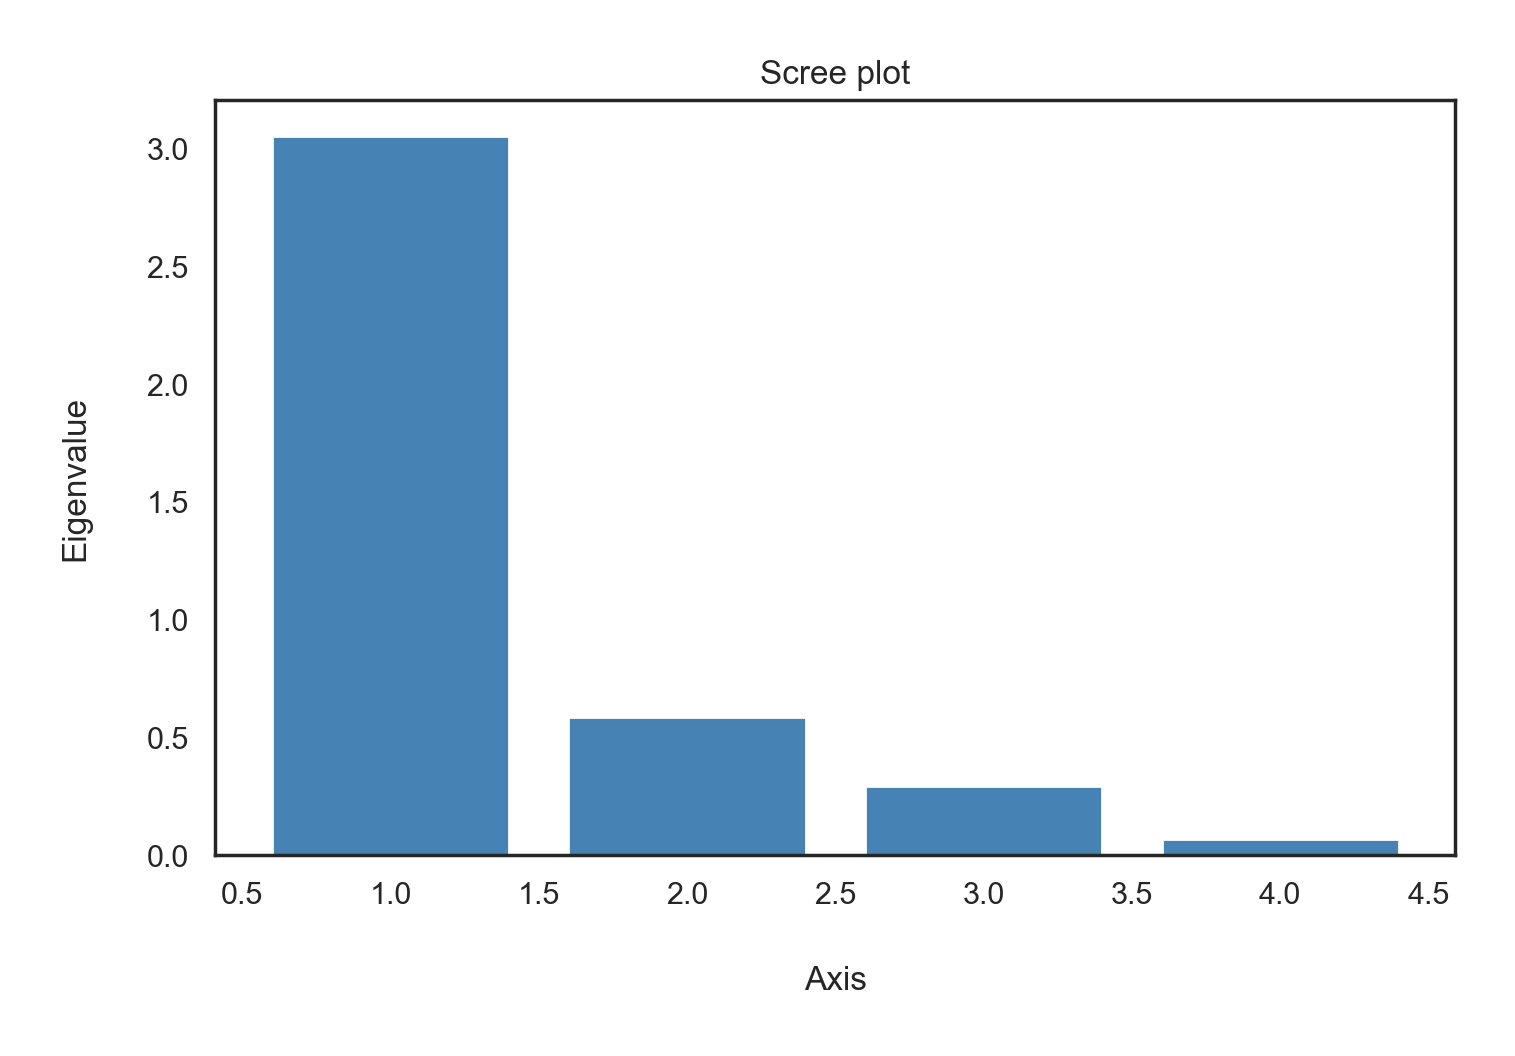

In [123]:
pca.plot_eigenvalues()

On peut voir que le coude se situe entre la composante 2 et 3. On en déduit donc que 2 est le nombre minimal de composantes à garder pour conserver la majorité des données du dataset.


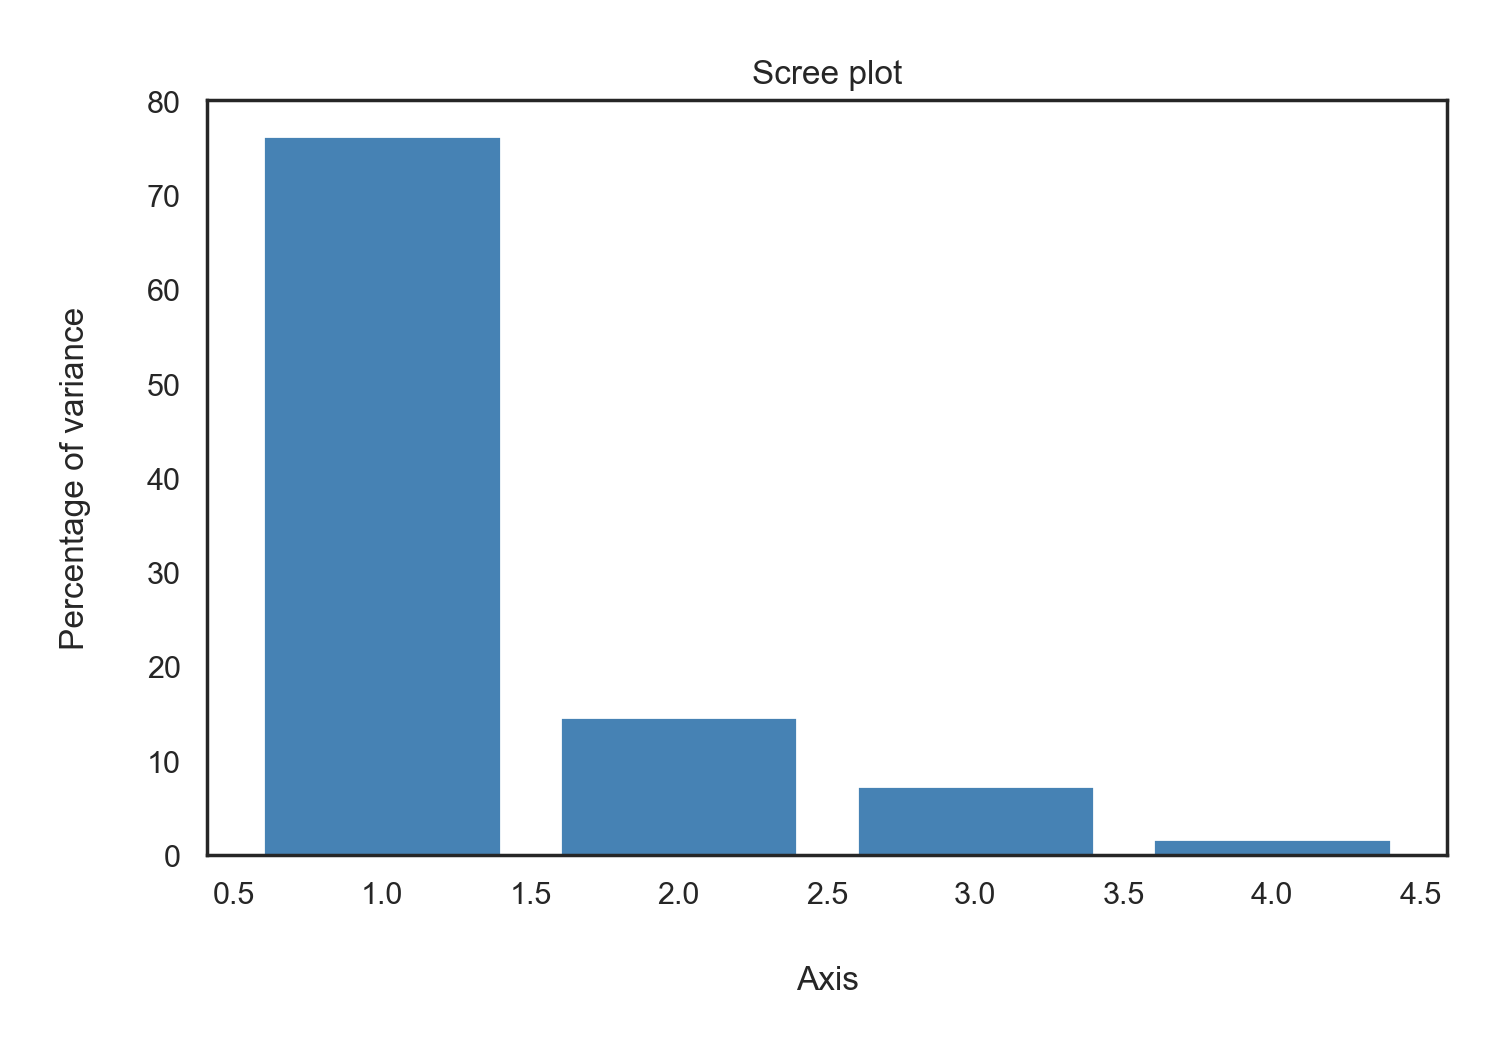

In [124]:
pca.plot_eigenvalues(type="percentage")

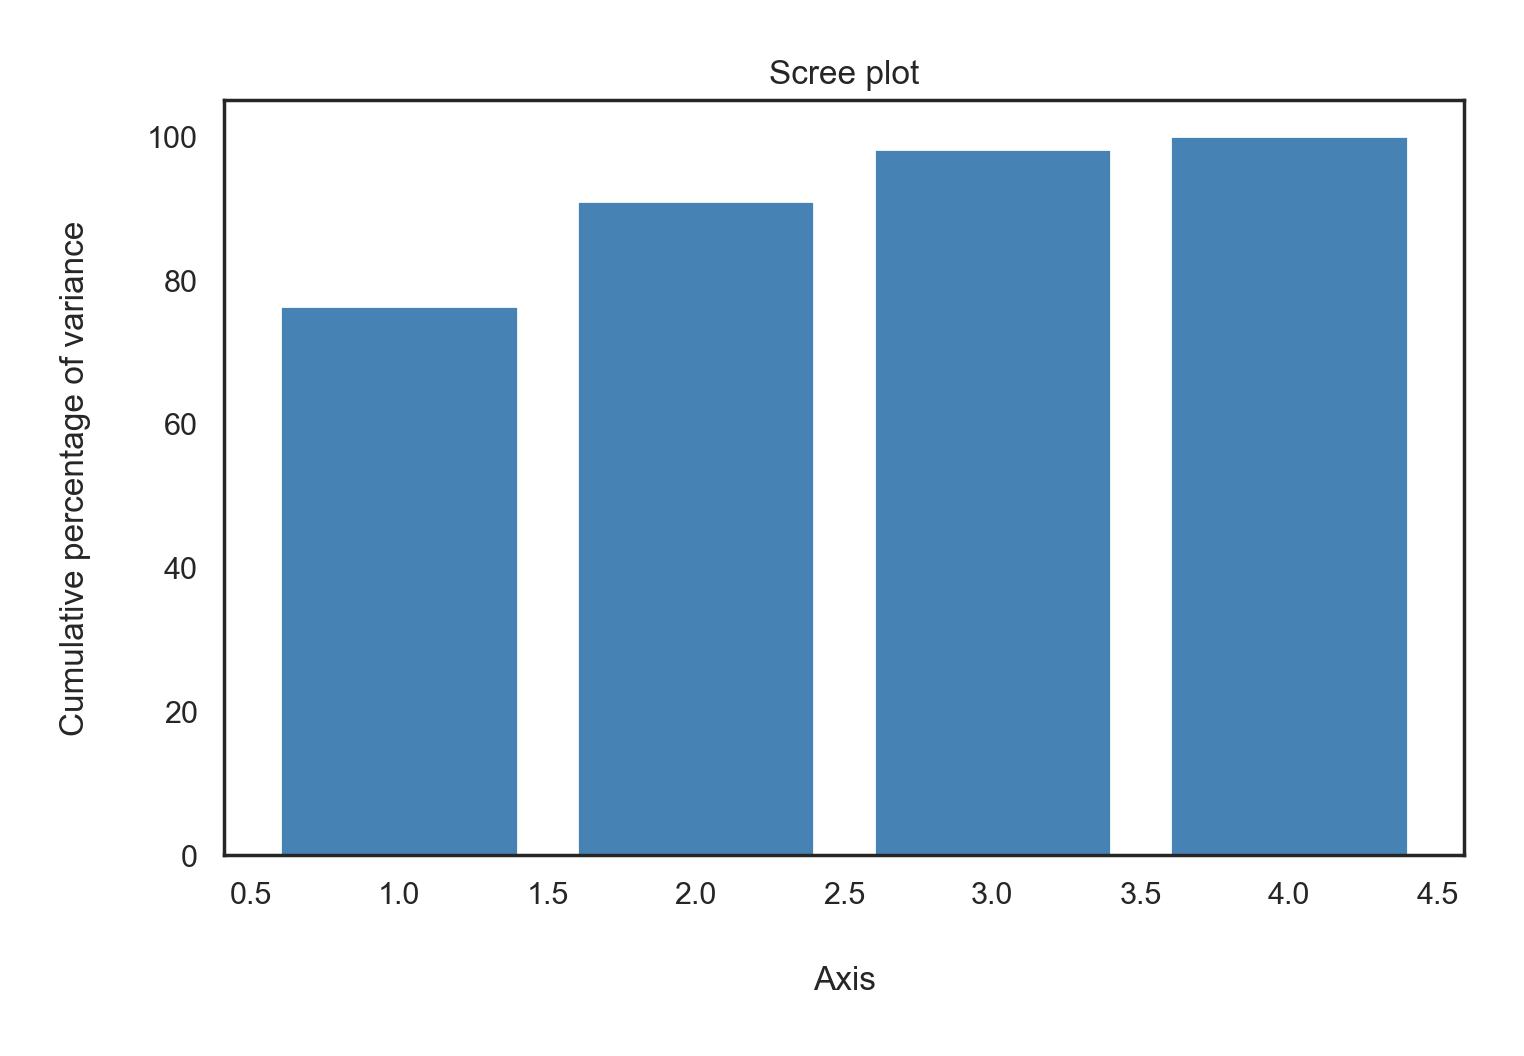

In [125]:
pca.plot_eigenvalues(type="cumulative")

Sur le pourcentage cumulé croissant ci-dessus, on peut voir qu’en ne gardant que 2 composantes principales, nous conservons ≈ 90% des données initiales.

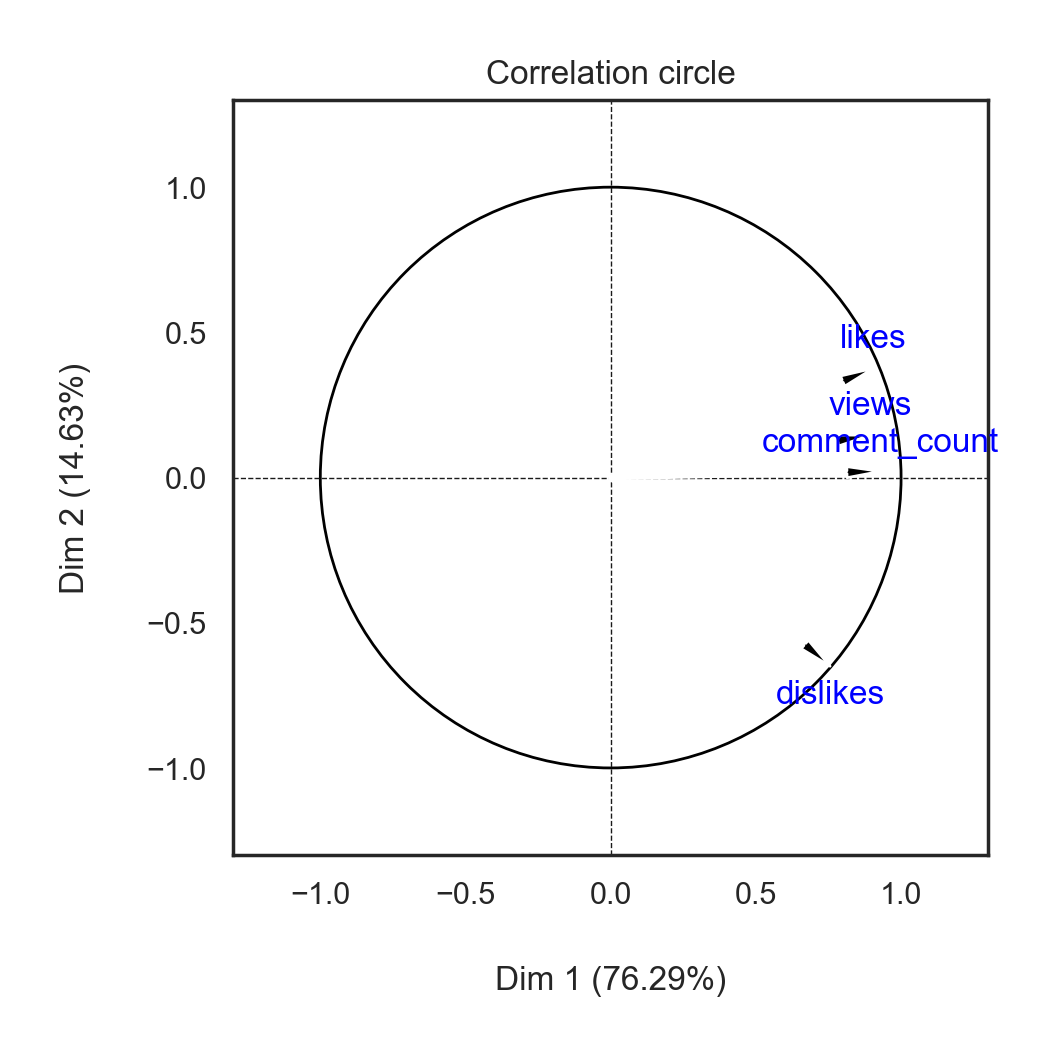

In [126]:
pca.correlation_circle(num_x_axis=1, num_y_axis=2)

Dans un cercle de corrélation, l’angle entre 2 variables, mesuré par son cosinus, est égal au coefficient de corrélation linéaire entre les 2 variables:
si les points sont très proches (angle proche de 0), cos(angle) = r(X1, X2) = 1 donc X1 et X2 sont très fortement corrélées positivement,
si l’angle est égal à 90°, cos(angle) = r(X1, X2) = 0 donc il n’y a pas de corrélation linéaire entre X1 et X2,
si les points sont opposés (l’angle vaut 180°), cos(angle) = r(X1,X2) = -1 donc X1 et X2 sont très fortement corrélées négativement.
Dans notre cas, nous pouvons interpréter les variables car elles sont bien projetées sur le bord du cercle. Nous observons sur le cercle un angle aigu entre chaque variable, ce qui est le signe d’une corrélation positive entre chacune d’elles, chose que l’on a déjà pu observer dans la partie analyse bivariée (cf. IV, 2.2)

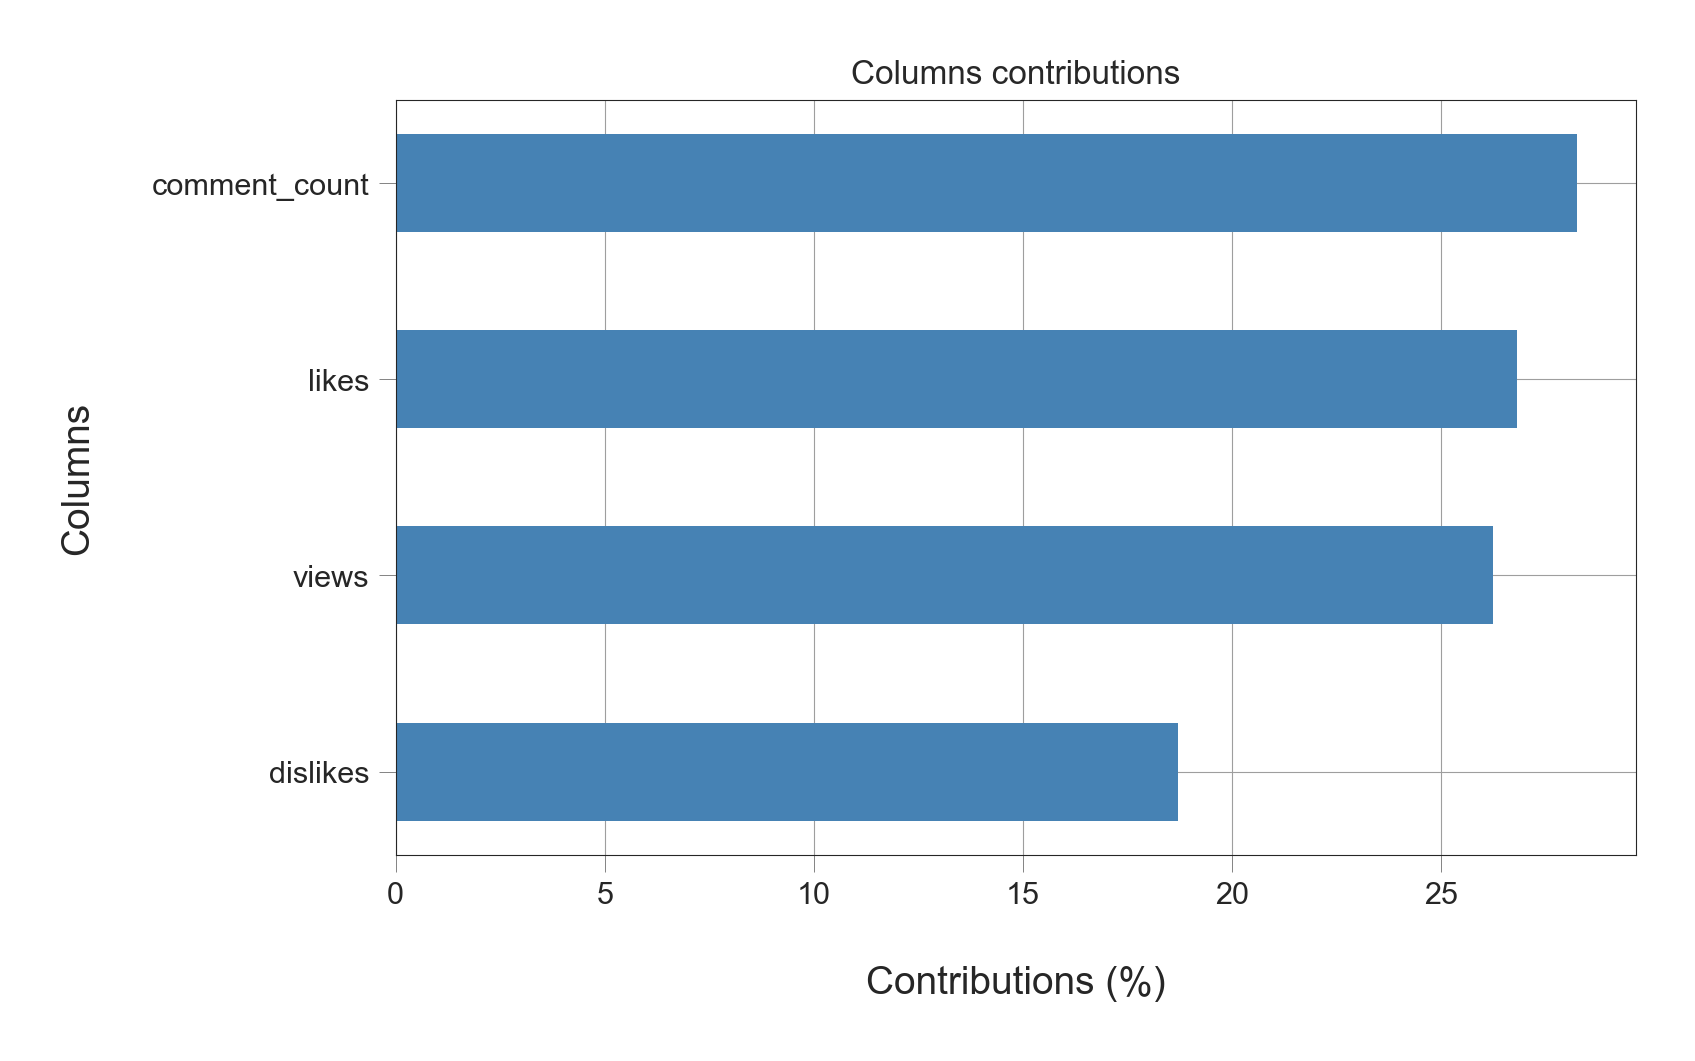

In [129]:
pca.plot_col_contrib(num_axis=1)

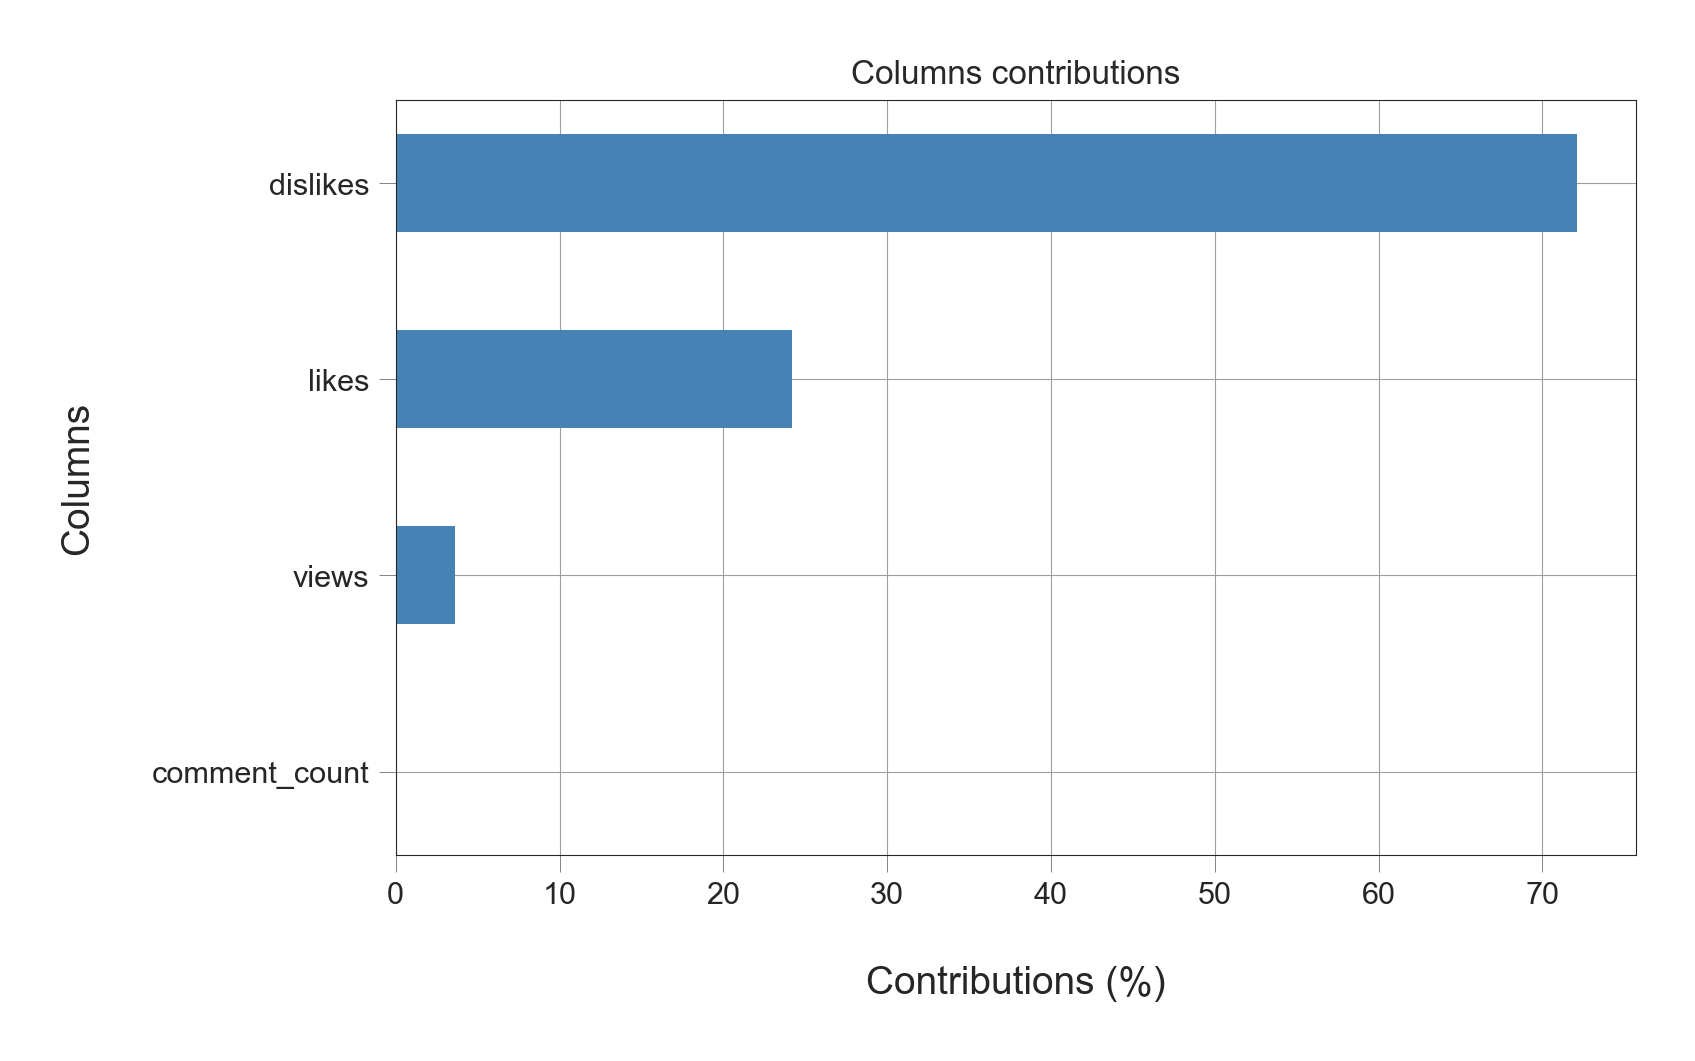

In [130]:
pca.plot_col_contrib(num_axis=2)

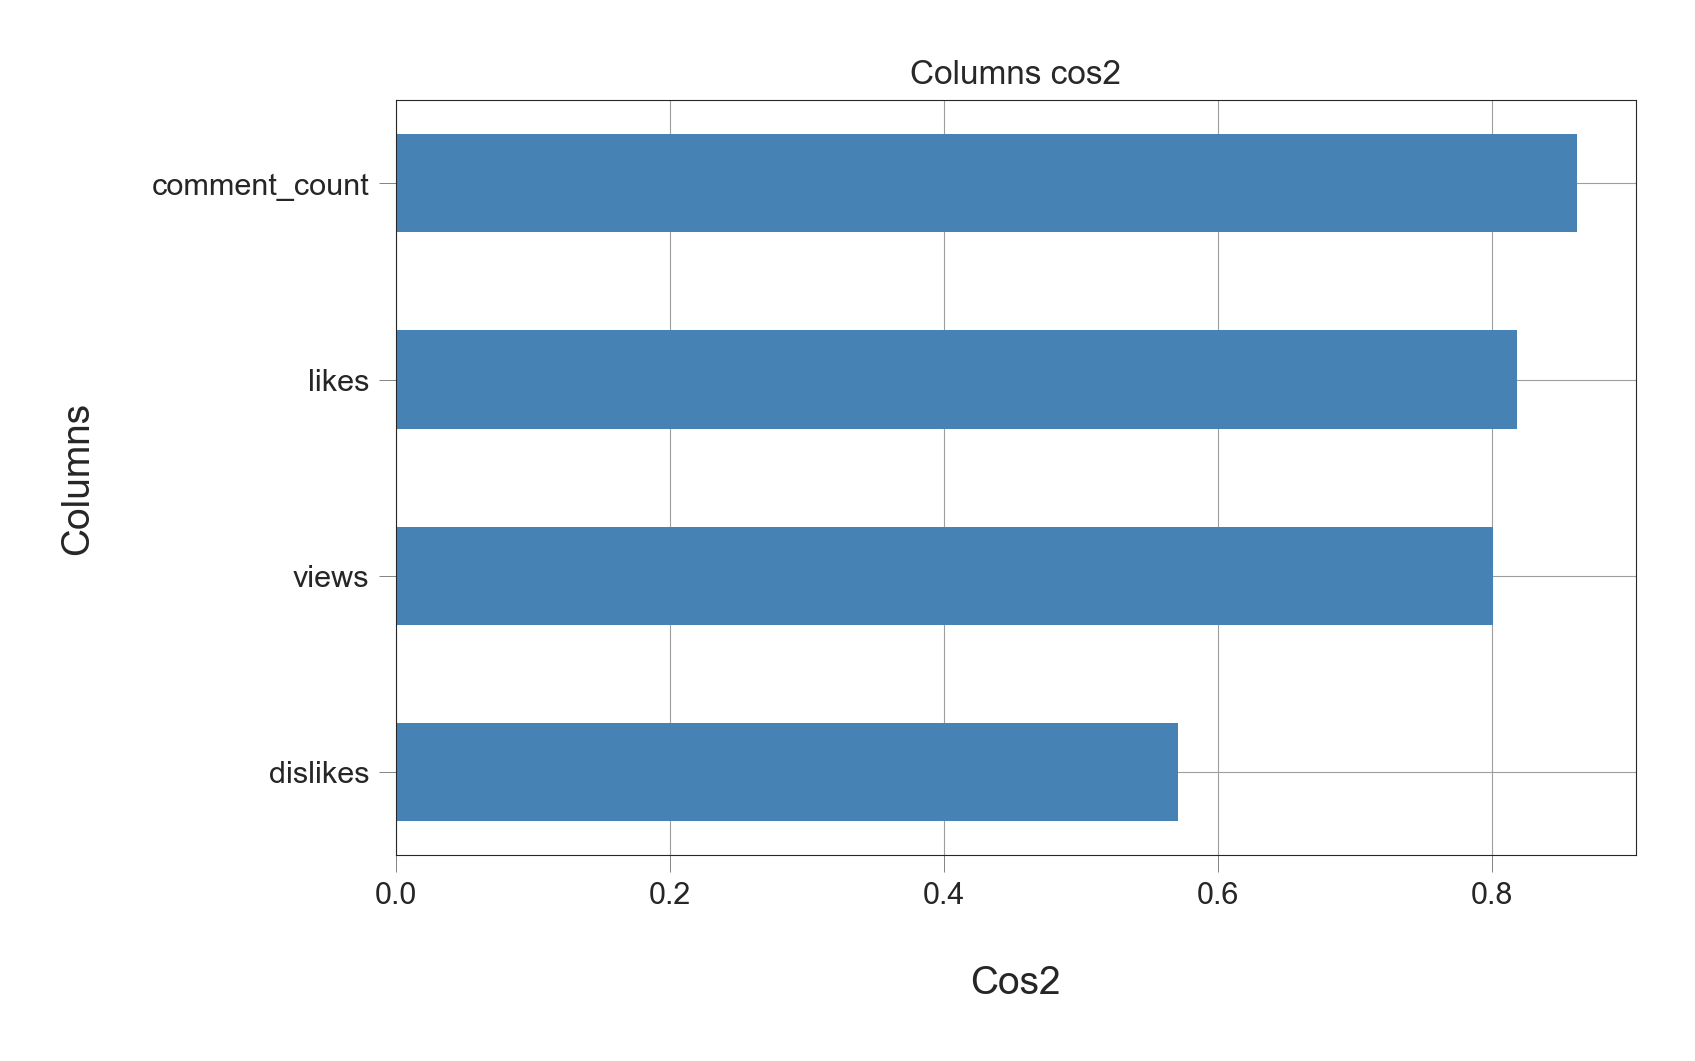

In [131]:
pca.plot_col_cos2(num_axis=1)

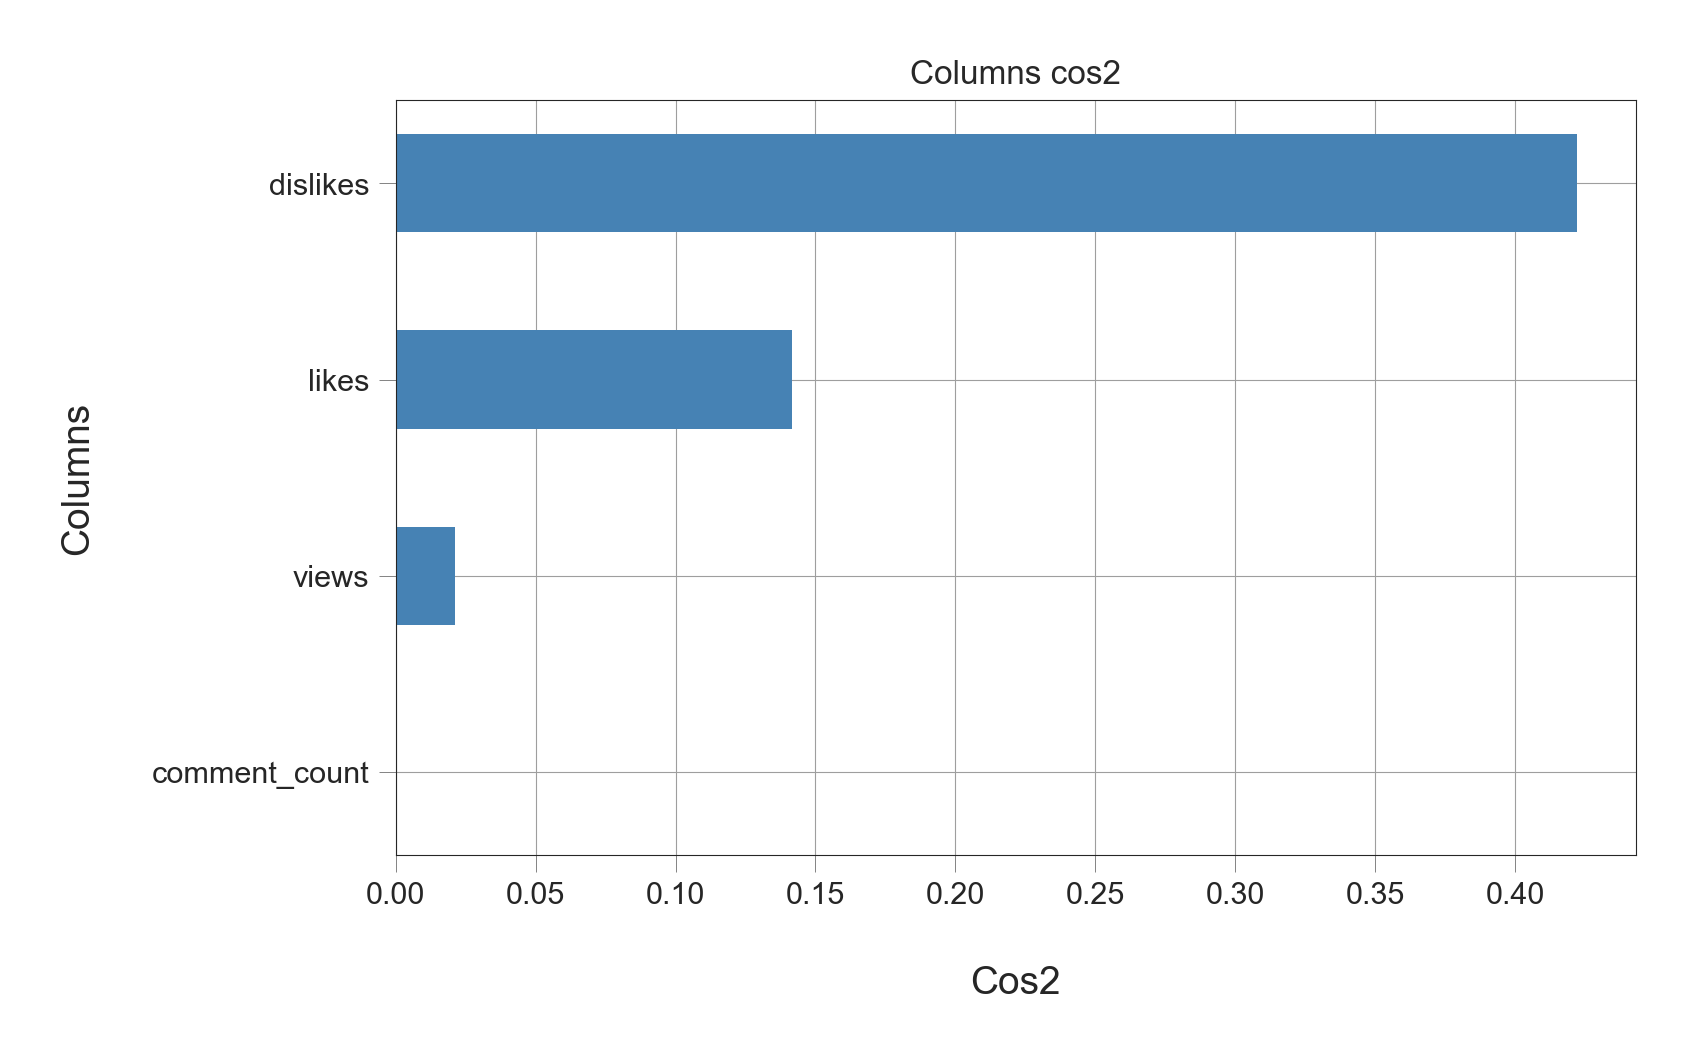

In [132]:
pca.plot_col_cos2(num_axis=2)

On peut voir que toutes les variables sont corrélées avec le 1er axe (1ère dimension) donc peuvent se décrire à partir d’un seule dimension, cependant le second graphe ci-dessous nous montre que la variable dislike est fortement corrélée avec le 2eme axe (2eme dimension), ce qui nécessite l’utilisation de deux dimension pour pouvoir décrire toute l’information de notre dataset.

### 3 - Régression Linéaire

#### 3.1 Définition

Un modèle de régression linéaire est un modèle de régression qui cherche à établir une relation linéaire entre une variable expliquée et une ou plusieurs variables explicatives. Ce modèle permet d'établir des estimations dans le futur à partir d'informations provenant du passé.

Dans notre cas, nous voulons être en mesure de prédire le nombre de likes d’une vidéo en fonction du nombre de vues, de dislikes, de commentaires, de sa catégorie et de la date à laquelle elle est apparue dans l’onglet des tendances.

#### 3.2 Application

Pour cela nous allons utiliser un modèle linéaire multiple basé sur 8 variables. Quatre d’entre elles ont déjà été présentées (cf. III, 2). Il s’agit des variables 'views', 'likes`, `dislikes',  'comment_count' et `category_id`. Nous avons également introduit trois nouvelles variables :
`trending_month` : nombre entier qui représente le mois où la vidéo est apparue en tendances,
`publish_month` : nombre entier qui représente le mois où la vidéo a été publiée,
`is_positive_interaction` : nombre entier qui permet de savoir si les utilisateurs ont interagi positivement ou négativement face à la vidéo. Cette variable prend la valeur 1 si le rapport likes/views est supérieur au rapport dislikes/views et dans le cas échéant la valeur 0.

A partir de ces huit variables et avec l’utilisation de la classe LinearRegression de la bibliothèque scikit-learn qui ajuste les coefficients de la droite de régression, nous avons pu générer notre modèle. Ce dernier a été entraîné sur 30% de la population totale.

Pour pouvoir nous faire une idée de la distance qui la sépare des individus, affichons la droite de régression.


In [134]:
df = pd.read_csv(CSV_VIDEOS_PATH) #TODO : KeyError: 'publish_time' ???

df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

df['publish_month'] = df['publish_time'].dt.month

df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['trending_month'] = df['trending_date'].dt.month

df['like_percent'] = pd.DataFrame((df['likes'] / df['views']) * 100)
df['dislike_percent'] = pd.DataFrame((df['dislikes'] / df['views']) * 100)

df['is_positive_interaction'] = df['like_percent'] > df['dislike_percent']

In [135]:
# comparing the likes to dislikes ratio
video_feel = []
for item in df['is_positive_interaction']:
    if item is True:
        video_feel.append(1)
    else:
        video_feel.append(0)

df['is_positive_interaction'] = video_feel

In [136]:
# reorganize df
df_save = df
df = df[
    ['category_id', 'trending_date', 'trending_month', 'publish_time', 'publish_month', 'category_id', 'views', 'likes',
     'dislikes', 'is_positive_interaction', 'comment_count']]
df.head()

category_id trending_date  trending_month        publish_time  \
0           24    2017-11-14              11 2017-11-13 17:32:55   
1           24    2017-11-14              11 2017-11-12 15:00:02   
2           23    2017-11-14              11 2017-11-13 17:00:38   
3           20    2017-11-14              11 2017-11-12 17:00:02   
4           17    2017-11-14              11 2017-11-13 16:30:03   

   publish_month  category_id   views  likes  dislikes  \
0             11           24  212702  29282      1108   
1             11           24  432721  14053       576   
2             11           23  482153  76203       477   
3             11           20  925222  85016       550   
4             11           17  141695   8091        72   

   is_positive_interaction  comment_count  
0                        1           3817  
1                        1           1161  
2                        1           9580  
3                        1           4303  
4                        1            481

In [137]:
# test with log(x + 1)
df['views_log'] = np.log(df['views'] + 1)
df['likes_log'] = np.log(df['likes'] + 1)
df['dislikes_log'] = np.log(df['dislikes'] + 1)
df['comment_count_log'] = np.log(df['comment_count'] + 1)

df.head()

category_id trending_date  trending_month        publish_time  \
0           24    2017-11-14              11 2017-11-13 17:32:55   
1           24    2017-11-14              11 2017-11-12 15:00:02   
2           23    2017-11-14              11 2017-11-13 17:00:38   
3           20    2017-11-14              11 2017-11-12 17:00:02   
4           17    2017-11-14              11 2017-11-13 16:30:03   

   publish_month  category_id   views  likes  dislikes  \
0             11           24  212702  29282      1108   
1             11           24  432721  14053       576   
2             11           23  482153  76203       477   
3             11           20  925222  85016       550   
4             11           17  141695   8091        72   

   is_positive_interaction  comment_count  views_log  likes_log  dislikes_log  \
0                        1           3817      12.27      10.28          7.01   
1                        1           1161      12.98       9.55          6.36   
2                        1           9580      13.09      11.24          6.17   
3                        1           4303      13.74      11.35          6.31   
4                        1            481      11.86       9.00          4.29   

   comment_count_log  
0               8.25  
1               7.06  
2               9.17  
3               8.37  
4               6.18

In [138]:
X = df[['trending_month', 'publish_month', 'category_id', 'is_positive_interaction',
        'views', 'dislikes', 'comment_count']]
y = df['likes']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [140]:
lm = LinearRegression()
fit_model = lm.fit(X_train, y_train)
print(lm.intercept_)

cdf = pd.DataFrame(lm.coef_, index=X_train.columns, columns=['Coefficients'])
cdf

-3467.9007238750564


Coefficients
trending_month                   9.75
publish_month                  175.73
category_id                   -132.29
category_id                   -132.29
is_positive_interaction       9534.31
views                            0.02
dislikes                        -1.83
comment_count                    4.24

In [141]:
predictions = lm.predict(X_test)
predictions

array([ 3014.70475131,  9142.19800139, 21168.1707376 , ...,
        1551.30648541,  2182.45488192,  1925.03466997])

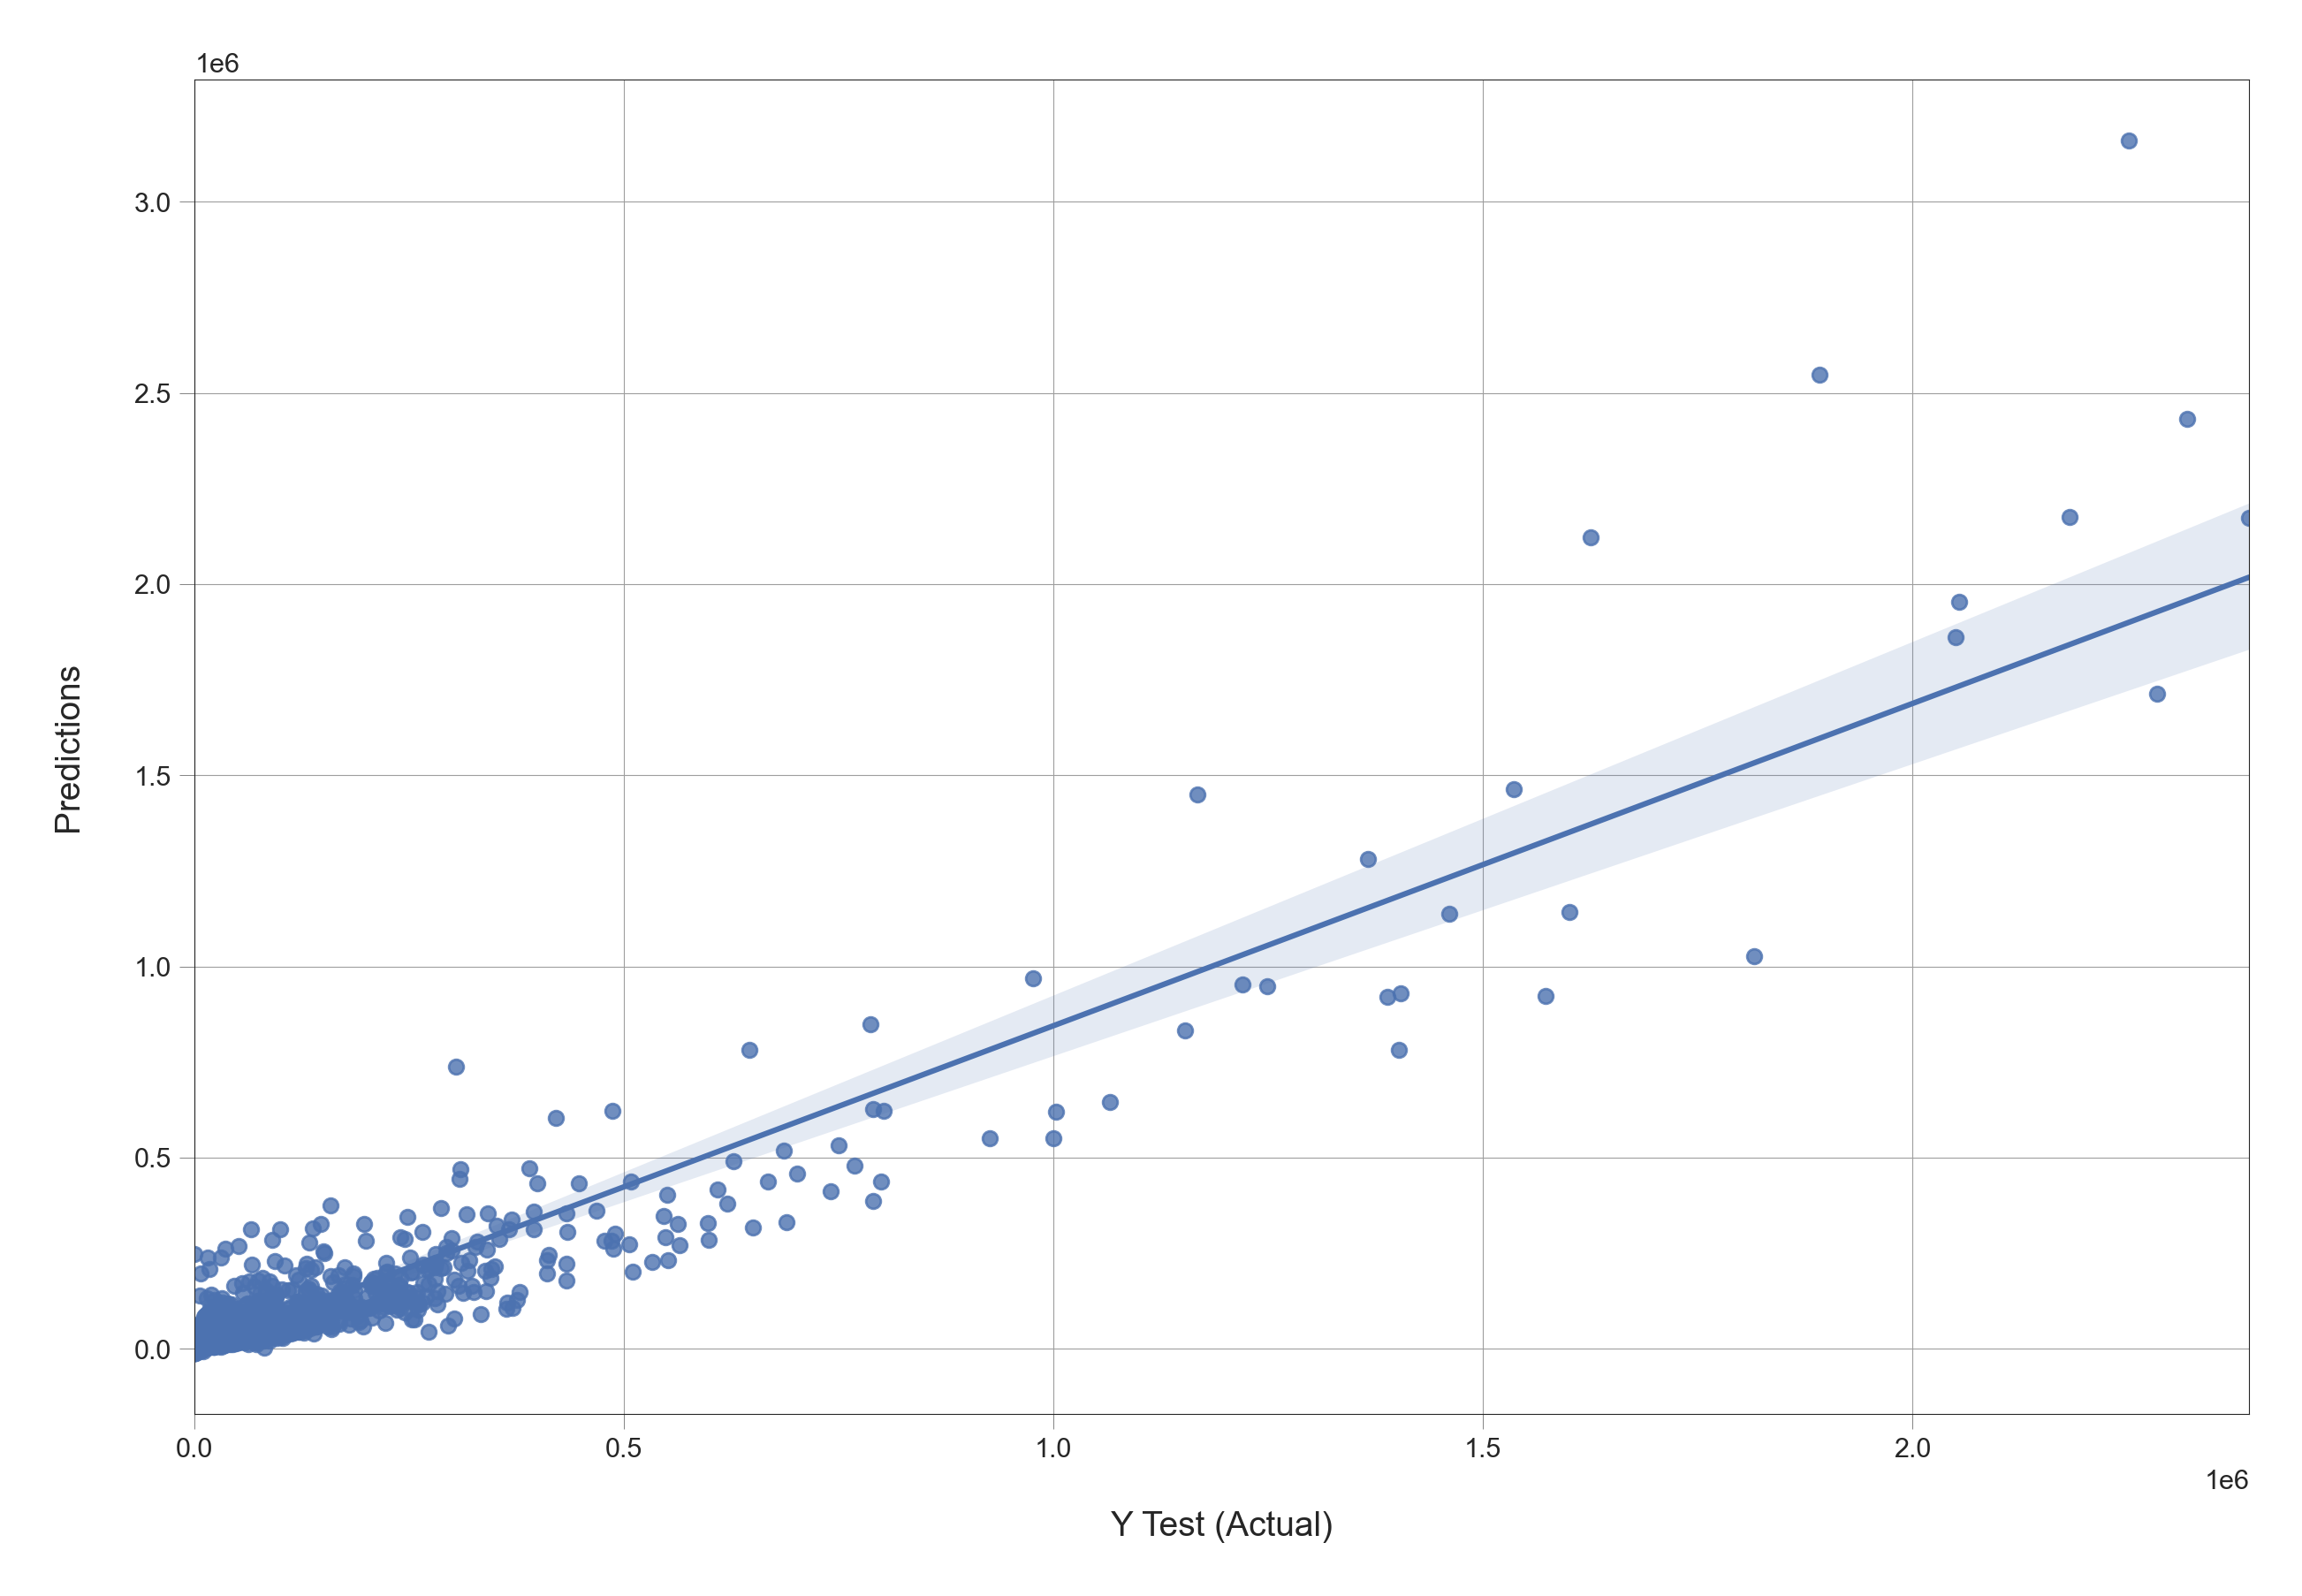

In [142]:
plt.figure(figsize=(15, 10))
g = sns.regplot(y_test, predictions, fit_reg=True)
plt.xlabel('Y Test (Actual)')
plt.ylabel('Predictions')
plt.show(g)

#### 3.3 Fiabilité du résultat

Le propre d’une technique prédictive est d’analyser des faits présents et passés pour faire des hypothèses sur des événements futurs. L’application d'une technique prédictive sur le dataset des tendances Youtube s’est traduit par une modélisation sous forme d’équations (régression linéaire).

Seulement voilà, il y aura toujours des écarts (des erreurs) entre nos résultats (la prédiction) et la réalité (le jeu de données). Pour mesurer ces erreurs il existe plusieurs indicateurs mathématiques (les résidus, l’erreur moyenne absolue et le score de régression) qui nous permettent ou non de valider notre choix de technique.

**Les résidus**

En utilisant la méthode des moindres carrés, nous avons calculé les résidus. Les résidus sont les différences entre les valeurs données dans notre X et celles estimées par le modèle. Les résidus sont déterminés en utilisant la formule ci-dessous :

Résidus = Valeurs observées – Valeurs prédites

Les résidus sont donc des approximations des erreurs inconnues. On montre qu’ils sont centrés (de moyenne nulle) et que leur covariance, qui correspond aux coefficients de corrélation avec les variables explicatives, est nulle.

On peut considérer que la répartition des résidus est gaussienne. Pour s’assurer de cela, affichons la distribution des résidus ainsi que la gaussienne centrée réduite. Nous observons sur le graphique ci-dessous une superposition entre les deux représentations, ce qui nous confirme que les résidus sont centrés réduits.


In [143]:
residuals = (y_test - predictions)
print(residuals)

33158   -1927.70
13400   -5282.20
30763   12758.83
38658   -1884.79
17070   -8563.45
          ...   
8088    -3568.88
30861   -2309.77
23760   -1194.31
7485    -1306.45
39247   -1454.03
Name: likes, Length: 12218, dtype: float64


In [144]:
residuals.mean()

589.3293025638105

[(-500000.0, 500000.0)]

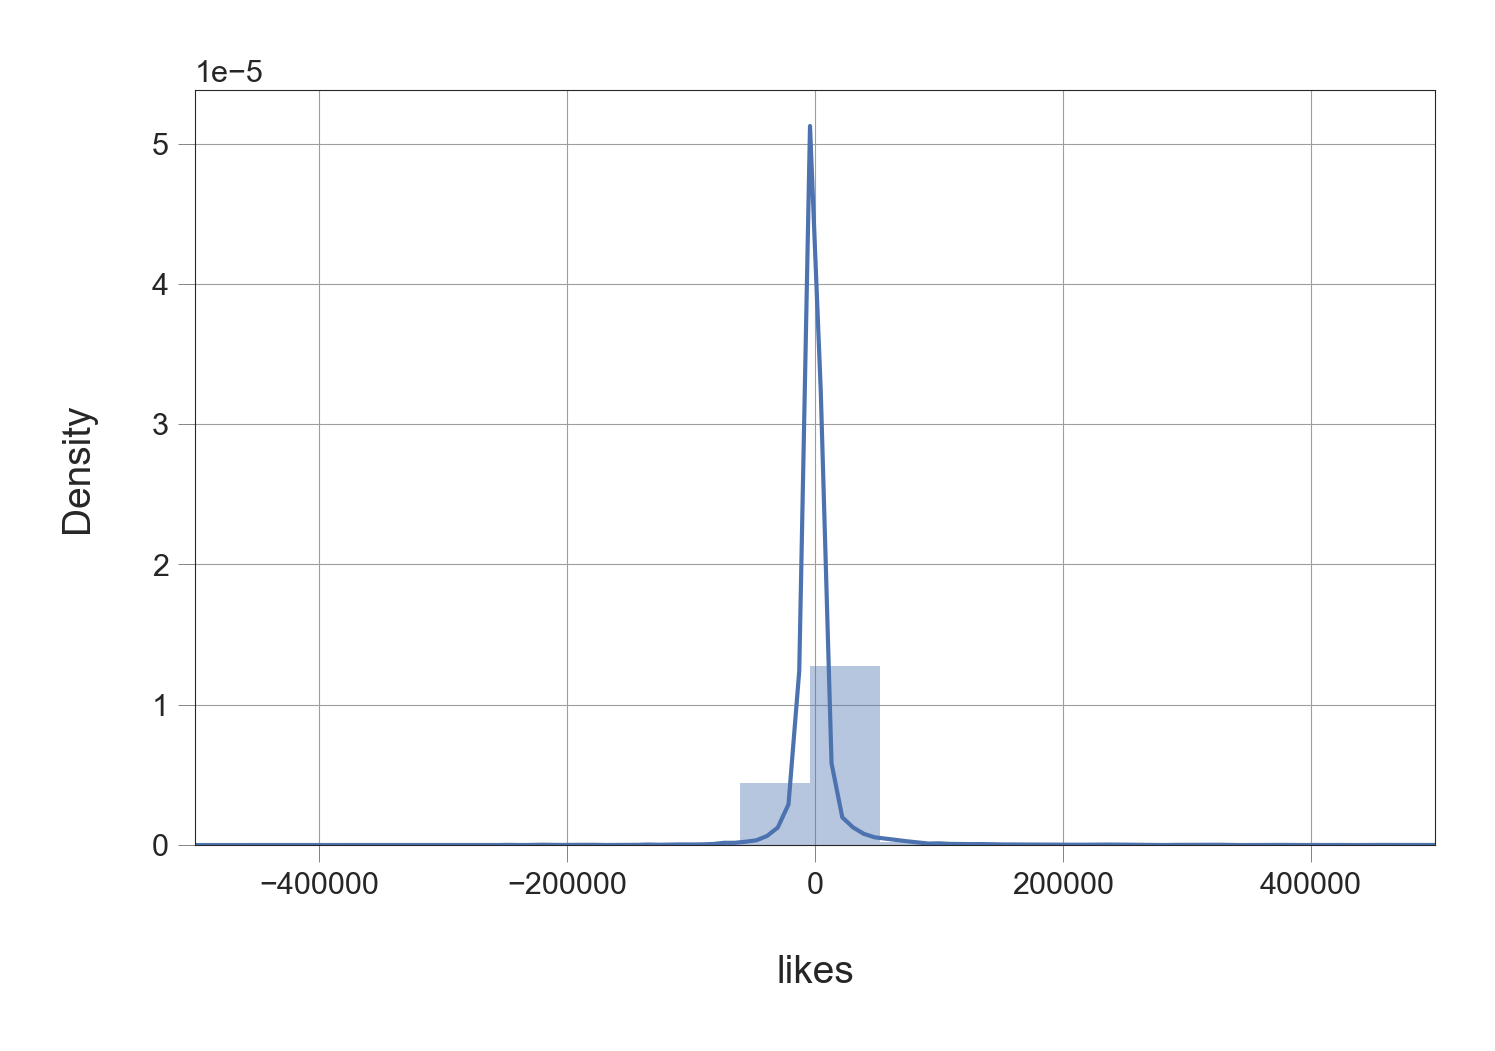

In [145]:
g = sns.distplot(residuals, bins=30)
g.set(xlim=(-500000, 500000))

<AxesSubplot:ylabel='likes'>

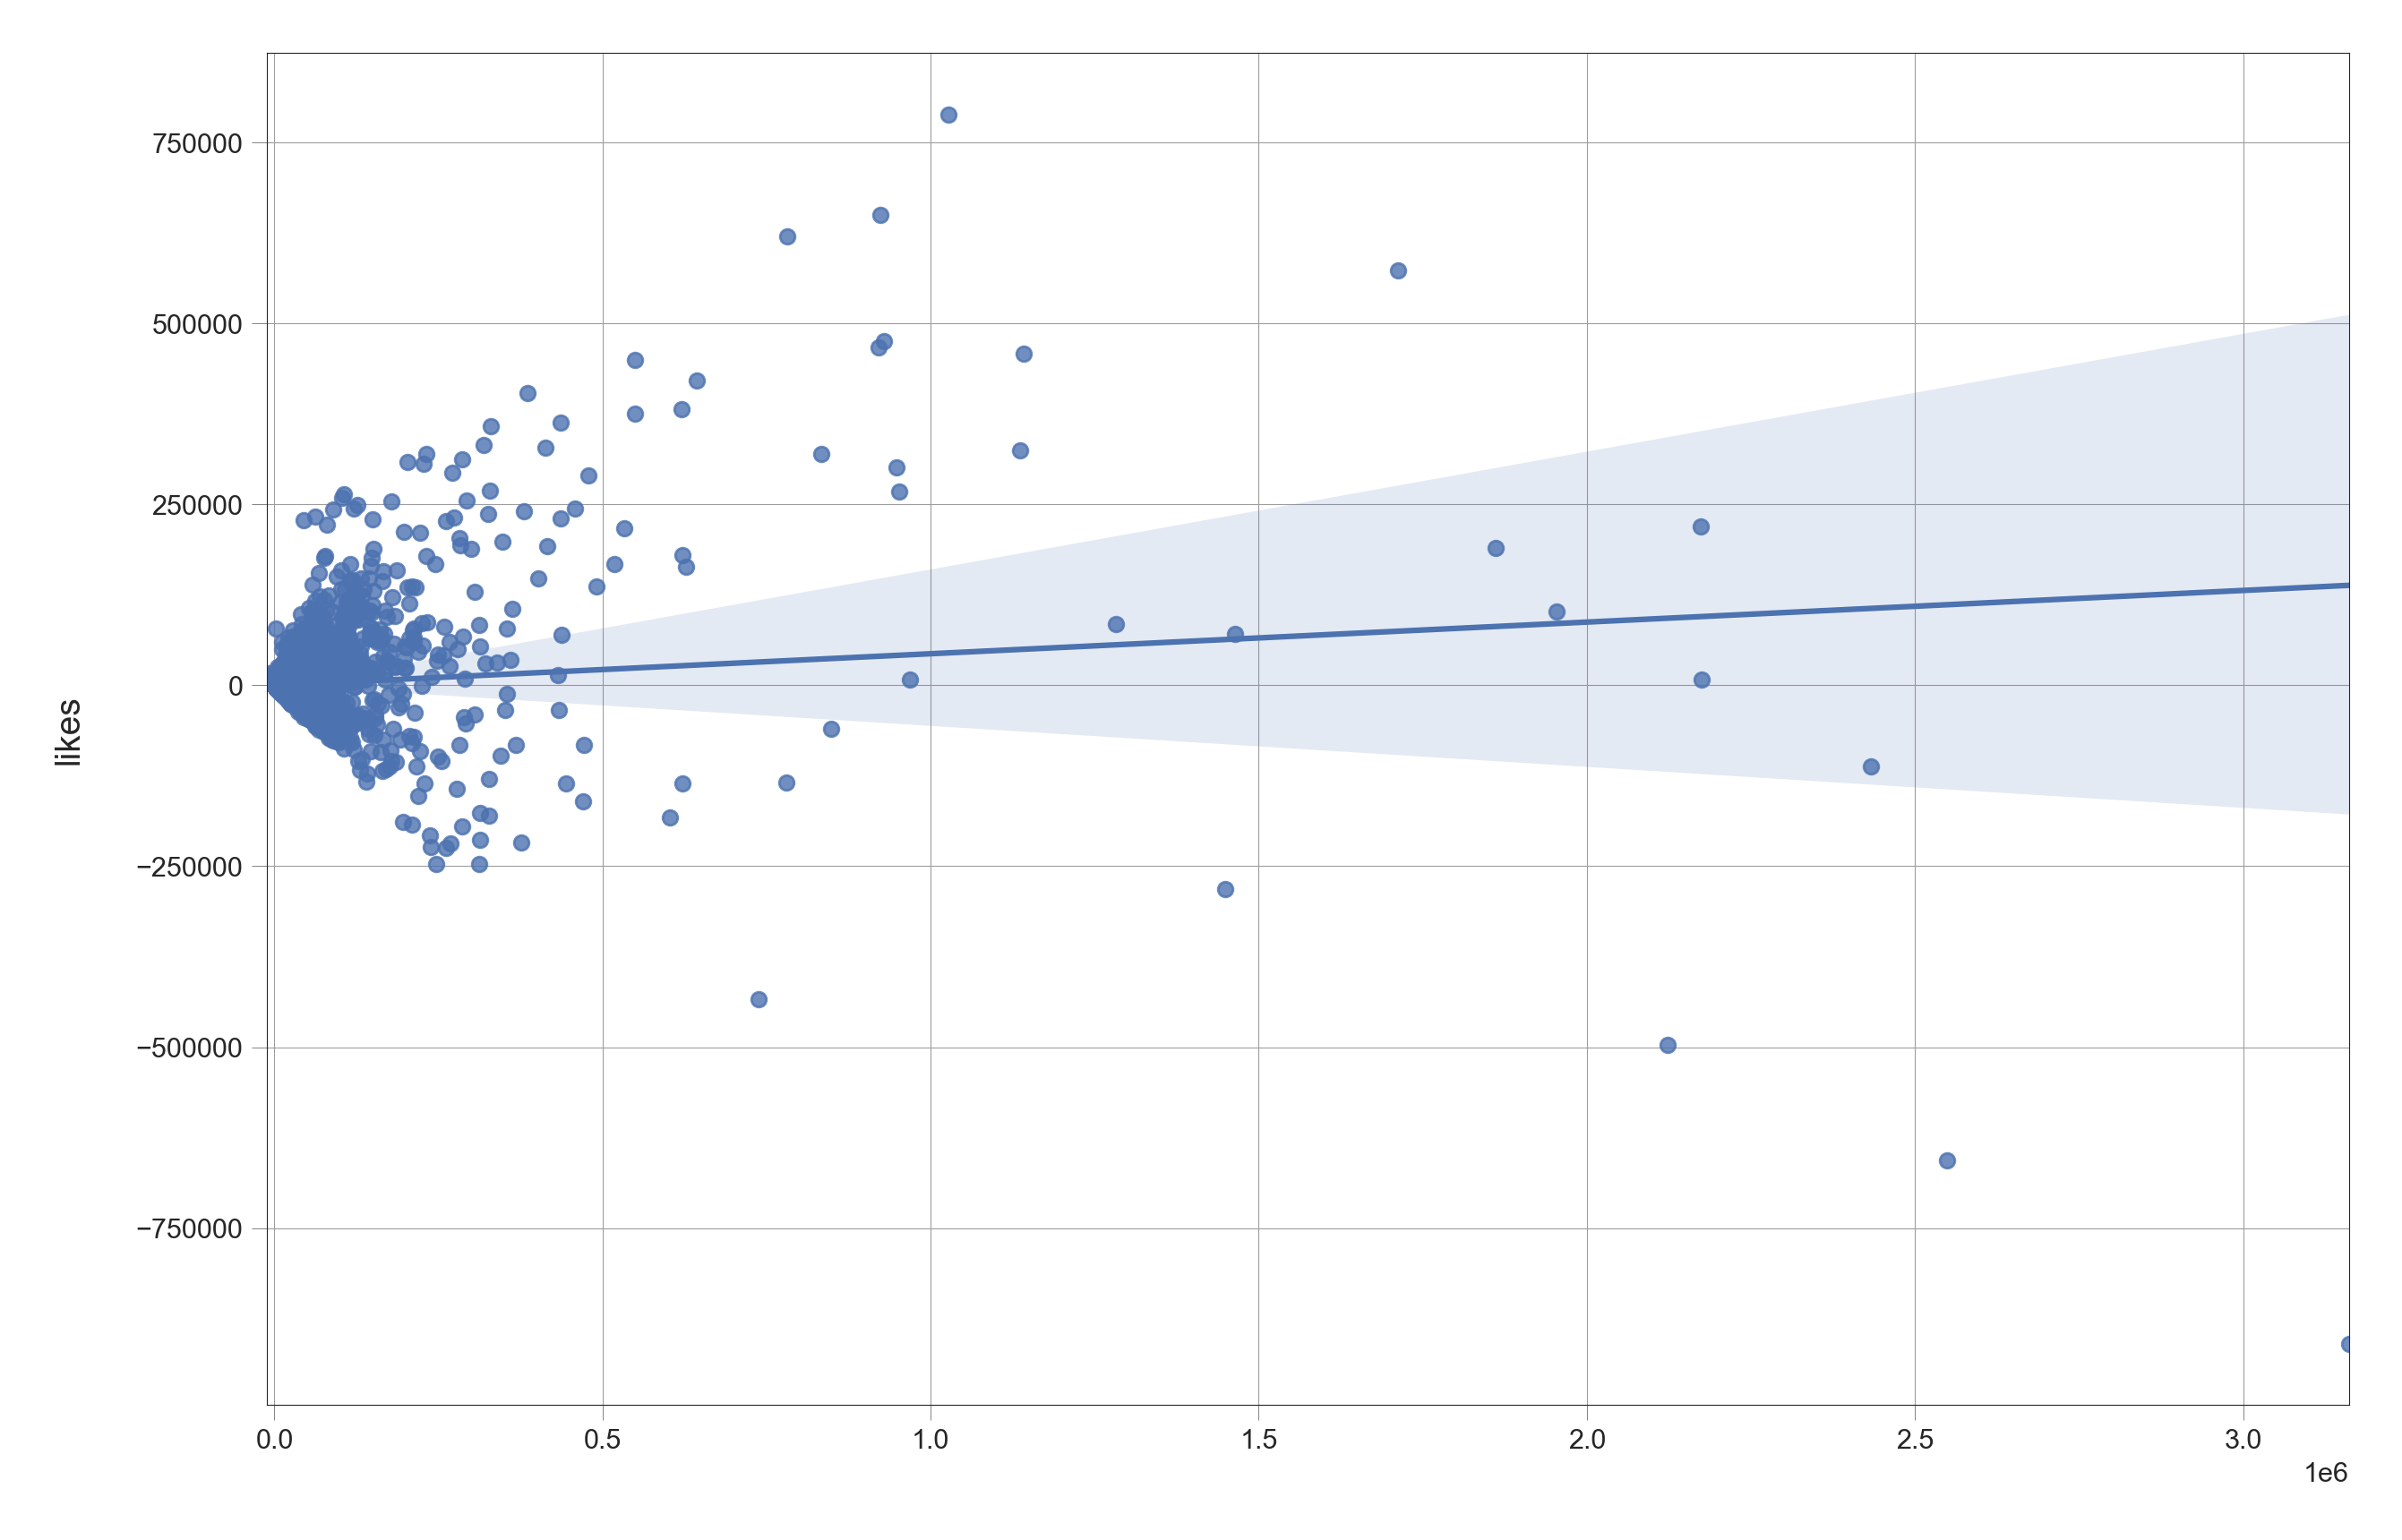

In [146]:
plt.figure(figsize=(15, 10))
sns.regplot(x=predictions, y=residuals, fit_reg=True)

**Erreur moyenne absolue (MAE)**

L’Erreur Moyenne Absolue (MAE) permet d’évaluer si les prédictions sont précises ou non. La MAE est donné par la formule suivante:

$$\large MAE = \frac{\sum_{i=1}^{n} |y_i - x_i|}{n}$$

Avec $n$ le nombre d’individus, $xi$ la valeur de la ième observation du dataset et $y_i$ la valeur prédite pour la ième observation

En utilisant la méthode `mean_absolute_error` du module ‘metrics’ de la bibliothèque ‘sklearn’ en Python3 nous obtenons une MAE égale à 9547.

Comme notre prédiction a été faite sur le nombre de likes, nous sommes en mesure de prédire le nombre de likes avec une erreur de plus ou moins 9547 likes.

Ce chiffre paraît grand mais en considérant que notre échantillon est non homogène en nombre de likes et de vues (présences de valeurs extrêmes) nous concluons que nous  pouvons appliquer ce modèle que sur les vidéos ayant un très grand nombre de vues.

In [153]:
print('MAE :', metrics.mean_absolute_error(y_test, predictions))
print('MSE :', metrics.mean_squared_error(y_test, predictions))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE : 9580.146035503847
MSE : 1002823860.6354692
RMSE : 31667.394282376143


**Score de régression**

La méthode `score` de la classe `LinearRegression` de la bibliothèque `sklearn` permet de calculer le score de la régression réalisée. Le score calculé est le coefficient de détermination (ou coefficient de Pearson).

Ce coefficient mesure l'adéquation entre un modèle issu d’une régression linéaire simple ou multiple et les données observées qui ont permis de l'établir. Certes, il a ses imperfections, mais son utilité n’a d’égale que sa simplicité.

Le coefficient de Pearson est défini par :

$$\large R^2 = 1 - \frac{\sum \limits_{i=1}^{n}(y_i- \hat{y_i})^2}   {\sum \limits_{i=1}^{n}(y_i- \bar{y})^2} $$

où $n$ est le nombre d’individus de l'échantillon,
$yi$ est la valeur de la ième observation du dataset,
$yi$ est la valeur prédite pour la ième observation,
$y$ est la moyenne de l'échantillon.

Le score de régression calculé vaut 0,85, ce qui signifie que l’équation de la droite de régression est capable de déterminer 85% de la distribution des points. Le nuage de points est donc assez centré autour de la droite de régression.

In [152]:
lm.score(X_test, y_test)

0.8778288055104938

## VI. Conclusion

Durant cette étude, nous nous sommes intéressés, dans un premier temps, aux profils des vidéos Youtube qui apparaissent en tendances. L'analyse du titre et des tags d’une vidéo nous ont permis de déterminer les thématiques majeures présentes dans l’onglet des tendances : le divertissement, la musique, la télévision et les séries, les films et bandes annonces, le sport et les actualités.

L’analyse quantitative nous a permis, contre toute attente, de constater que les vidéos présentes dans l’onglet des tendances ne sont pas forcément des vidéos avec un très grand nombre de vues, de likes, de dislikes et de commentaires. Cette constatation se base sur les valeurs observées du troisième quartile pour les variables `views`, `likes`, `dislikes` et `comment_count`, valant respectivement 270000, 8000, 300 et 841. De ce fait, nous pouvons être amenés à penser que l'algorithme se base sur le nombre d’interactions pour une période de temps donnée assez réduite.

Parmi les thématiques majeures, nous retrouvons les actualités et le sport. Ces thèmes sont la plupart du temps associés à la mise en ligne de vidéos se rapportant à un événement précis suscitant un bref engouement (rencontre sportive, politique, faits divers, …). A contrario, les thématiques de la musique, de la télévision et des séries suscitent un engouement sur une durée plus étendue (clips musicaux, épisodes d’une série, ...). Cette constatation permettrait d’expliquer la non-homogénité des interactions relatives aux vidéos en tendance.

Dans un second temps, nous nous sommes intéressés aux liens présents entre les variables quantitatives. Pour ce faire, nous avons étudié la corrélation des variables entre elles grâce à une matrice de corrélation. Cette matrice nous a permis de visualiser une corrélation moyenne à forte au sein du groupe de variables ‘views’, ‘likes’, ‘dislikes’ et `comments_count` ainsi qu’une corrélation moyenne entre les variables `comments_disabled` et `ratings_disabled`.

Les corrélations obtenues montrent que le nombre de likes et de commentaires évoluent quasi parallèlement au nombre de vues. Il ressort également de cette analyse que le nombre de dislikes est beaucoup moins impacté par un nombre grandissant de vues.

Une analyse en composantes principales nous a permis de valider ces observations. Elle nous a également permis de représenter synthétiquement et visuellement la relation entre les variables quantitatives. A partir de cette analyse nous avons pu condenser l’information des variables quantitatives en deux composantes.

Cette étude a été menée sur des données françaises datant de 2017 - 2018. Il serait intéressant de mener cette étude sur le dataset d’un autre pays pour la même période ou sur un dataset plus récent afin de pouvoir comparer les résultats obtenus et constater les évolutions au fil des années.